In [1]:
import numpy as np
from scipy.stats import norm
from datetime import datetime
import scipy.stats as ss

In [2]:
class OnlineSort:
  def __init__(self, value, temporal_index,day_of_week):
    self.value = value
    self.temporal_index = temporal_index
    self.day_of_week = day_of_week

def is_larger(_OnlineSort1,_OnlineSort2):
  if _OnlineSort1.value>_OnlineSort2.value:
    return True
  else:
    return False

def initialize_data(raw_data): # data of at least first two weeks
  online_list = []
  online_eps = []
  sum_ = [0,0,0,0,0,0,0]
  day_ = [0,0,0,0,0,0,0]
  y_list = []
  starting_mean = np.mean(raw_data)
  for i in range(len(raw_data)):
    if i<4:
      y = raw_data[i] - starting_mean
    else:
      y = raw_data[i]-0.4*raw_data[i-1]-0.3*raw_data[i-2]-0.2*raw_data[i-3]-0.1*raw_data[i-4]
    y_list.append(y)
    item = OnlineSort(raw_data[i],i,i%7)  ## later consider missing days
    online_list.append(item)
    sum_[i%7] = sum_[i%7] + y
    day_[i%7] = day_[i%7] + 1
  for i in range(len(raw_data)):
    item = OnlineSort(y_list[i]-sum_[i%7]/day_[i%7], i, i%7)
    online_eps.append(item)
  triplet = {"data":online_list,"sum":sum_,"days":day_}
  return {"triplet":triplet,"online_eps":online_eps}
  
def gather_data(triplet,new_obs): ## in temporal order (after 2 weeks)
  n = len(triplet['data'])
  mu = 0.4*triplet['data'][n-1].value+0.3*triplet['data'][n-2].value+0.2*triplet['data'][n-3].value+0.1*triplet['data'][n-4].value
  new_y = new_obs.value - mu
  new_sum = triplet['sum'][new_obs.day_of_week] + new_y
  new_s = new_sum/(triplet['days'][new_obs.day_of_week]+1)
  delta = new_s - triplet['sum'][new_obs.day_of_week]/triplet['days'][new_obs.day_of_week]
  new_eps = OnlineSort(new_y - new_s,new_obs.temporal_index,new_obs.day_of_week)
  triplet['data'].append(new_obs)
  triplet['sum'][new_obs.day_of_week] = new_sum
  triplet['days'][new_obs.day_of_week] = triplet['days'][new_obs.day_of_week]+1
  return {"delta":delta,"new_eps":new_eps,"triplet":triplet}
  
def argsort_OL(online_eps):  ## used once in the beginning but not online part
  value_list = []
  for i in range(len(online_eps)):
    value_list.append(online_eps[i].value)
  rank = np.argsort(np.array(value_list))
  sorted_eps = []
  for i in range(len(online_eps)):
    sorted_eps.append(online_eps[rank[i]])
  return sorted_eps

def split_update_eps(sorted_eps,new_eps,delta):
  day_eps = []
  rest_eps = []
  for i in range(len(sorted_eps)):
    if sorted_eps[i].day_of_week == new_eps.day_of_week:
      sorted_eps[i].value = sorted_eps[i].value - delta
      day_eps.append(sorted_eps[i])
    else:
      rest_eps.append(sorted_eps[i])
  ## insert new_eps in day_eps
  old_len = len(day_eps)
  for i in range(len(day_eps)):
    if is_larger(day_eps[i],new_eps):
      day_eps.insert(i,new_eps)
      break
  if len(day_eps)==old_len:
    day_eps.insert(old_len,new_eps)
  ## merge day_eps into rest_eps
  new_sorted_eps = [OnlineSort(0,0,0)]*(len(day_eps)+len(rest_eps))
  j = 0
  final_index = 0
  new_rank = -1
  for i in range(len(day_eps)):
    if j<len(rest_eps):
      while(is_larger(day_eps[i],rest_eps[j])):
        new_sorted_eps[final_index] = rest_eps[j]
        j = j + 1
        final_index = final_index + 1
        if j == len(rest_eps):
          break
    new_sorted_eps[final_index] = day_eps[i]
    if day_eps[i].temporal_index == new_eps.temporal_index:
      new_rank = final_index
    final_index = final_index + 1
  if len(new_sorted_eps)>final_index:
    for i in range(len(new_sorted_eps)-final_index):
      new_sorted_eps[final_index+i]=rest_eps[j]
      j = j + 1
  return {"new_sorted_eps":new_sorted_eps,"rank":new_rank}

In [3]:
## variance update
## first apply split_update_eps on every feature, save all the ranks in one vector [ranks]
def cov2corr(cov):
  cov = np.asanyarray(cov)
  std_ = np.sqrt(np.diag(cov))
  corr = cov / np.outer(std_, std_)
  return corr

def var_update(ranks,n,old_var):  ## n means: this is the nth value since the very beginning 
  eps_tilde =  norm.ppf(ranks/(n+1))
  new_var = cov2corr((n-1)/n*old_var+1/n*np.outer(eps_tilde,eps_tilde))
  return new_var

def test_stat(ranks,n,new_var):
  eps_tilde =  norm.ppf(ranks/(n+1))
  stat = eps_tilde.dot(new_var).dot(eps_tilde)
  return stat

In [4]:
n_features = 20
n_days = 5000
raw_data = np.random.normal(size = n_features*n_days)
raw_data = raw_data.reshape((n_days,n_features))
raw_data.shape

(5000, 20)

In [5]:
start_time = datetime.now()
###################################
triplet_all = {}
sorted_eps_all = {}
start_from = 20  ## algorithm starts from 20th day
for i in range(n_features):
  temp = initialize_data(raw_data[0:start_from,i]) 
  triplet_all[str(i)] = temp["triplet"]
  online_eps = temp["online_eps"]
  sorted_eps_all[str(i)] = argsort_OL(online_eps)

sigma = cov2corr(np.cov(raw_data[0:start_from,:]))

time_ol = []
current_time = datetime.now()
for j in np.arange(start_from,n_days):
  ranks = []
  if j%10 == 9:
    time_ol.append((datetime.now()-current_time).total_seconds())
    current_time = datetime.now()
  for i in range(n_features):
    print([j,i])
    new_obs = OnlineSort(raw_data[j,i],j,j%7)
    new_info = gather_data(triplet_all[str(i)],new_obs)
    triplet_all[str(i)] = new_info["triplet"]
    outcome = split_update_eps(sorted_eps_all[str(i)],new_info["new_eps"],new_info["delta"])
    sorted_eps_all[str(i)] = outcome["new_sorted_eps"]
    ranks.append(outcome["rank"])
  sigma = var_update(ranks,j+1,sigma)
  stat = test_stat(ranks,j+1,sigma)
####################################
end_time = datetime.now()
(end_time - start_time).total_seconds()

[20, 0]
[20, 1]
[20, 2]
[20, 3]
[20, 4]
[20, 5]
[20, 6]
[20, 7]
[20, 8]
[20, 9]
[20, 10]
[20, 11]
[20, 12]
[20, 13]
[20, 14]
[20, 15]
[20, 16]
[20, 17]
[20, 18]
[20, 19]
[21, 0]
[21, 1]
[21, 2]
[21, 3]
[21, 4]
[21, 5]
[21, 6]
[21, 7]
[21, 8]
[21, 9]
[21, 10]
[21, 11]
[21, 12]
[21, 13]
[21, 14]
[21, 15]
[21, 16]
[21, 17]
[21, 18]
[21, 19]
[22, 0]
[22, 1]
[22, 2]
[22, 3]
[22, 4]
[22, 5]
[22, 6]
[22, 7]
[22, 8]
[22, 9]
[22, 10]
[22, 11]
[22, 12]
[22, 13]
[22, 14]
[22, 15]
[22, 16]
[22, 17]
[22, 18]
[22, 19]
[23, 0]
[23, 1]
[23, 2]
[23, 3]
[23, 4]
[23, 5]
[23, 6]
[23, 7]
[23, 8]
[23, 9]
[23, 10]
[23, 11]
[23, 12]
[23, 13]
[23, 14]
[23, 15]
[23, 16]
[23, 17]
[23, 18]
[23, 19]
[24, 0]
[24, 1]
[24, 2]
[24, 3]
[24, 4]
[24, 5]
[24, 6]
[24, 7]
[24, 8]
[24, 9]
[24, 10]
[24, 11]
[24, 12]
[24, 13]
[24, 14]
[24, 15]
[24, 16]
[24, 17]
[24, 18]
[24, 19]
[25, 0]
[25, 1]
[25, 2]
[25, 3]
[25, 4]
[25, 5]
[25, 6]
[25, 7]
[25, 8]
[25, 9]
[25, 10]
[25, 11]
[25, 12]
[25, 13]
[25, 14]
[25, 15]
[25, 16]
[25, 17

C:\Users\glius\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\glius\Anaconda3\lib\site-packages\numpy\core\numeric.py:1120: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)



[92, 11]
[92, 12]
[92, 13]
[92, 14]
[92, 15]
[92, 16]
[92, 17]
[92, 18]
[92, 19]
[93, 0]
[93, 1]
[93, 2]
[93, 3]
[93, 4]
[93, 5]
[93, 6]
[93, 7]
[93, 8]
[93, 9]
[93, 10]
[93, 11]
[93, 12]
[93, 13]
[93, 14]
[93, 15]
[93, 16]
[93, 17]
[93, 18]
[93, 19]
[94, 0]
[94, 1]
[94, 2]
[94, 3]
[94, 4]
[94, 5]
[94, 6]
[94, 7]
[94, 8]
[94, 9]
[94, 10]
[94, 11]
[94, 12]
[94, 13]
[94, 14]
[94, 15]
[94, 16]
[94, 17]
[94, 18]
[94, 19]
[95, 0]
[95, 1]
[95, 2]
[95, 3]
[95, 4]
[95, 5]
[95, 6]
[95, 7]
[95, 8]
[95, 9]
[95, 10]
[95, 11]
[95, 12]
[95, 13]
[95, 14]
[95, 15]
[95, 16]
[95, 17]
[95, 18]
[95, 19]
[96, 0]
[96, 1]
[96, 2]
[96, 3]
[96, 4]
[96, 5]
[96, 6]
[96, 7]
[96, 8]
[96, 9]
[96, 10]
[96, 11]
[96, 12]
[96, 13]
[96, 14]
[96, 15]
[96, 16]
[96, 17]
[96, 18]
[96, 19]
[97, 0]
[97, 1]
[97, 2]
[97, 3]
[97, 4]
[97, 5]
[97, 6]
[97, 7]
[97, 8]
[97, 9]
[97, 10]
[97, 11]
[97, 12]
[97, 13]
[97, 14]
[97, 15]
[97, 16]
[97, 17]
[97, 18]
[97, 19]
[98, 0]
[98, 1]
[98, 2]
[98, 3]
[98, 4]
[98, 5]
[98, 6]
[98, 7]
[98,

[142, 19]
[143, 0]
[143, 1]
[143, 2]
[143, 3]
[143, 4]
[143, 5]
[143, 6]
[143, 7]
[143, 8]
[143, 9]
[143, 10]
[143, 11]
[143, 12]
[143, 13]
[143, 14]
[143, 15]
[143, 16]
[143, 17]
[143, 18]
[143, 19]
[144, 0]
[144, 1]
[144, 2]
[144, 3]
[144, 4]
[144, 5]
[144, 6]
[144, 7]
[144, 8]
[144, 9]
[144, 10]
[144, 11]
[144, 12]
[144, 13]
[144, 14]
[144, 15]
[144, 16]
[144, 17]
[144, 18]
[144, 19]
[145, 0]
[145, 1]
[145, 2]
[145, 3]
[145, 4]
[145, 5]
[145, 6]
[145, 7]
[145, 8]
[145, 9]
[145, 10]
[145, 11]
[145, 12]
[145, 13]
[145, 14]
[145, 15]
[145, 16]
[145, 17]
[145, 18]
[145, 19]
[146, 0]
[146, 1]
[146, 2]
[146, 3]
[146, 4]
[146, 5]
[146, 6]
[146, 7]
[146, 8]
[146, 9]
[146, 10]
[146, 11]
[146, 12]
[146, 13]
[146, 14]
[146, 15]
[146, 16]
[146, 17]
[146, 18]
[146, 19]
[147, 0]
[147, 1]
[147, 2]
[147, 3]
[147, 4]
[147, 5]
[147, 6]
[147, 7]
[147, 8]
[147, 9]
[147, 10]
[147, 11]
[147, 12]
[147, 13]
[147, 14]
[147, 15]
[147, 16]
[147, 17]
[147, 18]
[147, 19]
[148, 0]
[148, 1]
[148, 2]
[148, 3]
[148

[220, 8]
[220, 9]
[220, 10]
[220, 11]
[220, 12]
[220, 13]
[220, 14]
[220, 15]
[220, 16]
[220, 17]
[220, 18]
[220, 19]
[221, 0]
[221, 1]
[221, 2]
[221, 3]
[221, 4]
[221, 5]
[221, 6]
[221, 7]
[221, 8]
[221, 9]
[221, 10]
[221, 11]
[221, 12]
[221, 13]
[221, 14]
[221, 15]
[221, 16]
[221, 17]
[221, 18]
[221, 19]
[222, 0]
[222, 1]
[222, 2]
[222, 3]
[222, 4]
[222, 5]
[222, 6]
[222, 7]
[222, 8]
[222, 9]
[222, 10]
[222, 11]
[222, 12]
[222, 13]
[222, 14]
[222, 15]
[222, 16]
[222, 17]
[222, 18]
[222, 19]
[223, 0]
[223, 1]
[223, 2]
[223, 3]
[223, 4]
[223, 5]
[223, 6]
[223, 7]
[223, 8]
[223, 9]
[223, 10]
[223, 11]
[223, 12]
[223, 13]
[223, 14]
[223, 15]
[223, 16]
[223, 17]
[223, 18]
[223, 19]
[224, 0]
[224, 1]
[224, 2]
[224, 3]
[224, 4]
[224, 5]
[224, 6]
[224, 7]
[224, 8]
[224, 9]
[224, 10]
[224, 11]
[224, 12]
[224, 13]
[224, 14]
[224, 15]
[224, 16]
[224, 17]
[224, 18]
[224, 19]
[225, 0]
[225, 1]
[225, 2]
[225, 3]
[225, 4]
[225, 5]
[225, 6]
[225, 7]
[225, 8]
[225, 9]
[225, 10]
[225, 11]
[225, 12]
[2

[292, 17]
[292, 18]
[292, 19]
[293, 0]
[293, 1]
[293, 2]
[293, 3]
[293, 4]
[293, 5]
[293, 6]
[293, 7]
[293, 8]
[293, 9]
[293, 10]
[293, 11]
[293, 12]
[293, 13]
[293, 14]
[293, 15]
[293, 16]
[293, 17]
[293, 18]
[293, 19]
[294, 0]
[294, 1]
[294, 2]
[294, 3]
[294, 4]
[294, 5]
[294, 6]
[294, 7]
[294, 8]
[294, 9]
[294, 10]
[294, 11]
[294, 12]
[294, 13]
[294, 14]
[294, 15]
[294, 16]
[294, 17]
[294, 18]
[294, 19]
[295, 0]
[295, 1]
[295, 2]
[295, 3]
[295, 4]
[295, 5]
[295, 6]
[295, 7]
[295, 8]
[295, 9]
[295, 10]
[295, 11]
[295, 12]
[295, 13]
[295, 14]
[295, 15]
[295, 16]
[295, 17]
[295, 18]
[295, 19]
[296, 0]
[296, 1]
[296, 2]
[296, 3]
[296, 4]
[296, 5]
[296, 6]
[296, 7]
[296, 8]
[296, 9]
[296, 10]
[296, 11]
[296, 12]
[296, 13]
[296, 14]
[296, 15]
[296, 16]
[296, 17]
[296, 18]
[296, 19]
[297, 0]
[297, 1]
[297, 2]
[297, 3]
[297, 4]
[297, 5]
[297, 6]
[297, 7]
[297, 8]
[297, 9]
[297, 10]
[297, 11]
[297, 12]
[297, 13]
[297, 14]
[297, 15]
[297, 16]
[297, 17]
[297, 18]
[297, 19]
[298, 0]
[298, 1]
[2

[351, 6]
[351, 7]
[351, 8]
[351, 9]
[351, 10]
[351, 11]
[351, 12]
[351, 13]
[351, 14]
[351, 15]
[351, 16]
[351, 17]
[351, 18]
[351, 19]
[352, 0]
[352, 1]
[352, 2]
[352, 3]
[352, 4]
[352, 5]
[352, 6]
[352, 7]
[352, 8]
[352, 9]
[352, 10]
[352, 11]
[352, 12]
[352, 13]
[352, 14]
[352, 15]
[352, 16]
[352, 17]
[352, 18]
[352, 19]
[353, 0]
[353, 1]
[353, 2]
[353, 3]
[353, 4]
[353, 5]
[353, 6]
[353, 7]
[353, 8]
[353, 9]
[353, 10]
[353, 11]
[353, 12]
[353, 13]
[353, 14]
[353, 15]
[353, 16]
[353, 17]
[353, 18]
[353, 19]
[354, 0]
[354, 1]
[354, 2]
[354, 3]
[354, 4]
[354, 5]
[354, 6]
[354, 7]
[354, 8]
[354, 9]
[354, 10]
[354, 11]
[354, 12]
[354, 13]
[354, 14]
[354, 15]
[354, 16]
[354, 17]
[354, 18]
[354, 19]
[355, 0]
[355, 1]
[355, 2]
[355, 3]
[355, 4]
[355, 5]
[355, 6]
[355, 7]
[355, 8]
[355, 9]
[355, 10]
[355, 11]
[355, 12]
[355, 13]
[355, 14]
[355, 15]
[355, 16]
[355, 17]
[355, 18]
[355, 19]
[356, 0]
[356, 1]
[356, 2]
[356, 3]
[356, 4]
[356, 5]
[356, 6]
[356, 7]
[356, 8]
[356, 9]
[356, 10]
[356

[405, 0]
[405, 1]
[405, 2]
[405, 3]
[405, 4]
[405, 5]
[405, 6]
[405, 7]
[405, 8]
[405, 9]
[405, 10]
[405, 11]
[405, 12]
[405, 13]
[405, 14]
[405, 15]
[405, 16]
[405, 17]
[405, 18]
[405, 19]
[406, 0]
[406, 1]
[406, 2]
[406, 3]
[406, 4]
[406, 5]
[406, 6]
[406, 7]
[406, 8]
[406, 9]
[406, 10]
[406, 11]
[406, 12]
[406, 13]
[406, 14]
[406, 15]
[406, 16]
[406, 17]
[406, 18]
[406, 19]
[407, 0]
[407, 1]
[407, 2]
[407, 3]
[407, 4]
[407, 5]
[407, 6]
[407, 7]
[407, 8]
[407, 9]
[407, 10]
[407, 11]
[407, 12]
[407, 13]
[407, 14]
[407, 15]
[407, 16]
[407, 17]
[407, 18]
[407, 19]
[408, 0]
[408, 1]
[408, 2]
[408, 3]
[408, 4]
[408, 5]
[408, 6]
[408, 7]
[408, 8]
[408, 9]
[408, 10]
[408, 11]
[408, 12]
[408, 13]
[408, 14]
[408, 15]
[408, 16]
[408, 17]
[408, 18]
[408, 19]
[409, 0]
[409, 1]
[409, 2]
[409, 3]
[409, 4]
[409, 5]
[409, 6]
[409, 7]
[409, 8]
[409, 9]
[409, 10]
[409, 11]
[409, 12]
[409, 13]
[409, 14]
[409, 15]
[409, 16]
[409, 17]
[409, 18]
[409, 19]
[410, 0]
[410, 1]
[410, 2]
[410, 3]
[410, 4]
[410,

[454, 9]
[454, 10]
[454, 11]
[454, 12]
[454, 13]
[454, 14]
[454, 15]
[454, 16]
[454, 17]
[454, 18]
[454, 19]
[455, 0]
[455, 1]
[455, 2]
[455, 3]
[455, 4]
[455, 5]
[455, 6]
[455, 7]
[455, 8]
[455, 9]
[455, 10]
[455, 11]
[455, 12]
[455, 13]
[455, 14]
[455, 15]
[455, 16]
[455, 17]
[455, 18]
[455, 19]
[456, 0]
[456, 1]
[456, 2]
[456, 3]
[456, 4]
[456, 5]
[456, 6]
[456, 7]
[456, 8]
[456, 9]
[456, 10]
[456, 11]
[456, 12]
[456, 13]
[456, 14]
[456, 15]
[456, 16]
[456, 17]
[456, 18]
[456, 19]
[457, 0]
[457, 1]
[457, 2]
[457, 3]
[457, 4]
[457, 5]
[457, 6]
[457, 7]
[457, 8]
[457, 9]
[457, 10]
[457, 11]
[457, 12]
[457, 13]
[457, 14]
[457, 15]
[457, 16]
[457, 17]
[457, 18]
[457, 19]
[458, 0]
[458, 1]
[458, 2]
[458, 3]
[458, 4]
[458, 5]
[458, 6]
[458, 7]
[458, 8]
[458, 9]
[458, 10]
[458, 11]
[458, 12]
[458, 13]
[458, 14]
[458, 15]
[458, 16]
[458, 17]
[458, 18]
[458, 19]
[459, 0]
[459, 1]
[459, 2]
[459, 3]
[459, 4]
[459, 5]
[459, 6]
[459, 7]
[459, 8]
[459, 9]
[459, 10]
[459, 11]
[459, 12]
[459, 13]
[

[502, 3]
[502, 4]
[502, 5]
[502, 6]
[502, 7]
[502, 8]
[502, 9]
[502, 10]
[502, 11]
[502, 12]
[502, 13]
[502, 14]
[502, 15]
[502, 16]
[502, 17]
[502, 18]
[502, 19]
[503, 0]
[503, 1]
[503, 2]
[503, 3]
[503, 4]
[503, 5]
[503, 6]
[503, 7]
[503, 8]
[503, 9]
[503, 10]
[503, 11]
[503, 12]
[503, 13]
[503, 14]
[503, 15]
[503, 16]
[503, 17]
[503, 18]
[503, 19]
[504, 0]
[504, 1]
[504, 2]
[504, 3]
[504, 4]
[504, 5]
[504, 6]
[504, 7]
[504, 8]
[504, 9]
[504, 10]
[504, 11]
[504, 12]
[504, 13]
[504, 14]
[504, 15]
[504, 16]
[504, 17]
[504, 18]
[504, 19]
[505, 0]
[505, 1]
[505, 2]
[505, 3]
[505, 4]
[505, 5]
[505, 6]
[505, 7]
[505, 8]
[505, 9]
[505, 10]
[505, 11]
[505, 12]
[505, 13]
[505, 14]
[505, 15]
[505, 16]
[505, 17]
[505, 18]
[505, 19]
[506, 0]
[506, 1]
[506, 2]
[506, 3]
[506, 4]
[506, 5]
[506, 6]
[506, 7]
[506, 8]
[506, 9]
[506, 10]
[506, 11]
[506, 12]
[506, 13]
[506, 14]
[506, 15]
[506, 16]
[506, 17]
[506, 18]
[506, 19]
[507, 0]
[507, 1]
[507, 2]
[507, 3]
[507, 4]
[507, 5]
[507, 6]
[507, 7]
[507,

[566, 9]
[566, 10]
[566, 11]
[566, 12]
[566, 13]
[566, 14]
[566, 15]
[566, 16]
[566, 17]
[566, 18]
[566, 19]
[567, 0]
[567, 1]
[567, 2]
[567, 3]
[567, 4]
[567, 5]
[567, 6]
[567, 7]
[567, 8]
[567, 9]
[567, 10]
[567, 11]
[567, 12]
[567, 13]
[567, 14]
[567, 15]
[567, 16]
[567, 17]
[567, 18]
[567, 19]
[568, 0]
[568, 1]
[568, 2]
[568, 3]
[568, 4]
[568, 5]
[568, 6]
[568, 7]
[568, 8]
[568, 9]
[568, 10]
[568, 11]
[568, 12]
[568, 13]
[568, 14]
[568, 15]
[568, 16]
[568, 17]
[568, 18]
[568, 19]
[569, 0]
[569, 1]
[569, 2]
[569, 3]
[569, 4]
[569, 5]
[569, 6]
[569, 7]
[569, 8]
[569, 9]
[569, 10]
[569, 11]
[569, 12]
[569, 13]
[569, 14]
[569, 15]
[569, 16]
[569, 17]
[569, 18]
[569, 19]
[570, 0]
[570, 1]
[570, 2]
[570, 3]
[570, 4]
[570, 5]
[570, 6]
[570, 7]
[570, 8]
[570, 9]
[570, 10]
[570, 11]
[570, 12]
[570, 13]
[570, 14]
[570, 15]
[570, 16]
[570, 17]
[570, 18]
[570, 19]
[571, 0]
[571, 1]
[571, 2]
[571, 3]
[571, 4]
[571, 5]
[571, 6]
[571, 7]
[571, 8]
[571, 9]
[571, 10]
[571, 11]
[571, 12]
[571, 13]
[

[617, 10]
[617, 11]
[617, 12]
[617, 13]
[617, 14]
[617, 15]
[617, 16]
[617, 17]
[617, 18]
[617, 19]
[618, 0]
[618, 1]
[618, 2]
[618, 3]
[618, 4]
[618, 5]
[618, 6]
[618, 7]
[618, 8]
[618, 9]
[618, 10]
[618, 11]
[618, 12]
[618, 13]
[618, 14]
[618, 15]
[618, 16]
[618, 17]
[618, 18]
[618, 19]
[619, 0]
[619, 1]
[619, 2]
[619, 3]
[619, 4]
[619, 5]
[619, 6]
[619, 7]
[619, 8]
[619, 9]
[619, 10]
[619, 11]
[619, 12]
[619, 13]
[619, 14]
[619, 15]
[619, 16]
[619, 17]
[619, 18]
[619, 19]
[620, 0]
[620, 1]
[620, 2]
[620, 3]
[620, 4]
[620, 5]
[620, 6]
[620, 7]
[620, 8]
[620, 9]
[620, 10]
[620, 11]
[620, 12]
[620, 13]
[620, 14]
[620, 15]
[620, 16]
[620, 17]
[620, 18]
[620, 19]
[621, 0]
[621, 1]
[621, 2]
[621, 3]
[621, 4]
[621, 5]
[621, 6]
[621, 7]
[621, 8]
[621, 9]
[621, 10]
[621, 11]
[621, 12]
[621, 13]
[621, 14]
[621, 15]
[621, 16]
[621, 17]
[621, 18]
[621, 19]
[622, 0]
[622, 1]
[622, 2]
[622, 3]
[622, 4]
[622, 5]
[622, 6]
[622, 7]
[622, 8]
[622, 9]
[622, 10]
[622, 11]
[622, 12]
[622, 13]
[622, 14]


[663, 6]
[663, 7]
[663, 8]
[663, 9]
[663, 10]
[663, 11]
[663, 12]
[663, 13]
[663, 14]
[663, 15]
[663, 16]
[663, 17]
[663, 18]
[663, 19]
[664, 0]
[664, 1]
[664, 2]
[664, 3]
[664, 4]
[664, 5]
[664, 6]
[664, 7]
[664, 8]
[664, 9]
[664, 10]
[664, 11]
[664, 12]
[664, 13]
[664, 14]
[664, 15]
[664, 16]
[664, 17]
[664, 18]
[664, 19]
[665, 0]
[665, 1]
[665, 2]
[665, 3]
[665, 4]
[665, 5]
[665, 6]
[665, 7]
[665, 8]
[665, 9]
[665, 10]
[665, 11]
[665, 12]
[665, 13]
[665, 14]
[665, 15]
[665, 16]
[665, 17]
[665, 18]
[665, 19]
[666, 0]
[666, 1]
[666, 2]
[666, 3]
[666, 4]
[666, 5]
[666, 6]
[666, 7]
[666, 8]
[666, 9]
[666, 10]
[666, 11]
[666, 12]
[666, 13]
[666, 14]
[666, 15]
[666, 16]
[666, 17]
[666, 18]
[666, 19]
[667, 0]
[667, 1]
[667, 2]
[667, 3]
[667, 4]
[667, 5]
[667, 6]
[667, 7]
[667, 8]
[667, 9]
[667, 10]
[667, 11]
[667, 12]
[667, 13]
[667, 14]
[667, 15]
[667, 16]
[667, 17]
[667, 18]
[667, 19]
[668, 0]
[668, 1]
[668, 2]
[668, 3]
[668, 4]
[668, 5]
[668, 6]
[668, 7]
[668, 8]
[668, 9]
[668, 10]
[668

[707, 8]
[707, 9]
[707, 10]
[707, 11]
[707, 12]
[707, 13]
[707, 14]
[707, 15]
[707, 16]
[707, 17]
[707, 18]
[707, 19]
[708, 0]
[708, 1]
[708, 2]
[708, 3]
[708, 4]
[708, 5]
[708, 6]
[708, 7]
[708, 8]
[708, 9]
[708, 10]
[708, 11]
[708, 12]
[708, 13]
[708, 14]
[708, 15]
[708, 16]
[708, 17]
[708, 18]
[708, 19]
[709, 0]
[709, 1]
[709, 2]
[709, 3]
[709, 4]
[709, 5]
[709, 6]
[709, 7]
[709, 8]
[709, 9]
[709, 10]
[709, 11]
[709, 12]
[709, 13]
[709, 14]
[709, 15]
[709, 16]
[709, 17]
[709, 18]
[709, 19]
[710, 0]
[710, 1]
[710, 2]
[710, 3]
[710, 4]
[710, 5]
[710, 6]
[710, 7]
[710, 8]
[710, 9]
[710, 10]
[710, 11]
[710, 12]
[710, 13]
[710, 14]
[710, 15]
[710, 16]
[710, 17]
[710, 18]
[710, 19]
[711, 0]
[711, 1]
[711, 2]
[711, 3]
[711, 4]
[711, 5]
[711, 6]
[711, 7]
[711, 8]
[711, 9]
[711, 10]
[711, 11]
[711, 12]
[711, 13]
[711, 14]
[711, 15]
[711, 16]
[711, 17]
[711, 18]
[711, 19]
[712, 0]
[712, 1]
[712, 2]
[712, 3]
[712, 4]
[712, 5]
[712, 6]
[712, 7]
[712, 8]
[712, 9]
[712, 10]
[712, 11]
[712, 12]
[7

[766, 0]
[766, 1]
[766, 2]
[766, 3]
[766, 4]
[766, 5]
[766, 6]
[766, 7]
[766, 8]
[766, 9]
[766, 10]
[766, 11]
[766, 12]
[766, 13]
[766, 14]
[766, 15]
[766, 16]
[766, 17]
[766, 18]
[766, 19]
[767, 0]
[767, 1]
[767, 2]
[767, 3]
[767, 4]
[767, 5]
[767, 6]
[767, 7]
[767, 8]
[767, 9]
[767, 10]
[767, 11]
[767, 12]
[767, 13]
[767, 14]
[767, 15]
[767, 16]
[767, 17]
[767, 18]
[767, 19]
[768, 0]
[768, 1]
[768, 2]
[768, 3]
[768, 4]
[768, 5]
[768, 6]
[768, 7]
[768, 8]
[768, 9]
[768, 10]
[768, 11]
[768, 12]
[768, 13]
[768, 14]
[768, 15]
[768, 16]
[768, 17]
[768, 18]
[768, 19]
[769, 0]
[769, 1]
[769, 2]
[769, 3]
[769, 4]
[769, 5]
[769, 6]
[769, 7]
[769, 8]
[769, 9]
[769, 10]
[769, 11]
[769, 12]
[769, 13]
[769, 14]
[769, 15]
[769, 16]
[769, 17]
[769, 18]
[769, 19]
[770, 0]
[770, 1]
[770, 2]
[770, 3]
[770, 4]
[770, 5]
[770, 6]
[770, 7]
[770, 8]
[770, 9]
[770, 10]
[770, 11]
[770, 12]
[770, 13]
[770, 14]
[770, 15]
[770, 16]
[770, 17]
[770, 18]
[770, 19]
[771, 0]
[771, 1]
[771, 2]
[771, 3]
[771, 4]
[771,

[817, 5]
[817, 6]
[817, 7]
[817, 8]
[817, 9]
[817, 10]
[817, 11]
[817, 12]
[817, 13]
[817, 14]
[817, 15]
[817, 16]
[817, 17]
[817, 18]
[817, 19]
[818, 0]
[818, 1]
[818, 2]
[818, 3]
[818, 4]
[818, 5]
[818, 6]
[818, 7]
[818, 8]
[818, 9]
[818, 10]
[818, 11]
[818, 12]
[818, 13]
[818, 14]
[818, 15]
[818, 16]
[818, 17]
[818, 18]
[818, 19]
[819, 0]
[819, 1]
[819, 2]
[819, 3]
[819, 4]
[819, 5]
[819, 6]
[819, 7]
[819, 8]
[819, 9]
[819, 10]
[819, 11]
[819, 12]
[819, 13]
[819, 14]
[819, 15]
[819, 16]
[819, 17]
[819, 18]
[819, 19]
[820, 0]
[820, 1]
[820, 2]
[820, 3]
[820, 4]
[820, 5]
[820, 6]
[820, 7]
[820, 8]
[820, 9]
[820, 10]
[820, 11]
[820, 12]
[820, 13]
[820, 14]
[820, 15]
[820, 16]
[820, 17]
[820, 18]
[820, 19]
[821, 0]
[821, 1]
[821, 2]
[821, 3]
[821, 4]
[821, 5]
[821, 6]
[821, 7]
[821, 8]
[821, 9]
[821, 10]
[821, 11]
[821, 12]
[821, 13]
[821, 14]
[821, 15]
[821, 16]
[821, 17]
[821, 18]
[821, 19]
[822, 0]
[822, 1]
[822, 2]
[822, 3]
[822, 4]
[822, 5]
[822, 6]
[822, 7]
[822, 8]
[822, 9]
[822,

[867, 4]
[867, 5]
[867, 6]
[867, 7]
[867, 8]
[867, 9]
[867, 10]
[867, 11]
[867, 12]
[867, 13]
[867, 14]
[867, 15]
[867, 16]
[867, 17]
[867, 18]
[867, 19]
[868, 0]
[868, 1]
[868, 2]
[868, 3]
[868, 4]
[868, 5]
[868, 6]
[868, 7]
[868, 8]
[868, 9]
[868, 10]
[868, 11]
[868, 12]
[868, 13]
[868, 14]
[868, 15]
[868, 16]
[868, 17]
[868, 18]
[868, 19]
[869, 0]
[869, 1]
[869, 2]
[869, 3]
[869, 4]
[869, 5]
[869, 6]
[869, 7]
[869, 8]
[869, 9]
[869, 10]
[869, 11]
[869, 12]
[869, 13]
[869, 14]
[869, 15]
[869, 16]
[869, 17]
[869, 18]
[869, 19]
[870, 0]
[870, 1]
[870, 2]
[870, 3]
[870, 4]
[870, 5]
[870, 6]
[870, 7]
[870, 8]
[870, 9]
[870, 10]
[870, 11]
[870, 12]
[870, 13]
[870, 14]
[870, 15]
[870, 16]
[870, 17]
[870, 18]
[870, 19]
[871, 0]
[871, 1]
[871, 2]
[871, 3]
[871, 4]
[871, 5]
[871, 6]
[871, 7]
[871, 8]
[871, 9]
[871, 10]
[871, 11]
[871, 12]
[871, 13]
[871, 14]
[871, 15]
[871, 16]
[871, 17]
[871, 18]
[871, 19]
[872, 0]
[872, 1]
[872, 2]
[872, 3]
[872, 4]
[872, 5]
[872, 6]
[872, 7]
[872, 8]
[872,

[917, 3]
[917, 4]
[917, 5]
[917, 6]
[917, 7]
[917, 8]
[917, 9]
[917, 10]
[917, 11]
[917, 12]
[917, 13]
[917, 14]
[917, 15]
[917, 16]
[917, 17]
[917, 18]
[917, 19]
[918, 0]
[918, 1]
[918, 2]
[918, 3]
[918, 4]
[918, 5]
[918, 6]
[918, 7]
[918, 8]
[918, 9]
[918, 10]
[918, 11]
[918, 12]
[918, 13]
[918, 14]
[918, 15]
[918, 16]
[918, 17]
[918, 18]
[918, 19]
[919, 0]
[919, 1]
[919, 2]
[919, 3]
[919, 4]
[919, 5]
[919, 6]
[919, 7]
[919, 8]
[919, 9]
[919, 10]
[919, 11]
[919, 12]
[919, 13]
[919, 14]
[919, 15]
[919, 16]
[919, 17]
[919, 18]
[919, 19]
[920, 0]
[920, 1]
[920, 2]
[920, 3]
[920, 4]
[920, 5]
[920, 6]
[920, 7]
[920, 8]
[920, 9]
[920, 10]
[920, 11]
[920, 12]
[920, 13]
[920, 14]
[920, 15]
[920, 16]
[920, 17]
[920, 18]
[920, 19]
[921, 0]
[921, 1]
[921, 2]
[921, 3]
[921, 4]
[921, 5]
[921, 6]
[921, 7]
[921, 8]
[921, 9]
[921, 10]
[921, 11]
[921, 12]
[921, 13]
[921, 14]
[921, 15]
[921, 16]
[921, 17]
[921, 18]
[921, 19]
[922, 0]
[922, 1]
[922, 2]
[922, 3]
[922, 4]
[922, 5]
[922, 6]
[922, 7]
[922,

[967, 2]
[967, 3]
[967, 4]
[967, 5]
[967, 6]
[967, 7]
[967, 8]
[967, 9]
[967, 10]
[967, 11]
[967, 12]
[967, 13]
[967, 14]
[967, 15]
[967, 16]
[967, 17]
[967, 18]
[967, 19]
[968, 0]
[968, 1]
[968, 2]
[968, 3]
[968, 4]
[968, 5]
[968, 6]
[968, 7]
[968, 8]
[968, 9]
[968, 10]
[968, 11]
[968, 12]
[968, 13]
[968, 14]
[968, 15]
[968, 16]
[968, 17]
[968, 18]
[968, 19]
[969, 0]
[969, 1]
[969, 2]
[969, 3]
[969, 4]
[969, 5]
[969, 6]
[969, 7]
[969, 8]
[969, 9]
[969, 10]
[969, 11]
[969, 12]
[969, 13]
[969, 14]
[969, 15]
[969, 16]
[969, 17]
[969, 18]
[969, 19]
[970, 0]
[970, 1]
[970, 2]
[970, 3]
[970, 4]
[970, 5]
[970, 6]
[970, 7]
[970, 8]
[970, 9]
[970, 10]
[970, 11]
[970, 12]
[970, 13]
[970, 14]
[970, 15]
[970, 16]
[970, 17]
[970, 18]
[970, 19]
[971, 0]
[971, 1]
[971, 2]
[971, 3]
[971, 4]
[971, 5]
[971, 6]
[971, 7]
[971, 8]
[971, 9]
[971, 10]
[971, 11]
[971, 12]
[971, 13]
[971, 14]
[971, 15]
[971, 16]
[971, 17]
[971, 18]
[971, 19]
[972, 0]
[972, 1]
[972, 2]
[972, 3]
[972, 4]
[972, 5]
[972, 6]
[972,

[1017, 1]
[1017, 2]
[1017, 3]
[1017, 4]
[1017, 5]
[1017, 6]
[1017, 7]
[1017, 8]
[1017, 9]
[1017, 10]
[1017, 11]
[1017, 12]
[1017, 13]
[1017, 14]
[1017, 15]
[1017, 16]
[1017, 17]
[1017, 18]
[1017, 19]
[1018, 0]
[1018, 1]
[1018, 2]
[1018, 3]
[1018, 4]
[1018, 5]
[1018, 6]
[1018, 7]
[1018, 8]
[1018, 9]
[1018, 10]
[1018, 11]
[1018, 12]
[1018, 13]
[1018, 14]
[1018, 15]
[1018, 16]
[1018, 17]
[1018, 18]
[1018, 19]
[1019, 0]
[1019, 1]
[1019, 2]
[1019, 3]
[1019, 4]
[1019, 5]
[1019, 6]
[1019, 7]
[1019, 8]
[1019, 9]
[1019, 10]
[1019, 11]
[1019, 12]
[1019, 13]
[1019, 14]
[1019, 15]
[1019, 16]
[1019, 17]
[1019, 18]
[1019, 19]
[1020, 0]
[1020, 1]
[1020, 2]
[1020, 3]
[1020, 4]
[1020, 5]
[1020, 6]
[1020, 7]
[1020, 8]
[1020, 9]
[1020, 10]
[1020, 11]
[1020, 12]
[1020, 13]
[1020, 14]
[1020, 15]
[1020, 16]
[1020, 17]
[1020, 18]
[1020, 19]
[1021, 0]
[1021, 1]
[1021, 2]
[1021, 3]
[1021, 4]
[1021, 5]
[1021, 6]
[1021, 7]
[1021, 8]
[1021, 9]
[1021, 10]
[1021, 11]
[1021, 12]
[1021, 13]
[1021, 14]
[1021, 15]
[102

[1067, 0]
[1067, 1]
[1067, 2]
[1067, 3]
[1067, 4]
[1067, 5]
[1067, 6]
[1067, 7]
[1067, 8]
[1067, 9]
[1067, 10]
[1067, 11]
[1067, 12]
[1067, 13]
[1067, 14]
[1067, 15]
[1067, 16]
[1067, 17]
[1067, 18]
[1067, 19]
[1068, 0]
[1068, 1]
[1068, 2]
[1068, 3]
[1068, 4]
[1068, 5]
[1068, 6]
[1068, 7]
[1068, 8]
[1068, 9]
[1068, 10]
[1068, 11]
[1068, 12]
[1068, 13]
[1068, 14]
[1068, 15]
[1068, 16]
[1068, 17]
[1068, 18]
[1068, 19]
[1069, 0]
[1069, 1]
[1069, 2]
[1069, 3]
[1069, 4]
[1069, 5]
[1069, 6]
[1069, 7]
[1069, 8]
[1069, 9]
[1069, 10]
[1069, 11]
[1069, 12]
[1069, 13]
[1069, 14]
[1069, 15]
[1069, 16]
[1069, 17]
[1069, 18]
[1069, 19]
[1070, 0]
[1070, 1]
[1070, 2]
[1070, 3]
[1070, 4]
[1070, 5]
[1070, 6]
[1070, 7]
[1070, 8]
[1070, 9]
[1070, 10]
[1070, 11]
[1070, 12]
[1070, 13]
[1070, 14]
[1070, 15]
[1070, 16]
[1070, 17]
[1070, 18]
[1070, 19]
[1071, 0]
[1071, 1]
[1071, 2]
[1071, 3]
[1071, 4]
[1071, 5]
[1071, 6]
[1071, 7]
[1071, 8]
[1071, 9]
[1071, 10]
[1071, 11]
[1071, 12]
[1071, 13]
[1071, 14]
[1071

[1116, 19]
[1117, 0]
[1117, 1]
[1117, 2]
[1117, 3]
[1117, 4]
[1117, 5]
[1117, 6]
[1117, 7]
[1117, 8]
[1117, 9]
[1117, 10]
[1117, 11]
[1117, 12]
[1117, 13]
[1117, 14]
[1117, 15]
[1117, 16]
[1117, 17]
[1117, 18]
[1117, 19]
[1118, 0]
[1118, 1]
[1118, 2]
[1118, 3]
[1118, 4]
[1118, 5]
[1118, 6]
[1118, 7]
[1118, 8]
[1118, 9]
[1118, 10]
[1118, 11]
[1118, 12]
[1118, 13]
[1118, 14]
[1118, 15]
[1118, 16]
[1118, 17]
[1118, 18]
[1118, 19]
[1119, 0]
[1119, 1]
[1119, 2]
[1119, 3]
[1119, 4]
[1119, 5]
[1119, 6]
[1119, 7]
[1119, 8]
[1119, 9]
[1119, 10]
[1119, 11]
[1119, 12]
[1119, 13]
[1119, 14]
[1119, 15]
[1119, 16]
[1119, 17]
[1119, 18]
[1119, 19]
[1120, 0]
[1120, 1]
[1120, 2]
[1120, 3]
[1120, 4]
[1120, 5]
[1120, 6]
[1120, 7]
[1120, 8]
[1120, 9]
[1120, 10]
[1120, 11]
[1120, 12]
[1120, 13]
[1120, 14]
[1120, 15]
[1120, 16]
[1120, 17]
[1120, 18]
[1120, 19]
[1121, 0]
[1121, 1]
[1121, 2]
[1121, 3]
[1121, 4]
[1121, 5]
[1121, 6]
[1121, 7]
[1121, 8]
[1121, 9]
[1121, 10]
[1121, 11]
[1121, 12]
[1121, 13]
[1121

[1166, 18]
[1166, 19]
[1167, 0]
[1167, 1]
[1167, 2]
[1167, 3]
[1167, 4]
[1167, 5]
[1167, 6]
[1167, 7]
[1167, 8]
[1167, 9]
[1167, 10]
[1167, 11]
[1167, 12]
[1167, 13]
[1167, 14]
[1167, 15]
[1167, 16]
[1167, 17]
[1167, 18]
[1167, 19]
[1168, 0]
[1168, 1]
[1168, 2]
[1168, 3]
[1168, 4]
[1168, 5]
[1168, 6]
[1168, 7]
[1168, 8]
[1168, 9]
[1168, 10]
[1168, 11]
[1168, 12]
[1168, 13]
[1168, 14]
[1168, 15]
[1168, 16]
[1168, 17]
[1168, 18]
[1168, 19]
[1169, 0]
[1169, 1]
[1169, 2]
[1169, 3]
[1169, 4]
[1169, 5]
[1169, 6]
[1169, 7]
[1169, 8]
[1169, 9]
[1169, 10]
[1169, 11]
[1169, 12]
[1169, 13]
[1169, 14]
[1169, 15]
[1169, 16]
[1169, 17]
[1169, 18]
[1169, 19]
[1170, 0]
[1170, 1]
[1170, 2]
[1170, 3]
[1170, 4]
[1170, 5]
[1170, 6]
[1170, 7]
[1170, 8]
[1170, 9]
[1170, 10]
[1170, 11]
[1170, 12]
[1170, 13]
[1170, 14]
[1170, 15]
[1170, 16]
[1170, 17]
[1170, 18]
[1170, 19]
[1171, 0]
[1171, 1]
[1171, 2]
[1171, 3]
[1171, 4]
[1171, 5]
[1171, 6]
[1171, 7]
[1171, 8]
[1171, 9]
[1171, 10]
[1171, 11]
[1171, 12]
[1171

[1216, 17]
[1216, 18]
[1216, 19]
[1217, 0]
[1217, 1]
[1217, 2]
[1217, 3]
[1217, 4]
[1217, 5]
[1217, 6]
[1217, 7]
[1217, 8]
[1217, 9]
[1217, 10]
[1217, 11]
[1217, 12]
[1217, 13]
[1217, 14]
[1217, 15]
[1217, 16]
[1217, 17]
[1217, 18]
[1217, 19]
[1218, 0]
[1218, 1]
[1218, 2]
[1218, 3]
[1218, 4]
[1218, 5]
[1218, 6]
[1218, 7]
[1218, 8]
[1218, 9]
[1218, 10]
[1218, 11]
[1218, 12]
[1218, 13]
[1218, 14]
[1218, 15]
[1218, 16]
[1218, 17]
[1218, 18]
[1218, 19]
[1219, 0]
[1219, 1]
[1219, 2]
[1219, 3]
[1219, 4]
[1219, 5]
[1219, 6]
[1219, 7]
[1219, 8]
[1219, 9]
[1219, 10]
[1219, 11]
[1219, 12]
[1219, 13]
[1219, 14]
[1219, 15]
[1219, 16]
[1219, 17]
[1219, 18]
[1219, 19]
[1220, 0]
[1220, 1]
[1220, 2]
[1220, 3]
[1220, 4]
[1220, 5]
[1220, 6]
[1220, 7]
[1220, 8]
[1220, 9]
[1220, 10]
[1220, 11]
[1220, 12]
[1220, 13]
[1220, 14]
[1220, 15]
[1220, 16]
[1220, 17]
[1220, 18]
[1220, 19]
[1221, 0]
[1221, 1]
[1221, 2]
[1221, 3]
[1221, 4]
[1221, 5]
[1221, 6]
[1221, 7]
[1221, 8]
[1221, 9]
[1221, 10]
[1221, 11]
[1221

[1266, 16]
[1266, 17]
[1266, 18]
[1266, 19]
[1267, 0]
[1267, 1]
[1267, 2]
[1267, 3]
[1267, 4]
[1267, 5]
[1267, 6]
[1267, 7]
[1267, 8]
[1267, 9]
[1267, 10]
[1267, 11]
[1267, 12]
[1267, 13]
[1267, 14]
[1267, 15]
[1267, 16]
[1267, 17]
[1267, 18]
[1267, 19]
[1268, 0]
[1268, 1]
[1268, 2]
[1268, 3]
[1268, 4]
[1268, 5]
[1268, 6]
[1268, 7]
[1268, 8]
[1268, 9]
[1268, 10]
[1268, 11]
[1268, 12]
[1268, 13]
[1268, 14]
[1268, 15]
[1268, 16]
[1268, 17]
[1268, 18]
[1268, 19]
[1269, 0]
[1269, 1]
[1269, 2]
[1269, 3]
[1269, 4]
[1269, 5]
[1269, 6]
[1269, 7]
[1269, 8]
[1269, 9]
[1269, 10]
[1269, 11]
[1269, 12]
[1269, 13]
[1269, 14]
[1269, 15]
[1269, 16]
[1269, 17]
[1269, 18]
[1269, 19]
[1270, 0]
[1270, 1]
[1270, 2]
[1270, 3]
[1270, 4]
[1270, 5]
[1270, 6]
[1270, 7]
[1270, 8]
[1270, 9]
[1270, 10]
[1270, 11]
[1270, 12]
[1270, 13]
[1270, 14]
[1270, 15]
[1270, 16]
[1270, 17]
[1270, 18]
[1270, 19]
[1271, 0]
[1271, 1]
[1271, 2]
[1271, 3]
[1271, 4]
[1271, 5]
[1271, 6]
[1271, 7]
[1271, 8]
[1271, 9]
[1271, 10]
[1271

[1316, 15]
[1316, 16]
[1316, 17]
[1316, 18]
[1316, 19]
[1317, 0]
[1317, 1]
[1317, 2]
[1317, 3]
[1317, 4]
[1317, 5]
[1317, 6]
[1317, 7]
[1317, 8]
[1317, 9]
[1317, 10]
[1317, 11]
[1317, 12]
[1317, 13]
[1317, 14]
[1317, 15]
[1317, 16]
[1317, 17]
[1317, 18]
[1317, 19]
[1318, 0]
[1318, 1]
[1318, 2]
[1318, 3]
[1318, 4]
[1318, 5]
[1318, 6]
[1318, 7]
[1318, 8]
[1318, 9]
[1318, 10]
[1318, 11]
[1318, 12]
[1318, 13]
[1318, 14]
[1318, 15]
[1318, 16]
[1318, 17]
[1318, 18]
[1318, 19]
[1319, 0]
[1319, 1]
[1319, 2]
[1319, 3]
[1319, 4]
[1319, 5]
[1319, 6]
[1319, 7]
[1319, 8]
[1319, 9]
[1319, 10]
[1319, 11]
[1319, 12]
[1319, 13]
[1319, 14]
[1319, 15]
[1319, 16]
[1319, 17]
[1319, 18]
[1319, 19]
[1320, 0]
[1320, 1]
[1320, 2]
[1320, 3]
[1320, 4]
[1320, 5]
[1320, 6]
[1320, 7]
[1320, 8]
[1320, 9]
[1320, 10]
[1320, 11]
[1320, 12]
[1320, 13]
[1320, 14]
[1320, 15]
[1320, 16]
[1320, 17]
[1320, 18]
[1320, 19]
[1321, 0]
[1321, 1]
[1321, 2]
[1321, 3]
[1321, 4]
[1321, 5]
[1321, 6]
[1321, 7]
[1321, 8]
[1321, 9]
[1321

[1366, 14]
[1366, 15]
[1366, 16]
[1366, 17]
[1366, 18]
[1366, 19]
[1367, 0]
[1367, 1]
[1367, 2]
[1367, 3]
[1367, 4]
[1367, 5]
[1367, 6]
[1367, 7]
[1367, 8]
[1367, 9]
[1367, 10]
[1367, 11]
[1367, 12]
[1367, 13]
[1367, 14]
[1367, 15]
[1367, 16]
[1367, 17]
[1367, 18]
[1367, 19]
[1368, 0]
[1368, 1]
[1368, 2]
[1368, 3]
[1368, 4]
[1368, 5]
[1368, 6]
[1368, 7]
[1368, 8]
[1368, 9]
[1368, 10]
[1368, 11]
[1368, 12]
[1368, 13]
[1368, 14]
[1368, 15]
[1368, 16]
[1368, 17]
[1368, 18]
[1368, 19]
[1369, 0]
[1369, 1]
[1369, 2]
[1369, 3]
[1369, 4]
[1369, 5]
[1369, 6]
[1369, 7]
[1369, 8]
[1369, 9]
[1369, 10]
[1369, 11]
[1369, 12]
[1369, 13]
[1369, 14]
[1369, 15]
[1369, 16]
[1369, 17]
[1369, 18]
[1369, 19]
[1370, 0]
[1370, 1]
[1370, 2]
[1370, 3]
[1370, 4]
[1370, 5]
[1370, 6]
[1370, 7]
[1370, 8]
[1370, 9]
[1370, 10]
[1370, 11]
[1370, 12]
[1370, 13]
[1370, 14]
[1370, 15]
[1370, 16]
[1370, 17]
[1370, 18]
[1370, 19]
[1371, 0]
[1371, 1]
[1371, 2]
[1371, 3]
[1371, 4]
[1371, 5]
[1371, 6]
[1371, 7]
[1371, 8]
[137

[1416, 13]
[1416, 14]
[1416, 15]
[1416, 16]
[1416, 17]
[1416, 18]
[1416, 19]
[1417, 0]
[1417, 1]
[1417, 2]
[1417, 3]
[1417, 4]
[1417, 5]
[1417, 6]
[1417, 7]
[1417, 8]
[1417, 9]
[1417, 10]
[1417, 11]
[1417, 12]
[1417, 13]
[1417, 14]
[1417, 15]
[1417, 16]
[1417, 17]
[1417, 18]
[1417, 19]
[1418, 0]
[1418, 1]
[1418, 2]
[1418, 3]
[1418, 4]
[1418, 5]
[1418, 6]
[1418, 7]
[1418, 8]
[1418, 9]
[1418, 10]
[1418, 11]
[1418, 12]
[1418, 13]
[1418, 14]
[1418, 15]
[1418, 16]
[1418, 17]
[1418, 18]
[1418, 19]
[1419, 0]
[1419, 1]
[1419, 2]
[1419, 3]
[1419, 4]
[1419, 5]
[1419, 6]
[1419, 7]
[1419, 8]
[1419, 9]
[1419, 10]
[1419, 11]
[1419, 12]
[1419, 13]
[1419, 14]
[1419, 15]
[1419, 16]
[1419, 17]
[1419, 18]
[1419, 19]
[1420, 0]
[1420, 1]
[1420, 2]
[1420, 3]
[1420, 4]
[1420, 5]
[1420, 6]
[1420, 7]
[1420, 8]
[1420, 9]
[1420, 10]
[1420, 11]
[1420, 12]
[1420, 13]
[1420, 14]
[1420, 15]
[1420, 16]
[1420, 17]
[1420, 18]
[1420, 19]
[1421, 0]
[1421, 1]
[1421, 2]
[1421, 3]
[1421, 4]
[1421, 5]
[1421, 6]
[1421, 7]
[14

[1466, 12]
[1466, 13]
[1466, 14]
[1466, 15]
[1466, 16]
[1466, 17]
[1466, 18]
[1466, 19]
[1467, 0]
[1467, 1]
[1467, 2]
[1467, 3]
[1467, 4]
[1467, 5]
[1467, 6]
[1467, 7]
[1467, 8]
[1467, 9]
[1467, 10]
[1467, 11]
[1467, 12]
[1467, 13]
[1467, 14]
[1467, 15]
[1467, 16]
[1467, 17]
[1467, 18]
[1467, 19]
[1468, 0]
[1468, 1]
[1468, 2]
[1468, 3]
[1468, 4]
[1468, 5]
[1468, 6]
[1468, 7]
[1468, 8]
[1468, 9]
[1468, 10]
[1468, 11]
[1468, 12]
[1468, 13]
[1468, 14]
[1468, 15]
[1468, 16]
[1468, 17]
[1468, 18]
[1468, 19]
[1469, 0]
[1469, 1]
[1469, 2]
[1469, 3]
[1469, 4]
[1469, 5]
[1469, 6]
[1469, 7]
[1469, 8]
[1469, 9]
[1469, 10]
[1469, 11]
[1469, 12]
[1469, 13]
[1469, 14]
[1469, 15]
[1469, 16]
[1469, 17]
[1469, 18]
[1469, 19]
[1470, 0]
[1470, 1]
[1470, 2]
[1470, 3]
[1470, 4]
[1470, 5]
[1470, 6]
[1470, 7]
[1470, 8]
[1470, 9]
[1470, 10]
[1470, 11]
[1470, 12]
[1470, 13]
[1470, 14]
[1470, 15]
[1470, 16]
[1470, 17]
[1470, 18]
[1470, 19]
[1471, 0]
[1471, 1]
[1471, 2]
[1471, 3]
[1471, 4]
[1471, 5]
[1471, 6]
[1

[1516, 11]
[1516, 12]
[1516, 13]
[1516, 14]
[1516, 15]
[1516, 16]
[1516, 17]
[1516, 18]
[1516, 19]
[1517, 0]
[1517, 1]
[1517, 2]
[1517, 3]
[1517, 4]
[1517, 5]
[1517, 6]
[1517, 7]
[1517, 8]
[1517, 9]
[1517, 10]
[1517, 11]
[1517, 12]
[1517, 13]
[1517, 14]
[1517, 15]
[1517, 16]
[1517, 17]
[1517, 18]
[1517, 19]
[1518, 0]
[1518, 1]
[1518, 2]
[1518, 3]
[1518, 4]
[1518, 5]
[1518, 6]
[1518, 7]
[1518, 8]
[1518, 9]
[1518, 10]
[1518, 11]
[1518, 12]
[1518, 13]
[1518, 14]
[1518, 15]
[1518, 16]
[1518, 17]
[1518, 18]
[1518, 19]
[1519, 0]
[1519, 1]
[1519, 2]
[1519, 3]
[1519, 4]
[1519, 5]
[1519, 6]
[1519, 7]
[1519, 8]
[1519, 9]
[1519, 10]
[1519, 11]
[1519, 12]
[1519, 13]
[1519, 14]
[1519, 15]
[1519, 16]
[1519, 17]
[1519, 18]
[1519, 19]
[1520, 0]
[1520, 1]
[1520, 2]
[1520, 3]
[1520, 4]
[1520, 5]
[1520, 6]
[1520, 7]
[1520, 8]
[1520, 9]
[1520, 10]
[1520, 11]
[1520, 12]
[1520, 13]
[1520, 14]
[1520, 15]
[1520, 16]
[1520, 17]
[1520, 18]
[1520, 19]
[1521, 0]
[1521, 1]
[1521, 2]
[1521, 3]
[1521, 4]
[1521, 5]
[

[1566, 10]
[1566, 11]
[1566, 12]
[1566, 13]
[1566, 14]
[1566, 15]
[1566, 16]
[1566, 17]
[1566, 18]
[1566, 19]
[1567, 0]
[1567, 1]
[1567, 2]
[1567, 3]
[1567, 4]
[1567, 5]
[1567, 6]
[1567, 7]
[1567, 8]
[1567, 9]
[1567, 10]
[1567, 11]
[1567, 12]
[1567, 13]
[1567, 14]
[1567, 15]
[1567, 16]
[1567, 17]
[1567, 18]
[1567, 19]
[1568, 0]
[1568, 1]
[1568, 2]
[1568, 3]
[1568, 4]
[1568, 5]
[1568, 6]
[1568, 7]
[1568, 8]
[1568, 9]
[1568, 10]
[1568, 11]
[1568, 12]
[1568, 13]
[1568, 14]
[1568, 15]
[1568, 16]
[1568, 17]
[1568, 18]
[1568, 19]
[1569, 0]
[1569, 1]
[1569, 2]
[1569, 3]
[1569, 4]
[1569, 5]
[1569, 6]
[1569, 7]
[1569, 8]
[1569, 9]
[1569, 10]
[1569, 11]
[1569, 12]
[1569, 13]
[1569, 14]
[1569, 15]
[1569, 16]
[1569, 17]
[1569, 18]
[1569, 19]
[1570, 0]
[1570, 1]
[1570, 2]
[1570, 3]
[1570, 4]
[1570, 5]
[1570, 6]
[1570, 7]
[1570, 8]
[1570, 9]
[1570, 10]
[1570, 11]
[1570, 12]
[1570, 13]
[1570, 14]
[1570, 15]
[1570, 16]
[1570, 17]
[1570, 18]
[1570, 19]
[1571, 0]
[1571, 1]
[1571, 2]
[1571, 3]
[1571, 4]


[1616, 9]
[1616, 10]
[1616, 11]
[1616, 12]
[1616, 13]
[1616, 14]
[1616, 15]
[1616, 16]
[1616, 17]
[1616, 18]
[1616, 19]
[1617, 0]
[1617, 1]
[1617, 2]
[1617, 3]
[1617, 4]
[1617, 5]
[1617, 6]
[1617, 7]
[1617, 8]
[1617, 9]
[1617, 10]
[1617, 11]
[1617, 12]
[1617, 13]
[1617, 14]
[1617, 15]
[1617, 16]
[1617, 17]
[1617, 18]
[1617, 19]
[1618, 0]
[1618, 1]
[1618, 2]
[1618, 3]
[1618, 4]
[1618, 5]
[1618, 6]
[1618, 7]
[1618, 8]
[1618, 9]
[1618, 10]
[1618, 11]
[1618, 12]
[1618, 13]
[1618, 14]
[1618, 15]
[1618, 16]
[1618, 17]
[1618, 18]
[1618, 19]
[1619, 0]
[1619, 1]
[1619, 2]
[1619, 3]
[1619, 4]
[1619, 5]
[1619, 6]
[1619, 7]
[1619, 8]
[1619, 9]
[1619, 10]
[1619, 11]
[1619, 12]
[1619, 13]
[1619, 14]
[1619, 15]
[1619, 16]
[1619, 17]
[1619, 18]
[1619, 19]
[1620, 0]
[1620, 1]
[1620, 2]
[1620, 3]
[1620, 4]
[1620, 5]
[1620, 6]
[1620, 7]
[1620, 8]
[1620, 9]
[1620, 10]
[1620, 11]
[1620, 12]
[1620, 13]
[1620, 14]
[1620, 15]
[1620, 16]
[1620, 17]
[1620, 18]
[1620, 19]
[1621, 0]
[1621, 1]
[1621, 2]
[1621, 3]


[1666, 8]
[1666, 9]
[1666, 10]
[1666, 11]
[1666, 12]
[1666, 13]
[1666, 14]
[1666, 15]
[1666, 16]
[1666, 17]
[1666, 18]
[1666, 19]
[1667, 0]
[1667, 1]
[1667, 2]
[1667, 3]
[1667, 4]
[1667, 5]
[1667, 6]
[1667, 7]
[1667, 8]
[1667, 9]
[1667, 10]
[1667, 11]
[1667, 12]
[1667, 13]
[1667, 14]
[1667, 15]
[1667, 16]
[1667, 17]
[1667, 18]
[1667, 19]
[1668, 0]
[1668, 1]
[1668, 2]
[1668, 3]
[1668, 4]
[1668, 5]
[1668, 6]
[1668, 7]
[1668, 8]
[1668, 9]
[1668, 10]
[1668, 11]
[1668, 12]
[1668, 13]
[1668, 14]
[1668, 15]
[1668, 16]
[1668, 17]
[1668, 18]
[1668, 19]
[1669, 0]
[1669, 1]
[1669, 2]
[1669, 3]
[1669, 4]
[1669, 5]
[1669, 6]
[1669, 7]
[1669, 8]
[1669, 9]
[1669, 10]
[1669, 11]
[1669, 12]
[1669, 13]
[1669, 14]
[1669, 15]
[1669, 16]
[1669, 17]
[1669, 18]
[1669, 19]
[1670, 0]
[1670, 1]
[1670, 2]
[1670, 3]
[1670, 4]
[1670, 5]
[1670, 6]
[1670, 7]
[1670, 8]
[1670, 9]
[1670, 10]
[1670, 11]
[1670, 12]
[1670, 13]
[1670, 14]
[1670, 15]
[1670, 16]
[1670, 17]
[1670, 18]
[1670, 19]
[1671, 0]
[1671, 1]
[1671, 2]


[1716, 7]
[1716, 8]
[1716, 9]
[1716, 10]
[1716, 11]
[1716, 12]
[1716, 13]
[1716, 14]
[1716, 15]
[1716, 16]
[1716, 17]
[1716, 18]
[1716, 19]
[1717, 0]
[1717, 1]
[1717, 2]
[1717, 3]
[1717, 4]
[1717, 5]
[1717, 6]
[1717, 7]
[1717, 8]
[1717, 9]
[1717, 10]
[1717, 11]
[1717, 12]
[1717, 13]
[1717, 14]
[1717, 15]
[1717, 16]
[1717, 17]
[1717, 18]
[1717, 19]
[1718, 0]
[1718, 1]
[1718, 2]
[1718, 3]
[1718, 4]
[1718, 5]
[1718, 6]
[1718, 7]
[1718, 8]
[1718, 9]
[1718, 10]
[1718, 11]
[1718, 12]
[1718, 13]
[1718, 14]
[1718, 15]
[1718, 16]
[1718, 17]
[1718, 18]
[1718, 19]
[1719, 0]
[1719, 1]
[1719, 2]
[1719, 3]
[1719, 4]
[1719, 5]
[1719, 6]
[1719, 7]
[1719, 8]
[1719, 9]
[1719, 10]
[1719, 11]
[1719, 12]
[1719, 13]
[1719, 14]
[1719, 15]
[1719, 16]
[1719, 17]
[1719, 18]
[1719, 19]
[1720, 0]
[1720, 1]
[1720, 2]
[1720, 3]
[1720, 4]
[1720, 5]
[1720, 6]
[1720, 7]
[1720, 8]
[1720, 9]
[1720, 10]
[1720, 11]
[1720, 12]
[1720, 13]
[1720, 14]
[1720, 15]
[1720, 16]
[1720, 17]
[1720, 18]
[1720, 19]
[1721, 0]
[1721, 1]


[1766, 6]
[1766, 7]
[1766, 8]
[1766, 9]
[1766, 10]
[1766, 11]
[1766, 12]
[1766, 13]
[1766, 14]
[1766, 15]
[1766, 16]
[1766, 17]
[1766, 18]
[1766, 19]
[1767, 0]
[1767, 1]
[1767, 2]
[1767, 3]
[1767, 4]
[1767, 5]
[1767, 6]
[1767, 7]
[1767, 8]
[1767, 9]
[1767, 10]
[1767, 11]
[1767, 12]
[1767, 13]
[1767, 14]
[1767, 15]
[1767, 16]
[1767, 17]
[1767, 18]
[1767, 19]
[1768, 0]
[1768, 1]
[1768, 2]
[1768, 3]
[1768, 4]
[1768, 5]
[1768, 6]
[1768, 7]
[1768, 8]
[1768, 9]
[1768, 10]
[1768, 11]
[1768, 12]
[1768, 13]
[1768, 14]
[1768, 15]
[1768, 16]
[1768, 17]
[1768, 18]
[1768, 19]
[1769, 0]
[1769, 1]
[1769, 2]
[1769, 3]
[1769, 4]
[1769, 5]
[1769, 6]
[1769, 7]
[1769, 8]
[1769, 9]
[1769, 10]
[1769, 11]
[1769, 12]
[1769, 13]
[1769, 14]
[1769, 15]
[1769, 16]
[1769, 17]
[1769, 18]
[1769, 19]
[1770, 0]
[1770, 1]
[1770, 2]
[1770, 3]
[1770, 4]
[1770, 5]
[1770, 6]
[1770, 7]
[1770, 8]
[1770, 9]
[1770, 10]
[1770, 11]
[1770, 12]
[1770, 13]
[1770, 14]
[1770, 15]
[1770, 16]
[1770, 17]
[1770, 18]
[1770, 19]
[1771, 0]


[1816, 5]
[1816, 6]
[1816, 7]
[1816, 8]
[1816, 9]
[1816, 10]
[1816, 11]
[1816, 12]
[1816, 13]
[1816, 14]
[1816, 15]
[1816, 16]
[1816, 17]
[1816, 18]
[1816, 19]
[1817, 0]
[1817, 1]
[1817, 2]
[1817, 3]
[1817, 4]
[1817, 5]
[1817, 6]
[1817, 7]
[1817, 8]
[1817, 9]
[1817, 10]
[1817, 11]
[1817, 12]
[1817, 13]
[1817, 14]
[1817, 15]
[1817, 16]
[1817, 17]
[1817, 18]
[1817, 19]
[1818, 0]
[1818, 1]
[1818, 2]
[1818, 3]
[1818, 4]
[1818, 5]
[1818, 6]
[1818, 7]
[1818, 8]
[1818, 9]
[1818, 10]
[1818, 11]
[1818, 12]
[1818, 13]
[1818, 14]
[1818, 15]
[1818, 16]
[1818, 17]
[1818, 18]
[1818, 19]
[1819, 0]
[1819, 1]
[1819, 2]
[1819, 3]
[1819, 4]
[1819, 5]
[1819, 6]
[1819, 7]
[1819, 8]
[1819, 9]
[1819, 10]
[1819, 11]
[1819, 12]
[1819, 13]
[1819, 14]
[1819, 15]
[1819, 16]
[1819, 17]
[1819, 18]
[1819, 19]
[1820, 0]
[1820, 1]
[1820, 2]
[1820, 3]
[1820, 4]
[1820, 5]
[1820, 6]
[1820, 7]
[1820, 8]
[1820, 9]
[1820, 10]
[1820, 11]
[1820, 12]
[1820, 13]
[1820, 14]
[1820, 15]
[1820, 16]
[1820, 17]
[1820, 18]
[1820, 19]


[1866, 4]
[1866, 5]
[1866, 6]
[1866, 7]
[1866, 8]
[1866, 9]
[1866, 10]
[1866, 11]
[1866, 12]
[1866, 13]
[1866, 14]
[1866, 15]
[1866, 16]
[1866, 17]
[1866, 18]
[1866, 19]
[1867, 0]
[1867, 1]
[1867, 2]
[1867, 3]
[1867, 4]
[1867, 5]
[1867, 6]
[1867, 7]
[1867, 8]
[1867, 9]
[1867, 10]
[1867, 11]
[1867, 12]
[1867, 13]
[1867, 14]
[1867, 15]
[1867, 16]
[1867, 17]
[1867, 18]
[1867, 19]
[1868, 0]
[1868, 1]
[1868, 2]
[1868, 3]
[1868, 4]
[1868, 5]
[1868, 6]
[1868, 7]
[1868, 8]
[1868, 9]
[1868, 10]
[1868, 11]
[1868, 12]
[1868, 13]
[1868, 14]
[1868, 15]
[1868, 16]
[1868, 17]
[1868, 18]
[1868, 19]
[1869, 0]
[1869, 1]
[1869, 2]
[1869, 3]
[1869, 4]
[1869, 5]
[1869, 6]
[1869, 7]
[1869, 8]
[1869, 9]
[1869, 10]
[1869, 11]
[1869, 12]
[1869, 13]
[1869, 14]
[1869, 15]
[1869, 16]
[1869, 17]
[1869, 18]
[1869, 19]
[1870, 0]
[1870, 1]
[1870, 2]
[1870, 3]
[1870, 4]
[1870, 5]
[1870, 6]
[1870, 7]
[1870, 8]
[1870, 9]
[1870, 10]
[1870, 11]
[1870, 12]
[1870, 13]
[1870, 14]
[1870, 15]
[1870, 16]
[1870, 17]
[1870, 18]
[

[1916, 3]
[1916, 4]
[1916, 5]
[1916, 6]
[1916, 7]
[1916, 8]
[1916, 9]
[1916, 10]
[1916, 11]
[1916, 12]
[1916, 13]
[1916, 14]
[1916, 15]
[1916, 16]
[1916, 17]
[1916, 18]
[1916, 19]
[1917, 0]
[1917, 1]
[1917, 2]
[1917, 3]
[1917, 4]
[1917, 5]
[1917, 6]
[1917, 7]
[1917, 8]
[1917, 9]
[1917, 10]
[1917, 11]
[1917, 12]
[1917, 13]
[1917, 14]
[1917, 15]
[1917, 16]
[1917, 17]
[1917, 18]
[1917, 19]
[1918, 0]
[1918, 1]
[1918, 2]
[1918, 3]
[1918, 4]
[1918, 5]
[1918, 6]
[1918, 7]
[1918, 8]
[1918, 9]
[1918, 10]
[1918, 11]
[1918, 12]
[1918, 13]
[1918, 14]
[1918, 15]
[1918, 16]
[1918, 17]
[1918, 18]
[1918, 19]
[1919, 0]
[1919, 1]
[1919, 2]
[1919, 3]
[1919, 4]
[1919, 5]
[1919, 6]
[1919, 7]
[1919, 8]
[1919, 9]
[1919, 10]
[1919, 11]
[1919, 12]
[1919, 13]
[1919, 14]
[1919, 15]
[1919, 16]
[1919, 17]
[1919, 18]
[1919, 19]
[1920, 0]
[1920, 1]
[1920, 2]
[1920, 3]
[1920, 4]
[1920, 5]
[1920, 6]
[1920, 7]
[1920, 8]
[1920, 9]
[1920, 10]
[1920, 11]
[1920, 12]
[1920, 13]
[1920, 14]
[1920, 15]
[1920, 16]
[1920, 17]
[1

[1966, 2]
[1966, 3]
[1966, 4]
[1966, 5]
[1966, 6]
[1966, 7]
[1966, 8]
[1966, 9]
[1966, 10]
[1966, 11]
[1966, 12]
[1966, 13]
[1966, 14]
[1966, 15]
[1966, 16]
[1966, 17]
[1966, 18]
[1966, 19]
[1967, 0]
[1967, 1]
[1967, 2]
[1967, 3]
[1967, 4]
[1967, 5]
[1967, 6]
[1967, 7]
[1967, 8]
[1967, 9]
[1967, 10]
[1967, 11]
[1967, 12]
[1967, 13]
[1967, 14]
[1967, 15]
[1967, 16]
[1967, 17]
[1967, 18]
[1967, 19]
[1968, 0]
[1968, 1]
[1968, 2]
[1968, 3]
[1968, 4]
[1968, 5]
[1968, 6]
[1968, 7]
[1968, 8]
[1968, 9]
[1968, 10]
[1968, 11]
[1968, 12]
[1968, 13]
[1968, 14]
[1968, 15]
[1968, 16]
[1968, 17]
[1968, 18]
[1968, 19]
[1969, 0]
[1969, 1]
[1969, 2]
[1969, 3]
[1969, 4]
[1969, 5]
[1969, 6]
[1969, 7]
[1969, 8]
[1969, 9]
[1969, 10]
[1969, 11]
[1969, 12]
[1969, 13]
[1969, 14]
[1969, 15]
[1969, 16]
[1969, 17]
[1969, 18]
[1969, 19]
[1970, 0]
[1970, 1]
[1970, 2]
[1970, 3]
[1970, 4]
[1970, 5]
[1970, 6]
[1970, 7]
[1970, 8]
[1970, 9]
[1970, 10]
[1970, 11]
[1970, 12]
[1970, 13]
[1970, 14]
[1970, 15]
[1970, 16]
[19

[2016, 1]
[2016, 2]
[2016, 3]
[2016, 4]
[2016, 5]
[2016, 6]
[2016, 7]
[2016, 8]
[2016, 9]
[2016, 10]
[2016, 11]
[2016, 12]
[2016, 13]
[2016, 14]
[2016, 15]
[2016, 16]
[2016, 17]
[2016, 18]
[2016, 19]
[2017, 0]
[2017, 1]
[2017, 2]
[2017, 3]
[2017, 4]
[2017, 5]
[2017, 6]
[2017, 7]
[2017, 8]
[2017, 9]
[2017, 10]
[2017, 11]
[2017, 12]
[2017, 13]
[2017, 14]
[2017, 15]
[2017, 16]
[2017, 17]
[2017, 18]
[2017, 19]
[2018, 0]
[2018, 1]
[2018, 2]
[2018, 3]
[2018, 4]
[2018, 5]
[2018, 6]
[2018, 7]
[2018, 8]
[2018, 9]
[2018, 10]
[2018, 11]
[2018, 12]
[2018, 13]
[2018, 14]
[2018, 15]
[2018, 16]
[2018, 17]
[2018, 18]
[2018, 19]
[2019, 0]
[2019, 1]
[2019, 2]
[2019, 3]
[2019, 4]
[2019, 5]
[2019, 6]
[2019, 7]
[2019, 8]
[2019, 9]
[2019, 10]
[2019, 11]
[2019, 12]
[2019, 13]
[2019, 14]
[2019, 15]
[2019, 16]
[2019, 17]
[2019, 18]
[2019, 19]
[2020, 0]
[2020, 1]
[2020, 2]
[2020, 3]
[2020, 4]
[2020, 5]
[2020, 6]
[2020, 7]
[2020, 8]
[2020, 9]
[2020, 10]
[2020, 11]
[2020, 12]
[2020, 13]
[2020, 14]
[2020, 15]
[202

[2066, 0]
[2066, 1]
[2066, 2]
[2066, 3]
[2066, 4]
[2066, 5]
[2066, 6]
[2066, 7]
[2066, 8]
[2066, 9]
[2066, 10]
[2066, 11]
[2066, 12]
[2066, 13]
[2066, 14]
[2066, 15]
[2066, 16]
[2066, 17]
[2066, 18]
[2066, 19]
[2067, 0]
[2067, 1]
[2067, 2]
[2067, 3]
[2067, 4]
[2067, 5]
[2067, 6]
[2067, 7]
[2067, 8]
[2067, 9]
[2067, 10]
[2067, 11]
[2067, 12]
[2067, 13]
[2067, 14]
[2067, 15]
[2067, 16]
[2067, 17]
[2067, 18]
[2067, 19]
[2068, 0]
[2068, 1]
[2068, 2]
[2068, 3]
[2068, 4]
[2068, 5]
[2068, 6]
[2068, 7]
[2068, 8]
[2068, 9]
[2068, 10]
[2068, 11]
[2068, 12]
[2068, 13]
[2068, 14]
[2068, 15]
[2068, 16]
[2068, 17]
[2068, 18]
[2068, 19]
[2069, 0]
[2069, 1]
[2069, 2]
[2069, 3]
[2069, 4]
[2069, 5]
[2069, 6]
[2069, 7]
[2069, 8]
[2069, 9]
[2069, 10]
[2069, 11]
[2069, 12]
[2069, 13]
[2069, 14]
[2069, 15]
[2069, 16]
[2069, 17]
[2069, 18]
[2069, 19]
[2070, 0]
[2070, 1]
[2070, 2]
[2070, 3]
[2070, 4]
[2070, 5]
[2070, 6]
[2070, 7]
[2070, 8]
[2070, 9]
[2070, 10]
[2070, 11]
[2070, 12]
[2070, 13]
[2070, 14]
[2070

[2115, 19]
[2116, 0]
[2116, 1]
[2116, 2]
[2116, 3]
[2116, 4]
[2116, 5]
[2116, 6]
[2116, 7]
[2116, 8]
[2116, 9]
[2116, 10]
[2116, 11]
[2116, 12]
[2116, 13]
[2116, 14]
[2116, 15]
[2116, 16]
[2116, 17]
[2116, 18]
[2116, 19]
[2117, 0]
[2117, 1]
[2117, 2]
[2117, 3]
[2117, 4]
[2117, 5]
[2117, 6]
[2117, 7]
[2117, 8]
[2117, 9]
[2117, 10]
[2117, 11]
[2117, 12]
[2117, 13]
[2117, 14]
[2117, 15]
[2117, 16]
[2117, 17]
[2117, 18]
[2117, 19]
[2118, 0]
[2118, 1]
[2118, 2]
[2118, 3]
[2118, 4]
[2118, 5]
[2118, 6]
[2118, 7]
[2118, 8]
[2118, 9]
[2118, 10]
[2118, 11]
[2118, 12]
[2118, 13]
[2118, 14]
[2118, 15]
[2118, 16]
[2118, 17]
[2118, 18]
[2118, 19]
[2119, 0]
[2119, 1]
[2119, 2]
[2119, 3]
[2119, 4]
[2119, 5]
[2119, 6]
[2119, 7]
[2119, 8]
[2119, 9]
[2119, 10]
[2119, 11]
[2119, 12]
[2119, 13]
[2119, 14]
[2119, 15]
[2119, 16]
[2119, 17]
[2119, 18]
[2119, 19]
[2120, 0]
[2120, 1]
[2120, 2]
[2120, 3]
[2120, 4]
[2120, 5]
[2120, 6]
[2120, 7]
[2120, 8]
[2120, 9]
[2120, 10]
[2120, 11]
[2120, 12]
[2120, 13]
[2120

[2165, 18]
[2165, 19]
[2166, 0]
[2166, 1]
[2166, 2]
[2166, 3]
[2166, 4]
[2166, 5]
[2166, 6]
[2166, 7]
[2166, 8]
[2166, 9]
[2166, 10]
[2166, 11]
[2166, 12]
[2166, 13]
[2166, 14]
[2166, 15]
[2166, 16]
[2166, 17]
[2166, 18]
[2166, 19]
[2167, 0]
[2167, 1]
[2167, 2]
[2167, 3]
[2167, 4]
[2167, 5]
[2167, 6]
[2167, 7]
[2167, 8]
[2167, 9]
[2167, 10]
[2167, 11]
[2167, 12]
[2167, 13]
[2167, 14]
[2167, 15]
[2167, 16]
[2167, 17]
[2167, 18]
[2167, 19]
[2168, 0]
[2168, 1]
[2168, 2]
[2168, 3]
[2168, 4]
[2168, 5]
[2168, 6]
[2168, 7]
[2168, 8]
[2168, 9]
[2168, 10]
[2168, 11]
[2168, 12]
[2168, 13]
[2168, 14]
[2168, 15]
[2168, 16]
[2168, 17]
[2168, 18]
[2168, 19]
[2169, 0]
[2169, 1]
[2169, 2]
[2169, 3]
[2169, 4]
[2169, 5]
[2169, 6]
[2169, 7]
[2169, 8]
[2169, 9]
[2169, 10]
[2169, 11]
[2169, 12]
[2169, 13]
[2169, 14]
[2169, 15]
[2169, 16]
[2169, 17]
[2169, 18]
[2169, 19]
[2170, 0]
[2170, 1]
[2170, 2]
[2170, 3]
[2170, 4]
[2170, 5]
[2170, 6]
[2170, 7]
[2170, 8]
[2170, 9]
[2170, 10]
[2170, 11]
[2170, 12]
[2170

[2215, 17]
[2215, 18]
[2215, 19]
[2216, 0]
[2216, 1]
[2216, 2]
[2216, 3]
[2216, 4]
[2216, 5]
[2216, 6]
[2216, 7]
[2216, 8]
[2216, 9]
[2216, 10]
[2216, 11]
[2216, 12]
[2216, 13]
[2216, 14]
[2216, 15]
[2216, 16]
[2216, 17]
[2216, 18]
[2216, 19]
[2217, 0]
[2217, 1]
[2217, 2]
[2217, 3]
[2217, 4]
[2217, 5]
[2217, 6]
[2217, 7]
[2217, 8]
[2217, 9]
[2217, 10]
[2217, 11]
[2217, 12]
[2217, 13]
[2217, 14]
[2217, 15]
[2217, 16]
[2217, 17]
[2217, 18]
[2217, 19]
[2218, 0]
[2218, 1]
[2218, 2]
[2218, 3]
[2218, 4]
[2218, 5]
[2218, 6]
[2218, 7]
[2218, 8]
[2218, 9]
[2218, 10]
[2218, 11]
[2218, 12]
[2218, 13]
[2218, 14]
[2218, 15]
[2218, 16]
[2218, 17]
[2218, 18]
[2218, 19]
[2219, 0]
[2219, 1]
[2219, 2]
[2219, 3]
[2219, 4]
[2219, 5]
[2219, 6]
[2219, 7]
[2219, 8]
[2219, 9]
[2219, 10]
[2219, 11]
[2219, 12]
[2219, 13]
[2219, 14]
[2219, 15]
[2219, 16]
[2219, 17]
[2219, 18]
[2219, 19]
[2220, 0]
[2220, 1]
[2220, 2]
[2220, 3]
[2220, 4]
[2220, 5]
[2220, 6]
[2220, 7]
[2220, 8]
[2220, 9]
[2220, 10]
[2220, 11]
[2220

[2265, 16]
[2265, 17]
[2265, 18]
[2265, 19]
[2266, 0]
[2266, 1]
[2266, 2]
[2266, 3]
[2266, 4]
[2266, 5]
[2266, 6]
[2266, 7]
[2266, 8]
[2266, 9]
[2266, 10]
[2266, 11]
[2266, 12]
[2266, 13]
[2266, 14]
[2266, 15]
[2266, 16]
[2266, 17]
[2266, 18]
[2266, 19]
[2267, 0]
[2267, 1]
[2267, 2]
[2267, 3]
[2267, 4]
[2267, 5]
[2267, 6]
[2267, 7]
[2267, 8]
[2267, 9]
[2267, 10]
[2267, 11]
[2267, 12]
[2267, 13]
[2267, 14]
[2267, 15]
[2267, 16]
[2267, 17]
[2267, 18]
[2267, 19]
[2268, 0]
[2268, 1]
[2268, 2]
[2268, 3]
[2268, 4]
[2268, 5]
[2268, 6]
[2268, 7]
[2268, 8]
[2268, 9]
[2268, 10]
[2268, 11]
[2268, 12]
[2268, 13]
[2268, 14]
[2268, 15]
[2268, 16]
[2268, 17]
[2268, 18]
[2268, 19]
[2269, 0]
[2269, 1]
[2269, 2]
[2269, 3]
[2269, 4]
[2269, 5]
[2269, 6]
[2269, 7]
[2269, 8]
[2269, 9]
[2269, 10]
[2269, 11]
[2269, 12]
[2269, 13]
[2269, 14]
[2269, 15]
[2269, 16]
[2269, 17]
[2269, 18]
[2269, 19]
[2270, 0]
[2270, 1]
[2270, 2]
[2270, 3]
[2270, 4]
[2270, 5]
[2270, 6]
[2270, 7]
[2270, 8]
[2270, 9]
[2270, 10]
[2270

[2315, 15]
[2315, 16]
[2315, 17]
[2315, 18]
[2315, 19]
[2316, 0]
[2316, 1]
[2316, 2]
[2316, 3]
[2316, 4]
[2316, 5]
[2316, 6]
[2316, 7]
[2316, 8]
[2316, 9]
[2316, 10]
[2316, 11]
[2316, 12]
[2316, 13]
[2316, 14]
[2316, 15]
[2316, 16]
[2316, 17]
[2316, 18]
[2316, 19]
[2317, 0]
[2317, 1]
[2317, 2]
[2317, 3]
[2317, 4]
[2317, 5]
[2317, 6]
[2317, 7]
[2317, 8]
[2317, 9]
[2317, 10]
[2317, 11]
[2317, 12]
[2317, 13]
[2317, 14]
[2317, 15]
[2317, 16]
[2317, 17]
[2317, 18]
[2317, 19]
[2318, 0]
[2318, 1]
[2318, 2]
[2318, 3]
[2318, 4]
[2318, 5]
[2318, 6]
[2318, 7]
[2318, 8]
[2318, 9]
[2318, 10]
[2318, 11]
[2318, 12]
[2318, 13]
[2318, 14]
[2318, 15]
[2318, 16]
[2318, 17]
[2318, 18]
[2318, 19]
[2319, 0]
[2319, 1]
[2319, 2]
[2319, 3]
[2319, 4]
[2319, 5]
[2319, 6]
[2319, 7]
[2319, 8]
[2319, 9]
[2319, 10]
[2319, 11]
[2319, 12]
[2319, 13]
[2319, 14]
[2319, 15]
[2319, 16]
[2319, 17]
[2319, 18]
[2319, 19]
[2320, 0]
[2320, 1]
[2320, 2]
[2320, 3]
[2320, 4]
[2320, 5]
[2320, 6]
[2320, 7]
[2320, 8]
[2320, 9]
[2320

[2365, 14]
[2365, 15]
[2365, 16]
[2365, 17]
[2365, 18]
[2365, 19]
[2366, 0]
[2366, 1]
[2366, 2]
[2366, 3]
[2366, 4]
[2366, 5]
[2366, 6]
[2366, 7]
[2366, 8]
[2366, 9]
[2366, 10]
[2366, 11]
[2366, 12]
[2366, 13]
[2366, 14]
[2366, 15]
[2366, 16]
[2366, 17]
[2366, 18]
[2366, 19]
[2367, 0]
[2367, 1]
[2367, 2]
[2367, 3]
[2367, 4]
[2367, 5]
[2367, 6]
[2367, 7]
[2367, 8]
[2367, 9]
[2367, 10]
[2367, 11]
[2367, 12]
[2367, 13]
[2367, 14]
[2367, 15]
[2367, 16]
[2367, 17]
[2367, 18]
[2367, 19]
[2368, 0]
[2368, 1]
[2368, 2]
[2368, 3]
[2368, 4]
[2368, 5]
[2368, 6]
[2368, 7]
[2368, 8]
[2368, 9]
[2368, 10]
[2368, 11]
[2368, 12]
[2368, 13]
[2368, 14]
[2368, 15]
[2368, 16]
[2368, 17]
[2368, 18]
[2368, 19]
[2369, 0]
[2369, 1]
[2369, 2]
[2369, 3]
[2369, 4]
[2369, 5]
[2369, 6]
[2369, 7]
[2369, 8]
[2369, 9]
[2369, 10]
[2369, 11]
[2369, 12]
[2369, 13]
[2369, 14]
[2369, 15]
[2369, 16]
[2369, 17]
[2369, 18]
[2369, 19]
[2370, 0]
[2370, 1]
[2370, 2]
[2370, 3]
[2370, 4]
[2370, 5]
[2370, 6]
[2370, 7]
[2370, 8]
[237

[2415, 13]
[2415, 14]
[2415, 15]
[2415, 16]
[2415, 17]
[2415, 18]
[2415, 19]
[2416, 0]
[2416, 1]
[2416, 2]
[2416, 3]
[2416, 4]
[2416, 5]
[2416, 6]
[2416, 7]
[2416, 8]
[2416, 9]
[2416, 10]
[2416, 11]
[2416, 12]
[2416, 13]
[2416, 14]
[2416, 15]
[2416, 16]
[2416, 17]
[2416, 18]
[2416, 19]
[2417, 0]
[2417, 1]
[2417, 2]
[2417, 3]
[2417, 4]
[2417, 5]
[2417, 6]
[2417, 7]
[2417, 8]
[2417, 9]
[2417, 10]
[2417, 11]
[2417, 12]
[2417, 13]
[2417, 14]
[2417, 15]
[2417, 16]
[2417, 17]
[2417, 18]
[2417, 19]
[2418, 0]
[2418, 1]
[2418, 2]
[2418, 3]
[2418, 4]
[2418, 5]
[2418, 6]
[2418, 7]
[2418, 8]
[2418, 9]
[2418, 10]
[2418, 11]
[2418, 12]
[2418, 13]
[2418, 14]
[2418, 15]
[2418, 16]
[2418, 17]
[2418, 18]
[2418, 19]
[2419, 0]
[2419, 1]
[2419, 2]
[2419, 3]
[2419, 4]
[2419, 5]
[2419, 6]
[2419, 7]
[2419, 8]
[2419, 9]
[2419, 10]
[2419, 11]
[2419, 12]
[2419, 13]
[2419, 14]
[2419, 15]
[2419, 16]
[2419, 17]
[2419, 18]
[2419, 19]
[2420, 0]
[2420, 1]
[2420, 2]
[2420, 3]
[2420, 4]
[2420, 5]
[2420, 6]
[2420, 7]
[24

[2465, 12]
[2465, 13]
[2465, 14]
[2465, 15]
[2465, 16]
[2465, 17]
[2465, 18]
[2465, 19]
[2466, 0]
[2466, 1]
[2466, 2]
[2466, 3]
[2466, 4]
[2466, 5]
[2466, 6]
[2466, 7]
[2466, 8]
[2466, 9]
[2466, 10]
[2466, 11]
[2466, 12]
[2466, 13]
[2466, 14]
[2466, 15]
[2466, 16]
[2466, 17]
[2466, 18]
[2466, 19]
[2467, 0]
[2467, 1]
[2467, 2]
[2467, 3]
[2467, 4]
[2467, 5]
[2467, 6]
[2467, 7]
[2467, 8]
[2467, 9]
[2467, 10]
[2467, 11]
[2467, 12]
[2467, 13]
[2467, 14]
[2467, 15]
[2467, 16]
[2467, 17]
[2467, 18]
[2467, 19]
[2468, 0]
[2468, 1]
[2468, 2]
[2468, 3]
[2468, 4]
[2468, 5]
[2468, 6]
[2468, 7]
[2468, 8]
[2468, 9]
[2468, 10]
[2468, 11]
[2468, 12]
[2468, 13]
[2468, 14]
[2468, 15]
[2468, 16]
[2468, 17]
[2468, 18]
[2468, 19]
[2469, 0]
[2469, 1]
[2469, 2]
[2469, 3]
[2469, 4]
[2469, 5]
[2469, 6]
[2469, 7]
[2469, 8]
[2469, 9]
[2469, 10]
[2469, 11]
[2469, 12]
[2469, 13]
[2469, 14]
[2469, 15]
[2469, 16]
[2469, 17]
[2469, 18]
[2469, 19]
[2470, 0]
[2470, 1]
[2470, 2]
[2470, 3]
[2470, 4]
[2470, 5]
[2470, 6]
[2

[2515, 11]
[2515, 12]
[2515, 13]
[2515, 14]
[2515, 15]
[2515, 16]
[2515, 17]
[2515, 18]
[2515, 19]
[2516, 0]
[2516, 1]
[2516, 2]
[2516, 3]
[2516, 4]
[2516, 5]
[2516, 6]
[2516, 7]
[2516, 8]
[2516, 9]
[2516, 10]
[2516, 11]
[2516, 12]
[2516, 13]
[2516, 14]
[2516, 15]
[2516, 16]
[2516, 17]
[2516, 18]
[2516, 19]
[2517, 0]
[2517, 1]
[2517, 2]
[2517, 3]
[2517, 4]
[2517, 5]
[2517, 6]
[2517, 7]
[2517, 8]
[2517, 9]
[2517, 10]
[2517, 11]
[2517, 12]
[2517, 13]
[2517, 14]
[2517, 15]
[2517, 16]
[2517, 17]
[2517, 18]
[2517, 19]
[2518, 0]
[2518, 1]
[2518, 2]
[2518, 3]
[2518, 4]
[2518, 5]
[2518, 6]
[2518, 7]
[2518, 8]
[2518, 9]
[2518, 10]
[2518, 11]
[2518, 12]
[2518, 13]
[2518, 14]
[2518, 15]
[2518, 16]
[2518, 17]
[2518, 18]
[2518, 19]
[2519, 0]
[2519, 1]
[2519, 2]
[2519, 3]
[2519, 4]
[2519, 5]
[2519, 6]
[2519, 7]
[2519, 8]
[2519, 9]
[2519, 10]
[2519, 11]
[2519, 12]
[2519, 13]
[2519, 14]
[2519, 15]
[2519, 16]
[2519, 17]
[2519, 18]
[2519, 19]
[2520, 0]
[2520, 1]
[2520, 2]
[2520, 3]
[2520, 4]
[2520, 5]
[

[2565, 10]
[2565, 11]
[2565, 12]
[2565, 13]
[2565, 14]
[2565, 15]
[2565, 16]
[2565, 17]
[2565, 18]
[2565, 19]
[2566, 0]
[2566, 1]
[2566, 2]
[2566, 3]
[2566, 4]
[2566, 5]
[2566, 6]
[2566, 7]
[2566, 8]
[2566, 9]
[2566, 10]
[2566, 11]
[2566, 12]
[2566, 13]
[2566, 14]
[2566, 15]
[2566, 16]
[2566, 17]
[2566, 18]
[2566, 19]
[2567, 0]
[2567, 1]
[2567, 2]
[2567, 3]
[2567, 4]
[2567, 5]
[2567, 6]
[2567, 7]
[2567, 8]
[2567, 9]
[2567, 10]
[2567, 11]
[2567, 12]
[2567, 13]
[2567, 14]
[2567, 15]
[2567, 16]
[2567, 17]
[2567, 18]
[2567, 19]
[2568, 0]
[2568, 1]
[2568, 2]
[2568, 3]
[2568, 4]
[2568, 5]
[2568, 6]
[2568, 7]
[2568, 8]
[2568, 9]
[2568, 10]
[2568, 11]
[2568, 12]
[2568, 13]
[2568, 14]
[2568, 15]
[2568, 16]
[2568, 17]
[2568, 18]
[2568, 19]
[2569, 0]
[2569, 1]
[2569, 2]
[2569, 3]
[2569, 4]
[2569, 5]
[2569, 6]
[2569, 7]
[2569, 8]
[2569, 9]
[2569, 10]
[2569, 11]
[2569, 12]
[2569, 13]
[2569, 14]
[2569, 15]
[2569, 16]
[2569, 17]
[2569, 18]
[2569, 19]
[2570, 0]
[2570, 1]
[2570, 2]
[2570, 3]
[2570, 4]


[2615, 9]
[2615, 10]
[2615, 11]
[2615, 12]
[2615, 13]
[2615, 14]
[2615, 15]
[2615, 16]
[2615, 17]
[2615, 18]
[2615, 19]
[2616, 0]
[2616, 1]
[2616, 2]
[2616, 3]
[2616, 4]
[2616, 5]
[2616, 6]
[2616, 7]
[2616, 8]
[2616, 9]
[2616, 10]
[2616, 11]
[2616, 12]
[2616, 13]
[2616, 14]
[2616, 15]
[2616, 16]
[2616, 17]
[2616, 18]
[2616, 19]
[2617, 0]
[2617, 1]
[2617, 2]
[2617, 3]
[2617, 4]
[2617, 5]
[2617, 6]
[2617, 7]
[2617, 8]
[2617, 9]
[2617, 10]
[2617, 11]
[2617, 12]
[2617, 13]
[2617, 14]
[2617, 15]
[2617, 16]
[2617, 17]
[2617, 18]
[2617, 19]
[2618, 0]
[2618, 1]
[2618, 2]
[2618, 3]
[2618, 4]
[2618, 5]
[2618, 6]
[2618, 7]
[2618, 8]
[2618, 9]
[2618, 10]
[2618, 11]
[2618, 12]
[2618, 13]
[2618, 14]
[2618, 15]
[2618, 16]
[2618, 17]
[2618, 18]
[2618, 19]
[2619, 0]
[2619, 1]
[2619, 2]
[2619, 3]
[2619, 4]
[2619, 5]
[2619, 6]
[2619, 7]
[2619, 8]
[2619, 9]
[2619, 10]
[2619, 11]
[2619, 12]
[2619, 13]
[2619, 14]
[2619, 15]
[2619, 16]
[2619, 17]
[2619, 18]
[2619, 19]
[2620, 0]
[2620, 1]
[2620, 2]
[2620, 3]


[2665, 8]
[2665, 9]
[2665, 10]
[2665, 11]
[2665, 12]
[2665, 13]
[2665, 14]
[2665, 15]
[2665, 16]
[2665, 17]
[2665, 18]
[2665, 19]
[2666, 0]
[2666, 1]
[2666, 2]
[2666, 3]
[2666, 4]
[2666, 5]
[2666, 6]
[2666, 7]
[2666, 8]
[2666, 9]
[2666, 10]
[2666, 11]
[2666, 12]
[2666, 13]
[2666, 14]
[2666, 15]
[2666, 16]
[2666, 17]
[2666, 18]
[2666, 19]
[2667, 0]
[2667, 1]
[2667, 2]
[2667, 3]
[2667, 4]
[2667, 5]
[2667, 6]
[2667, 7]
[2667, 8]
[2667, 9]
[2667, 10]
[2667, 11]
[2667, 12]
[2667, 13]
[2667, 14]
[2667, 15]
[2667, 16]
[2667, 17]
[2667, 18]
[2667, 19]
[2668, 0]
[2668, 1]
[2668, 2]
[2668, 3]
[2668, 4]
[2668, 5]
[2668, 6]
[2668, 7]
[2668, 8]
[2668, 9]
[2668, 10]
[2668, 11]
[2668, 12]
[2668, 13]
[2668, 14]
[2668, 15]
[2668, 16]
[2668, 17]
[2668, 18]
[2668, 19]
[2669, 0]
[2669, 1]
[2669, 2]
[2669, 3]
[2669, 4]
[2669, 5]
[2669, 6]
[2669, 7]
[2669, 8]
[2669, 9]
[2669, 10]
[2669, 11]
[2669, 12]
[2669, 13]
[2669, 14]
[2669, 15]
[2669, 16]
[2669, 17]
[2669, 18]
[2669, 19]
[2670, 0]
[2670, 1]
[2670, 2]


[2715, 7]
[2715, 8]
[2715, 9]
[2715, 10]
[2715, 11]
[2715, 12]
[2715, 13]
[2715, 14]
[2715, 15]
[2715, 16]
[2715, 17]
[2715, 18]
[2715, 19]
[2716, 0]
[2716, 1]
[2716, 2]
[2716, 3]
[2716, 4]
[2716, 5]
[2716, 6]
[2716, 7]
[2716, 8]
[2716, 9]
[2716, 10]
[2716, 11]
[2716, 12]
[2716, 13]
[2716, 14]
[2716, 15]
[2716, 16]
[2716, 17]
[2716, 18]
[2716, 19]
[2717, 0]
[2717, 1]
[2717, 2]
[2717, 3]
[2717, 4]
[2717, 5]
[2717, 6]
[2717, 7]
[2717, 8]
[2717, 9]
[2717, 10]
[2717, 11]
[2717, 12]
[2717, 13]
[2717, 14]
[2717, 15]
[2717, 16]
[2717, 17]
[2717, 18]
[2717, 19]
[2718, 0]
[2718, 1]
[2718, 2]
[2718, 3]
[2718, 4]
[2718, 5]
[2718, 6]
[2718, 7]
[2718, 8]
[2718, 9]
[2718, 10]
[2718, 11]
[2718, 12]
[2718, 13]
[2718, 14]
[2718, 15]
[2718, 16]
[2718, 17]
[2718, 18]
[2718, 19]
[2719, 0]
[2719, 1]
[2719, 2]
[2719, 3]
[2719, 4]
[2719, 5]
[2719, 6]
[2719, 7]
[2719, 8]
[2719, 9]
[2719, 10]
[2719, 11]
[2719, 12]
[2719, 13]
[2719, 14]
[2719, 15]
[2719, 16]
[2719, 17]
[2719, 18]
[2719, 19]
[2720, 0]
[2720, 1]


[2765, 6]
[2765, 7]
[2765, 8]
[2765, 9]
[2765, 10]
[2765, 11]
[2765, 12]
[2765, 13]
[2765, 14]
[2765, 15]
[2765, 16]
[2765, 17]
[2765, 18]
[2765, 19]
[2766, 0]
[2766, 1]
[2766, 2]
[2766, 3]
[2766, 4]
[2766, 5]
[2766, 6]
[2766, 7]
[2766, 8]
[2766, 9]
[2766, 10]
[2766, 11]
[2766, 12]
[2766, 13]
[2766, 14]
[2766, 15]
[2766, 16]
[2766, 17]
[2766, 18]
[2766, 19]
[2767, 0]
[2767, 1]
[2767, 2]
[2767, 3]
[2767, 4]
[2767, 5]
[2767, 6]
[2767, 7]
[2767, 8]
[2767, 9]
[2767, 10]
[2767, 11]
[2767, 12]
[2767, 13]
[2767, 14]
[2767, 15]
[2767, 16]
[2767, 17]
[2767, 18]
[2767, 19]
[2768, 0]
[2768, 1]
[2768, 2]
[2768, 3]
[2768, 4]
[2768, 5]
[2768, 6]
[2768, 7]
[2768, 8]
[2768, 9]
[2768, 10]
[2768, 11]
[2768, 12]
[2768, 13]
[2768, 14]
[2768, 15]
[2768, 16]
[2768, 17]
[2768, 18]
[2768, 19]
[2769, 0]
[2769, 1]
[2769, 2]
[2769, 3]
[2769, 4]
[2769, 5]
[2769, 6]
[2769, 7]
[2769, 8]
[2769, 9]
[2769, 10]
[2769, 11]
[2769, 12]
[2769, 13]
[2769, 14]
[2769, 15]
[2769, 16]
[2769, 17]
[2769, 18]
[2769, 19]
[2770, 0]


[2815, 5]
[2815, 6]
[2815, 7]
[2815, 8]
[2815, 9]
[2815, 10]
[2815, 11]
[2815, 12]
[2815, 13]
[2815, 14]
[2815, 15]
[2815, 16]
[2815, 17]
[2815, 18]
[2815, 19]
[2816, 0]
[2816, 1]
[2816, 2]
[2816, 3]
[2816, 4]
[2816, 5]
[2816, 6]
[2816, 7]
[2816, 8]
[2816, 9]
[2816, 10]
[2816, 11]
[2816, 12]
[2816, 13]
[2816, 14]
[2816, 15]
[2816, 16]
[2816, 17]
[2816, 18]
[2816, 19]
[2817, 0]
[2817, 1]
[2817, 2]
[2817, 3]
[2817, 4]
[2817, 5]
[2817, 6]
[2817, 7]
[2817, 8]
[2817, 9]
[2817, 10]
[2817, 11]
[2817, 12]
[2817, 13]
[2817, 14]
[2817, 15]
[2817, 16]
[2817, 17]
[2817, 18]
[2817, 19]
[2818, 0]
[2818, 1]
[2818, 2]
[2818, 3]
[2818, 4]
[2818, 5]
[2818, 6]
[2818, 7]
[2818, 8]
[2818, 9]
[2818, 10]
[2818, 11]
[2818, 12]
[2818, 13]
[2818, 14]
[2818, 15]
[2818, 16]
[2818, 17]
[2818, 18]
[2818, 19]
[2819, 0]
[2819, 1]
[2819, 2]
[2819, 3]
[2819, 4]
[2819, 5]
[2819, 6]
[2819, 7]
[2819, 8]
[2819, 9]
[2819, 10]
[2819, 11]
[2819, 12]
[2819, 13]
[2819, 14]
[2819, 15]
[2819, 16]
[2819, 17]
[2819, 18]
[2819, 19]


[2865, 4]
[2865, 5]
[2865, 6]
[2865, 7]
[2865, 8]
[2865, 9]
[2865, 10]
[2865, 11]
[2865, 12]
[2865, 13]
[2865, 14]
[2865, 15]
[2865, 16]
[2865, 17]
[2865, 18]
[2865, 19]
[2866, 0]
[2866, 1]
[2866, 2]
[2866, 3]
[2866, 4]
[2866, 5]
[2866, 6]
[2866, 7]
[2866, 8]
[2866, 9]
[2866, 10]
[2866, 11]
[2866, 12]
[2866, 13]
[2866, 14]
[2866, 15]
[2866, 16]
[2866, 17]
[2866, 18]
[2866, 19]
[2867, 0]
[2867, 1]
[2867, 2]
[2867, 3]
[2867, 4]
[2867, 5]
[2867, 6]
[2867, 7]
[2867, 8]
[2867, 9]
[2867, 10]
[2867, 11]
[2867, 12]
[2867, 13]
[2867, 14]
[2867, 15]
[2867, 16]
[2867, 17]
[2867, 18]
[2867, 19]
[2868, 0]
[2868, 1]
[2868, 2]
[2868, 3]
[2868, 4]
[2868, 5]
[2868, 6]
[2868, 7]
[2868, 8]
[2868, 9]
[2868, 10]
[2868, 11]
[2868, 12]
[2868, 13]
[2868, 14]
[2868, 15]
[2868, 16]
[2868, 17]
[2868, 18]
[2868, 19]
[2869, 0]
[2869, 1]
[2869, 2]
[2869, 3]
[2869, 4]
[2869, 5]
[2869, 6]
[2869, 7]
[2869, 8]
[2869, 9]
[2869, 10]
[2869, 11]
[2869, 12]
[2869, 13]
[2869, 14]
[2869, 15]
[2869, 16]
[2869, 17]
[2869, 18]
[

[2915, 3]
[2915, 4]
[2915, 5]
[2915, 6]
[2915, 7]
[2915, 8]
[2915, 9]
[2915, 10]
[2915, 11]
[2915, 12]
[2915, 13]
[2915, 14]
[2915, 15]
[2915, 16]
[2915, 17]
[2915, 18]
[2915, 19]
[2916, 0]
[2916, 1]
[2916, 2]
[2916, 3]
[2916, 4]
[2916, 5]
[2916, 6]
[2916, 7]
[2916, 8]
[2916, 9]
[2916, 10]
[2916, 11]
[2916, 12]
[2916, 13]
[2916, 14]
[2916, 15]
[2916, 16]
[2916, 17]
[2916, 18]
[2916, 19]
[2917, 0]
[2917, 1]
[2917, 2]
[2917, 3]
[2917, 4]
[2917, 5]
[2917, 6]
[2917, 7]
[2917, 8]
[2917, 9]
[2917, 10]
[2917, 11]
[2917, 12]
[2917, 13]
[2917, 14]
[2917, 15]
[2917, 16]
[2917, 17]
[2917, 18]
[2917, 19]
[2918, 0]
[2918, 1]
[2918, 2]
[2918, 3]
[2918, 4]
[2918, 5]
[2918, 6]
[2918, 7]
[2918, 8]
[2918, 9]
[2918, 10]
[2918, 11]
[2918, 12]
[2918, 13]
[2918, 14]
[2918, 15]
[2918, 16]
[2918, 17]
[2918, 18]
[2918, 19]
[2919, 0]
[2919, 1]
[2919, 2]
[2919, 3]
[2919, 4]
[2919, 5]
[2919, 6]
[2919, 7]
[2919, 8]
[2919, 9]
[2919, 10]
[2919, 11]
[2919, 12]
[2919, 13]
[2919, 14]
[2919, 15]
[2919, 16]
[2919, 17]
[2

[2965, 2]
[2965, 3]
[2965, 4]
[2965, 5]
[2965, 6]
[2965, 7]
[2965, 8]
[2965, 9]
[2965, 10]
[2965, 11]
[2965, 12]
[2965, 13]
[2965, 14]
[2965, 15]
[2965, 16]
[2965, 17]
[2965, 18]
[2965, 19]
[2966, 0]
[2966, 1]
[2966, 2]
[2966, 3]
[2966, 4]
[2966, 5]
[2966, 6]
[2966, 7]
[2966, 8]
[2966, 9]
[2966, 10]
[2966, 11]
[2966, 12]
[2966, 13]
[2966, 14]
[2966, 15]
[2966, 16]
[2966, 17]
[2966, 18]
[2966, 19]
[2967, 0]
[2967, 1]
[2967, 2]
[2967, 3]
[2967, 4]
[2967, 5]
[2967, 6]
[2967, 7]
[2967, 8]
[2967, 9]
[2967, 10]
[2967, 11]
[2967, 12]
[2967, 13]
[2967, 14]
[2967, 15]
[2967, 16]
[2967, 17]
[2967, 18]
[2967, 19]
[2968, 0]
[2968, 1]
[2968, 2]
[2968, 3]
[2968, 4]
[2968, 5]
[2968, 6]
[2968, 7]
[2968, 8]
[2968, 9]
[2968, 10]
[2968, 11]
[2968, 12]
[2968, 13]
[2968, 14]
[2968, 15]
[2968, 16]
[2968, 17]
[2968, 18]
[2968, 19]
[2969, 0]
[2969, 1]
[2969, 2]
[2969, 3]
[2969, 4]
[2969, 5]
[2969, 6]
[2969, 7]
[2969, 8]
[2969, 9]
[2969, 10]
[2969, 11]
[2969, 12]
[2969, 13]
[2969, 14]
[2969, 15]
[2969, 16]
[29

[3015, 1]
[3015, 2]
[3015, 3]
[3015, 4]
[3015, 5]
[3015, 6]
[3015, 7]
[3015, 8]
[3015, 9]
[3015, 10]
[3015, 11]
[3015, 12]
[3015, 13]
[3015, 14]
[3015, 15]
[3015, 16]
[3015, 17]
[3015, 18]
[3015, 19]
[3016, 0]
[3016, 1]
[3016, 2]
[3016, 3]
[3016, 4]
[3016, 5]
[3016, 6]
[3016, 7]
[3016, 8]
[3016, 9]
[3016, 10]
[3016, 11]
[3016, 12]
[3016, 13]
[3016, 14]
[3016, 15]
[3016, 16]
[3016, 17]
[3016, 18]
[3016, 19]
[3017, 0]
[3017, 1]
[3017, 2]
[3017, 3]
[3017, 4]
[3017, 5]
[3017, 6]
[3017, 7]
[3017, 8]
[3017, 9]
[3017, 10]
[3017, 11]
[3017, 12]
[3017, 13]
[3017, 14]
[3017, 15]
[3017, 16]
[3017, 17]
[3017, 18]
[3017, 19]
[3018, 0]
[3018, 1]
[3018, 2]
[3018, 3]
[3018, 4]
[3018, 5]
[3018, 6]
[3018, 7]
[3018, 8]
[3018, 9]
[3018, 10]
[3018, 11]
[3018, 12]
[3018, 13]
[3018, 14]
[3018, 15]
[3018, 16]
[3018, 17]
[3018, 18]
[3018, 19]
[3019, 0]
[3019, 1]
[3019, 2]
[3019, 3]
[3019, 4]
[3019, 5]
[3019, 6]
[3019, 7]
[3019, 8]
[3019, 9]
[3019, 10]
[3019, 11]
[3019, 12]
[3019, 13]
[3019, 14]
[3019, 15]
[301

[3065, 0]
[3065, 1]
[3065, 2]
[3065, 3]
[3065, 4]
[3065, 5]
[3065, 6]
[3065, 7]
[3065, 8]
[3065, 9]
[3065, 10]
[3065, 11]
[3065, 12]
[3065, 13]
[3065, 14]
[3065, 15]
[3065, 16]
[3065, 17]
[3065, 18]
[3065, 19]
[3066, 0]
[3066, 1]
[3066, 2]
[3066, 3]
[3066, 4]
[3066, 5]
[3066, 6]
[3066, 7]
[3066, 8]
[3066, 9]
[3066, 10]
[3066, 11]
[3066, 12]
[3066, 13]
[3066, 14]
[3066, 15]
[3066, 16]
[3066, 17]
[3066, 18]
[3066, 19]
[3067, 0]
[3067, 1]
[3067, 2]
[3067, 3]
[3067, 4]
[3067, 5]
[3067, 6]
[3067, 7]
[3067, 8]
[3067, 9]
[3067, 10]
[3067, 11]
[3067, 12]
[3067, 13]
[3067, 14]
[3067, 15]
[3067, 16]
[3067, 17]
[3067, 18]
[3067, 19]
[3068, 0]
[3068, 1]
[3068, 2]
[3068, 3]
[3068, 4]
[3068, 5]
[3068, 6]
[3068, 7]
[3068, 8]
[3068, 9]
[3068, 10]
[3068, 11]
[3068, 12]
[3068, 13]
[3068, 14]
[3068, 15]
[3068, 16]
[3068, 17]
[3068, 18]
[3068, 19]
[3069, 0]
[3069, 1]
[3069, 2]
[3069, 3]
[3069, 4]
[3069, 5]
[3069, 6]
[3069, 7]
[3069, 8]
[3069, 9]
[3069, 10]
[3069, 11]
[3069, 12]
[3069, 13]
[3069, 14]
[3069

[3114, 19]
[3115, 0]
[3115, 1]
[3115, 2]
[3115, 3]
[3115, 4]
[3115, 5]
[3115, 6]
[3115, 7]
[3115, 8]
[3115, 9]
[3115, 10]
[3115, 11]
[3115, 12]
[3115, 13]
[3115, 14]
[3115, 15]
[3115, 16]
[3115, 17]
[3115, 18]
[3115, 19]
[3116, 0]
[3116, 1]
[3116, 2]
[3116, 3]
[3116, 4]
[3116, 5]
[3116, 6]
[3116, 7]
[3116, 8]
[3116, 9]
[3116, 10]
[3116, 11]
[3116, 12]
[3116, 13]
[3116, 14]
[3116, 15]
[3116, 16]
[3116, 17]
[3116, 18]
[3116, 19]
[3117, 0]
[3117, 1]
[3117, 2]
[3117, 3]
[3117, 4]
[3117, 5]
[3117, 6]
[3117, 7]
[3117, 8]
[3117, 9]
[3117, 10]
[3117, 11]
[3117, 12]
[3117, 13]
[3117, 14]
[3117, 15]
[3117, 16]
[3117, 17]
[3117, 18]
[3117, 19]
[3118, 0]
[3118, 1]
[3118, 2]
[3118, 3]
[3118, 4]
[3118, 5]
[3118, 6]
[3118, 7]
[3118, 8]
[3118, 9]
[3118, 10]
[3118, 11]
[3118, 12]
[3118, 13]
[3118, 14]
[3118, 15]
[3118, 16]
[3118, 17]
[3118, 18]
[3118, 19]
[3119, 0]
[3119, 1]
[3119, 2]
[3119, 3]
[3119, 4]
[3119, 5]
[3119, 6]
[3119, 7]
[3119, 8]
[3119, 9]
[3119, 10]
[3119, 11]
[3119, 12]
[3119, 13]
[3119

[3164, 18]
[3164, 19]
[3165, 0]
[3165, 1]
[3165, 2]
[3165, 3]
[3165, 4]
[3165, 5]
[3165, 6]
[3165, 7]
[3165, 8]
[3165, 9]
[3165, 10]
[3165, 11]
[3165, 12]
[3165, 13]
[3165, 14]
[3165, 15]
[3165, 16]
[3165, 17]
[3165, 18]
[3165, 19]
[3166, 0]
[3166, 1]
[3166, 2]
[3166, 3]
[3166, 4]
[3166, 5]
[3166, 6]
[3166, 7]
[3166, 8]
[3166, 9]
[3166, 10]
[3166, 11]
[3166, 12]
[3166, 13]
[3166, 14]
[3166, 15]
[3166, 16]
[3166, 17]
[3166, 18]
[3166, 19]
[3167, 0]
[3167, 1]
[3167, 2]
[3167, 3]
[3167, 4]
[3167, 5]
[3167, 6]
[3167, 7]
[3167, 8]
[3167, 9]
[3167, 10]
[3167, 11]
[3167, 12]
[3167, 13]
[3167, 14]
[3167, 15]
[3167, 16]
[3167, 17]
[3167, 18]
[3167, 19]
[3168, 0]
[3168, 1]
[3168, 2]
[3168, 3]
[3168, 4]
[3168, 5]
[3168, 6]
[3168, 7]
[3168, 8]
[3168, 9]
[3168, 10]
[3168, 11]
[3168, 12]
[3168, 13]
[3168, 14]
[3168, 15]
[3168, 16]
[3168, 17]
[3168, 18]
[3168, 19]
[3169, 0]
[3169, 1]
[3169, 2]
[3169, 3]
[3169, 4]
[3169, 5]
[3169, 6]
[3169, 7]
[3169, 8]
[3169, 9]
[3169, 10]
[3169, 11]
[3169, 12]
[3169

[3214, 17]
[3214, 18]
[3214, 19]
[3215, 0]
[3215, 1]
[3215, 2]
[3215, 3]
[3215, 4]
[3215, 5]
[3215, 6]
[3215, 7]
[3215, 8]
[3215, 9]
[3215, 10]
[3215, 11]
[3215, 12]
[3215, 13]
[3215, 14]
[3215, 15]
[3215, 16]
[3215, 17]
[3215, 18]
[3215, 19]
[3216, 0]
[3216, 1]
[3216, 2]
[3216, 3]
[3216, 4]
[3216, 5]
[3216, 6]
[3216, 7]
[3216, 8]
[3216, 9]
[3216, 10]
[3216, 11]
[3216, 12]
[3216, 13]
[3216, 14]
[3216, 15]
[3216, 16]
[3216, 17]
[3216, 18]
[3216, 19]
[3217, 0]
[3217, 1]
[3217, 2]
[3217, 3]
[3217, 4]
[3217, 5]
[3217, 6]
[3217, 7]
[3217, 8]
[3217, 9]
[3217, 10]
[3217, 11]
[3217, 12]
[3217, 13]
[3217, 14]
[3217, 15]
[3217, 16]
[3217, 17]
[3217, 18]
[3217, 19]
[3218, 0]
[3218, 1]
[3218, 2]
[3218, 3]
[3218, 4]
[3218, 5]
[3218, 6]
[3218, 7]
[3218, 8]
[3218, 9]
[3218, 10]
[3218, 11]
[3218, 12]
[3218, 13]
[3218, 14]
[3218, 15]
[3218, 16]
[3218, 17]
[3218, 18]
[3218, 19]
[3219, 0]
[3219, 1]
[3219, 2]
[3219, 3]
[3219, 4]
[3219, 5]
[3219, 6]
[3219, 7]
[3219, 8]
[3219, 9]
[3219, 10]
[3219, 11]
[3219

[3264, 16]
[3264, 17]
[3264, 18]
[3264, 19]
[3265, 0]
[3265, 1]
[3265, 2]
[3265, 3]
[3265, 4]
[3265, 5]
[3265, 6]
[3265, 7]
[3265, 8]
[3265, 9]
[3265, 10]
[3265, 11]
[3265, 12]
[3265, 13]
[3265, 14]
[3265, 15]
[3265, 16]
[3265, 17]
[3265, 18]
[3265, 19]
[3266, 0]
[3266, 1]
[3266, 2]
[3266, 3]
[3266, 4]
[3266, 5]
[3266, 6]
[3266, 7]
[3266, 8]
[3266, 9]
[3266, 10]
[3266, 11]
[3266, 12]
[3266, 13]
[3266, 14]
[3266, 15]
[3266, 16]
[3266, 17]
[3266, 18]
[3266, 19]
[3267, 0]
[3267, 1]
[3267, 2]
[3267, 3]
[3267, 4]
[3267, 5]
[3267, 6]
[3267, 7]
[3267, 8]
[3267, 9]
[3267, 10]
[3267, 11]
[3267, 12]
[3267, 13]
[3267, 14]
[3267, 15]
[3267, 16]
[3267, 17]
[3267, 18]
[3267, 19]
[3268, 0]
[3268, 1]
[3268, 2]
[3268, 3]
[3268, 4]
[3268, 5]
[3268, 6]
[3268, 7]
[3268, 8]
[3268, 9]
[3268, 10]
[3268, 11]
[3268, 12]
[3268, 13]
[3268, 14]
[3268, 15]
[3268, 16]
[3268, 17]
[3268, 18]
[3268, 19]
[3269, 0]
[3269, 1]
[3269, 2]
[3269, 3]
[3269, 4]
[3269, 5]
[3269, 6]
[3269, 7]
[3269, 8]
[3269, 9]
[3269, 10]
[3269

[3314, 15]
[3314, 16]
[3314, 17]
[3314, 18]
[3314, 19]
[3315, 0]
[3315, 1]
[3315, 2]
[3315, 3]
[3315, 4]
[3315, 5]
[3315, 6]
[3315, 7]
[3315, 8]
[3315, 9]
[3315, 10]
[3315, 11]
[3315, 12]
[3315, 13]
[3315, 14]
[3315, 15]
[3315, 16]
[3315, 17]
[3315, 18]
[3315, 19]
[3316, 0]
[3316, 1]
[3316, 2]
[3316, 3]
[3316, 4]
[3316, 5]
[3316, 6]
[3316, 7]
[3316, 8]
[3316, 9]
[3316, 10]
[3316, 11]
[3316, 12]
[3316, 13]
[3316, 14]
[3316, 15]
[3316, 16]
[3316, 17]
[3316, 18]
[3316, 19]
[3317, 0]
[3317, 1]
[3317, 2]
[3317, 3]
[3317, 4]
[3317, 5]
[3317, 6]
[3317, 7]
[3317, 8]
[3317, 9]
[3317, 10]
[3317, 11]
[3317, 12]
[3317, 13]
[3317, 14]
[3317, 15]
[3317, 16]
[3317, 17]
[3317, 18]
[3317, 19]
[3318, 0]
[3318, 1]
[3318, 2]
[3318, 3]
[3318, 4]
[3318, 5]
[3318, 6]
[3318, 7]
[3318, 8]
[3318, 9]
[3318, 10]
[3318, 11]
[3318, 12]
[3318, 13]
[3318, 14]
[3318, 15]
[3318, 16]
[3318, 17]
[3318, 18]
[3318, 19]
[3319, 0]
[3319, 1]
[3319, 2]
[3319, 3]
[3319, 4]
[3319, 5]
[3319, 6]
[3319, 7]
[3319, 8]
[3319, 9]
[3319

[3364, 14]
[3364, 15]
[3364, 16]
[3364, 17]
[3364, 18]
[3364, 19]
[3365, 0]
[3365, 1]
[3365, 2]
[3365, 3]
[3365, 4]
[3365, 5]
[3365, 6]
[3365, 7]
[3365, 8]
[3365, 9]
[3365, 10]
[3365, 11]
[3365, 12]
[3365, 13]
[3365, 14]
[3365, 15]
[3365, 16]
[3365, 17]
[3365, 18]
[3365, 19]
[3366, 0]
[3366, 1]
[3366, 2]
[3366, 3]
[3366, 4]
[3366, 5]
[3366, 6]
[3366, 7]
[3366, 8]
[3366, 9]
[3366, 10]
[3366, 11]
[3366, 12]
[3366, 13]
[3366, 14]
[3366, 15]
[3366, 16]
[3366, 17]
[3366, 18]
[3366, 19]
[3367, 0]
[3367, 1]
[3367, 2]
[3367, 3]
[3367, 4]
[3367, 5]
[3367, 6]
[3367, 7]
[3367, 8]
[3367, 9]
[3367, 10]
[3367, 11]
[3367, 12]
[3367, 13]
[3367, 14]
[3367, 15]
[3367, 16]
[3367, 17]
[3367, 18]
[3367, 19]
[3368, 0]
[3368, 1]
[3368, 2]
[3368, 3]
[3368, 4]
[3368, 5]
[3368, 6]
[3368, 7]
[3368, 8]
[3368, 9]
[3368, 10]
[3368, 11]
[3368, 12]
[3368, 13]
[3368, 14]
[3368, 15]
[3368, 16]
[3368, 17]
[3368, 18]
[3368, 19]
[3369, 0]
[3369, 1]
[3369, 2]
[3369, 3]
[3369, 4]
[3369, 5]
[3369, 6]
[3369, 7]
[3369, 8]
[336

[3414, 13]
[3414, 14]
[3414, 15]
[3414, 16]
[3414, 17]
[3414, 18]
[3414, 19]
[3415, 0]
[3415, 1]
[3415, 2]
[3415, 3]
[3415, 4]
[3415, 5]
[3415, 6]
[3415, 7]
[3415, 8]
[3415, 9]
[3415, 10]
[3415, 11]
[3415, 12]
[3415, 13]
[3415, 14]
[3415, 15]
[3415, 16]
[3415, 17]
[3415, 18]
[3415, 19]
[3416, 0]
[3416, 1]
[3416, 2]
[3416, 3]
[3416, 4]
[3416, 5]
[3416, 6]
[3416, 7]
[3416, 8]
[3416, 9]
[3416, 10]
[3416, 11]
[3416, 12]
[3416, 13]
[3416, 14]
[3416, 15]
[3416, 16]
[3416, 17]
[3416, 18]
[3416, 19]
[3417, 0]
[3417, 1]
[3417, 2]
[3417, 3]
[3417, 4]
[3417, 5]
[3417, 6]
[3417, 7]
[3417, 8]
[3417, 9]
[3417, 10]
[3417, 11]
[3417, 12]
[3417, 13]
[3417, 14]
[3417, 15]
[3417, 16]
[3417, 17]
[3417, 18]
[3417, 19]
[3418, 0]
[3418, 1]
[3418, 2]
[3418, 3]
[3418, 4]
[3418, 5]
[3418, 6]
[3418, 7]
[3418, 8]
[3418, 9]
[3418, 10]
[3418, 11]
[3418, 12]
[3418, 13]
[3418, 14]
[3418, 15]
[3418, 16]
[3418, 17]
[3418, 18]
[3418, 19]
[3419, 0]
[3419, 1]
[3419, 2]
[3419, 3]
[3419, 4]
[3419, 5]
[3419, 6]
[3419, 7]
[34

[3464, 12]
[3464, 13]
[3464, 14]
[3464, 15]
[3464, 16]
[3464, 17]
[3464, 18]
[3464, 19]
[3465, 0]
[3465, 1]
[3465, 2]
[3465, 3]
[3465, 4]
[3465, 5]
[3465, 6]
[3465, 7]
[3465, 8]
[3465, 9]
[3465, 10]
[3465, 11]
[3465, 12]
[3465, 13]
[3465, 14]
[3465, 15]
[3465, 16]
[3465, 17]
[3465, 18]
[3465, 19]
[3466, 0]
[3466, 1]
[3466, 2]
[3466, 3]
[3466, 4]
[3466, 5]
[3466, 6]
[3466, 7]
[3466, 8]
[3466, 9]
[3466, 10]
[3466, 11]
[3466, 12]
[3466, 13]
[3466, 14]
[3466, 15]
[3466, 16]
[3466, 17]
[3466, 18]
[3466, 19]
[3467, 0]
[3467, 1]
[3467, 2]
[3467, 3]
[3467, 4]
[3467, 5]
[3467, 6]
[3467, 7]
[3467, 8]
[3467, 9]
[3467, 10]
[3467, 11]
[3467, 12]
[3467, 13]
[3467, 14]
[3467, 15]
[3467, 16]
[3467, 17]
[3467, 18]
[3467, 19]
[3468, 0]
[3468, 1]
[3468, 2]
[3468, 3]
[3468, 4]
[3468, 5]
[3468, 6]
[3468, 7]
[3468, 8]
[3468, 9]
[3468, 10]
[3468, 11]
[3468, 12]
[3468, 13]
[3468, 14]
[3468, 15]
[3468, 16]
[3468, 17]
[3468, 18]
[3468, 19]
[3469, 0]
[3469, 1]
[3469, 2]
[3469, 3]
[3469, 4]
[3469, 5]
[3469, 6]
[3

[3514, 11]
[3514, 12]
[3514, 13]
[3514, 14]
[3514, 15]
[3514, 16]
[3514, 17]
[3514, 18]
[3514, 19]
[3515, 0]
[3515, 1]
[3515, 2]
[3515, 3]
[3515, 4]
[3515, 5]
[3515, 6]
[3515, 7]
[3515, 8]
[3515, 9]
[3515, 10]
[3515, 11]
[3515, 12]
[3515, 13]
[3515, 14]
[3515, 15]
[3515, 16]
[3515, 17]
[3515, 18]
[3515, 19]
[3516, 0]
[3516, 1]
[3516, 2]
[3516, 3]
[3516, 4]
[3516, 5]
[3516, 6]
[3516, 7]
[3516, 8]
[3516, 9]
[3516, 10]
[3516, 11]
[3516, 12]
[3516, 13]
[3516, 14]
[3516, 15]
[3516, 16]
[3516, 17]
[3516, 18]
[3516, 19]
[3517, 0]
[3517, 1]
[3517, 2]
[3517, 3]
[3517, 4]
[3517, 5]
[3517, 6]
[3517, 7]
[3517, 8]
[3517, 9]
[3517, 10]
[3517, 11]
[3517, 12]
[3517, 13]
[3517, 14]
[3517, 15]
[3517, 16]
[3517, 17]
[3517, 18]
[3517, 19]
[3518, 0]
[3518, 1]
[3518, 2]
[3518, 3]
[3518, 4]
[3518, 5]
[3518, 6]
[3518, 7]
[3518, 8]
[3518, 9]
[3518, 10]
[3518, 11]
[3518, 12]
[3518, 13]
[3518, 14]
[3518, 15]
[3518, 16]
[3518, 17]
[3518, 18]
[3518, 19]
[3519, 0]
[3519, 1]
[3519, 2]
[3519, 3]
[3519, 4]
[3519, 5]
[

[3564, 10]
[3564, 11]
[3564, 12]
[3564, 13]
[3564, 14]
[3564, 15]
[3564, 16]
[3564, 17]
[3564, 18]
[3564, 19]
[3565, 0]
[3565, 1]
[3565, 2]
[3565, 3]
[3565, 4]
[3565, 5]
[3565, 6]
[3565, 7]
[3565, 8]
[3565, 9]
[3565, 10]
[3565, 11]
[3565, 12]
[3565, 13]
[3565, 14]
[3565, 15]
[3565, 16]
[3565, 17]
[3565, 18]
[3565, 19]
[3566, 0]
[3566, 1]
[3566, 2]
[3566, 3]
[3566, 4]
[3566, 5]
[3566, 6]
[3566, 7]
[3566, 8]
[3566, 9]
[3566, 10]
[3566, 11]
[3566, 12]
[3566, 13]
[3566, 14]
[3566, 15]
[3566, 16]
[3566, 17]
[3566, 18]
[3566, 19]
[3567, 0]
[3567, 1]
[3567, 2]
[3567, 3]
[3567, 4]
[3567, 5]
[3567, 6]
[3567, 7]
[3567, 8]
[3567, 9]
[3567, 10]
[3567, 11]
[3567, 12]
[3567, 13]
[3567, 14]
[3567, 15]
[3567, 16]
[3567, 17]
[3567, 18]
[3567, 19]
[3568, 0]
[3568, 1]
[3568, 2]
[3568, 3]
[3568, 4]
[3568, 5]
[3568, 6]
[3568, 7]
[3568, 8]
[3568, 9]
[3568, 10]
[3568, 11]
[3568, 12]
[3568, 13]
[3568, 14]
[3568, 15]
[3568, 16]
[3568, 17]
[3568, 18]
[3568, 19]
[3569, 0]
[3569, 1]
[3569, 2]
[3569, 3]
[3569, 4]


[3614, 9]
[3614, 10]
[3614, 11]
[3614, 12]
[3614, 13]
[3614, 14]
[3614, 15]
[3614, 16]
[3614, 17]
[3614, 18]
[3614, 19]
[3615, 0]
[3615, 1]
[3615, 2]
[3615, 3]
[3615, 4]
[3615, 5]
[3615, 6]
[3615, 7]
[3615, 8]
[3615, 9]
[3615, 10]
[3615, 11]
[3615, 12]
[3615, 13]
[3615, 14]
[3615, 15]
[3615, 16]
[3615, 17]
[3615, 18]
[3615, 19]
[3616, 0]
[3616, 1]
[3616, 2]
[3616, 3]
[3616, 4]
[3616, 5]
[3616, 6]
[3616, 7]
[3616, 8]
[3616, 9]
[3616, 10]
[3616, 11]
[3616, 12]
[3616, 13]
[3616, 14]
[3616, 15]
[3616, 16]
[3616, 17]
[3616, 18]
[3616, 19]
[3617, 0]
[3617, 1]
[3617, 2]
[3617, 3]
[3617, 4]
[3617, 5]
[3617, 6]
[3617, 7]
[3617, 8]
[3617, 9]
[3617, 10]
[3617, 11]
[3617, 12]
[3617, 13]
[3617, 14]
[3617, 15]
[3617, 16]
[3617, 17]
[3617, 18]
[3617, 19]
[3618, 0]
[3618, 1]
[3618, 2]
[3618, 3]
[3618, 4]
[3618, 5]
[3618, 6]
[3618, 7]
[3618, 8]
[3618, 9]
[3618, 10]
[3618, 11]
[3618, 12]
[3618, 13]
[3618, 14]
[3618, 15]
[3618, 16]
[3618, 17]
[3618, 18]
[3618, 19]
[3619, 0]
[3619, 1]
[3619, 2]
[3619, 3]


[3664, 8]
[3664, 9]
[3664, 10]
[3664, 11]
[3664, 12]
[3664, 13]
[3664, 14]
[3664, 15]
[3664, 16]
[3664, 17]
[3664, 18]
[3664, 19]
[3665, 0]
[3665, 1]
[3665, 2]
[3665, 3]
[3665, 4]
[3665, 5]
[3665, 6]
[3665, 7]
[3665, 8]
[3665, 9]
[3665, 10]
[3665, 11]
[3665, 12]
[3665, 13]
[3665, 14]
[3665, 15]
[3665, 16]
[3665, 17]
[3665, 18]
[3665, 19]
[3666, 0]
[3666, 1]
[3666, 2]
[3666, 3]
[3666, 4]
[3666, 5]
[3666, 6]
[3666, 7]
[3666, 8]
[3666, 9]
[3666, 10]
[3666, 11]
[3666, 12]
[3666, 13]
[3666, 14]
[3666, 15]
[3666, 16]
[3666, 17]
[3666, 18]
[3666, 19]
[3667, 0]
[3667, 1]
[3667, 2]
[3667, 3]
[3667, 4]
[3667, 5]
[3667, 6]
[3667, 7]
[3667, 8]
[3667, 9]
[3667, 10]
[3667, 11]
[3667, 12]
[3667, 13]
[3667, 14]
[3667, 15]
[3667, 16]
[3667, 17]
[3667, 18]
[3667, 19]
[3668, 0]
[3668, 1]
[3668, 2]
[3668, 3]
[3668, 4]
[3668, 5]
[3668, 6]
[3668, 7]
[3668, 8]
[3668, 9]
[3668, 10]
[3668, 11]
[3668, 12]
[3668, 13]
[3668, 14]
[3668, 15]
[3668, 16]
[3668, 17]
[3668, 18]
[3668, 19]
[3669, 0]
[3669, 1]
[3669, 2]


[3714, 7]
[3714, 8]
[3714, 9]
[3714, 10]
[3714, 11]
[3714, 12]
[3714, 13]
[3714, 14]
[3714, 15]
[3714, 16]
[3714, 17]
[3714, 18]
[3714, 19]
[3715, 0]
[3715, 1]
[3715, 2]
[3715, 3]
[3715, 4]
[3715, 5]
[3715, 6]
[3715, 7]
[3715, 8]
[3715, 9]
[3715, 10]
[3715, 11]
[3715, 12]
[3715, 13]
[3715, 14]
[3715, 15]
[3715, 16]
[3715, 17]
[3715, 18]
[3715, 19]
[3716, 0]
[3716, 1]
[3716, 2]
[3716, 3]
[3716, 4]
[3716, 5]
[3716, 6]
[3716, 7]
[3716, 8]
[3716, 9]
[3716, 10]
[3716, 11]
[3716, 12]
[3716, 13]
[3716, 14]
[3716, 15]
[3716, 16]
[3716, 17]
[3716, 18]
[3716, 19]
[3717, 0]
[3717, 1]
[3717, 2]
[3717, 3]
[3717, 4]
[3717, 5]
[3717, 6]
[3717, 7]
[3717, 8]
[3717, 9]
[3717, 10]
[3717, 11]
[3717, 12]
[3717, 13]
[3717, 14]
[3717, 15]
[3717, 16]
[3717, 17]
[3717, 18]
[3717, 19]
[3718, 0]
[3718, 1]
[3718, 2]
[3718, 3]
[3718, 4]
[3718, 5]
[3718, 6]
[3718, 7]
[3718, 8]
[3718, 9]
[3718, 10]
[3718, 11]
[3718, 12]
[3718, 13]
[3718, 14]
[3718, 15]
[3718, 16]
[3718, 17]
[3718, 18]
[3718, 19]
[3719, 0]
[3719, 1]


[3764, 6]
[3764, 7]
[3764, 8]
[3764, 9]
[3764, 10]
[3764, 11]
[3764, 12]
[3764, 13]
[3764, 14]
[3764, 15]
[3764, 16]
[3764, 17]
[3764, 18]
[3764, 19]
[3765, 0]
[3765, 1]
[3765, 2]
[3765, 3]
[3765, 4]
[3765, 5]
[3765, 6]
[3765, 7]
[3765, 8]
[3765, 9]
[3765, 10]
[3765, 11]
[3765, 12]
[3765, 13]
[3765, 14]
[3765, 15]
[3765, 16]
[3765, 17]
[3765, 18]
[3765, 19]
[3766, 0]
[3766, 1]
[3766, 2]
[3766, 3]
[3766, 4]
[3766, 5]
[3766, 6]
[3766, 7]
[3766, 8]
[3766, 9]
[3766, 10]
[3766, 11]
[3766, 12]
[3766, 13]
[3766, 14]
[3766, 15]
[3766, 16]
[3766, 17]
[3766, 18]
[3766, 19]
[3767, 0]
[3767, 1]
[3767, 2]
[3767, 3]
[3767, 4]
[3767, 5]
[3767, 6]
[3767, 7]
[3767, 8]
[3767, 9]
[3767, 10]
[3767, 11]
[3767, 12]
[3767, 13]
[3767, 14]
[3767, 15]
[3767, 16]
[3767, 17]
[3767, 18]
[3767, 19]
[3768, 0]
[3768, 1]
[3768, 2]
[3768, 3]
[3768, 4]
[3768, 5]
[3768, 6]
[3768, 7]
[3768, 8]
[3768, 9]
[3768, 10]
[3768, 11]
[3768, 12]
[3768, 13]
[3768, 14]
[3768, 15]
[3768, 16]
[3768, 17]
[3768, 18]
[3768, 19]
[3769, 0]


[3814, 5]
[3814, 6]
[3814, 7]
[3814, 8]
[3814, 9]
[3814, 10]
[3814, 11]
[3814, 12]
[3814, 13]
[3814, 14]
[3814, 15]
[3814, 16]
[3814, 17]
[3814, 18]
[3814, 19]
[3815, 0]
[3815, 1]
[3815, 2]
[3815, 3]
[3815, 4]
[3815, 5]
[3815, 6]
[3815, 7]
[3815, 8]
[3815, 9]
[3815, 10]
[3815, 11]
[3815, 12]
[3815, 13]
[3815, 14]
[3815, 15]
[3815, 16]
[3815, 17]
[3815, 18]
[3815, 19]
[3816, 0]
[3816, 1]
[3816, 2]
[3816, 3]
[3816, 4]
[3816, 5]
[3816, 6]
[3816, 7]
[3816, 8]
[3816, 9]
[3816, 10]
[3816, 11]
[3816, 12]
[3816, 13]
[3816, 14]
[3816, 15]
[3816, 16]
[3816, 17]
[3816, 18]
[3816, 19]
[3817, 0]
[3817, 1]
[3817, 2]
[3817, 3]
[3817, 4]
[3817, 5]
[3817, 6]
[3817, 7]
[3817, 8]
[3817, 9]
[3817, 10]
[3817, 11]
[3817, 12]
[3817, 13]
[3817, 14]
[3817, 15]
[3817, 16]
[3817, 17]
[3817, 18]
[3817, 19]
[3818, 0]
[3818, 1]
[3818, 2]
[3818, 3]
[3818, 4]
[3818, 5]
[3818, 6]
[3818, 7]
[3818, 8]
[3818, 9]
[3818, 10]
[3818, 11]
[3818, 12]
[3818, 13]
[3818, 14]
[3818, 15]
[3818, 16]
[3818, 17]
[3818, 18]
[3818, 19]


[3864, 4]
[3864, 5]
[3864, 6]
[3864, 7]
[3864, 8]
[3864, 9]
[3864, 10]
[3864, 11]
[3864, 12]
[3864, 13]
[3864, 14]
[3864, 15]
[3864, 16]
[3864, 17]
[3864, 18]
[3864, 19]
[3865, 0]
[3865, 1]
[3865, 2]
[3865, 3]
[3865, 4]
[3865, 5]
[3865, 6]
[3865, 7]
[3865, 8]
[3865, 9]
[3865, 10]
[3865, 11]
[3865, 12]
[3865, 13]
[3865, 14]
[3865, 15]
[3865, 16]
[3865, 17]
[3865, 18]
[3865, 19]
[3866, 0]
[3866, 1]
[3866, 2]
[3866, 3]
[3866, 4]
[3866, 5]
[3866, 6]
[3866, 7]
[3866, 8]
[3866, 9]
[3866, 10]
[3866, 11]
[3866, 12]
[3866, 13]
[3866, 14]
[3866, 15]
[3866, 16]
[3866, 17]
[3866, 18]
[3866, 19]
[3867, 0]
[3867, 1]
[3867, 2]
[3867, 3]
[3867, 4]
[3867, 5]
[3867, 6]
[3867, 7]
[3867, 8]
[3867, 9]
[3867, 10]
[3867, 11]
[3867, 12]
[3867, 13]
[3867, 14]
[3867, 15]
[3867, 16]
[3867, 17]
[3867, 18]
[3867, 19]
[3868, 0]
[3868, 1]
[3868, 2]
[3868, 3]
[3868, 4]
[3868, 5]
[3868, 6]
[3868, 7]
[3868, 8]
[3868, 9]
[3868, 10]
[3868, 11]
[3868, 12]
[3868, 13]
[3868, 14]
[3868, 15]
[3868, 16]
[3868, 17]
[3868, 18]
[

[3914, 3]
[3914, 4]
[3914, 5]
[3914, 6]
[3914, 7]
[3914, 8]
[3914, 9]
[3914, 10]
[3914, 11]
[3914, 12]
[3914, 13]
[3914, 14]
[3914, 15]
[3914, 16]
[3914, 17]
[3914, 18]
[3914, 19]
[3915, 0]
[3915, 1]
[3915, 2]
[3915, 3]
[3915, 4]
[3915, 5]
[3915, 6]
[3915, 7]
[3915, 8]
[3915, 9]
[3915, 10]
[3915, 11]
[3915, 12]
[3915, 13]
[3915, 14]
[3915, 15]
[3915, 16]
[3915, 17]
[3915, 18]
[3915, 19]
[3916, 0]
[3916, 1]
[3916, 2]
[3916, 3]
[3916, 4]
[3916, 5]
[3916, 6]
[3916, 7]
[3916, 8]
[3916, 9]
[3916, 10]
[3916, 11]
[3916, 12]
[3916, 13]
[3916, 14]
[3916, 15]
[3916, 16]
[3916, 17]
[3916, 18]
[3916, 19]
[3917, 0]
[3917, 1]
[3917, 2]
[3917, 3]
[3917, 4]
[3917, 5]
[3917, 6]
[3917, 7]
[3917, 8]
[3917, 9]
[3917, 10]
[3917, 11]
[3917, 12]
[3917, 13]
[3917, 14]
[3917, 15]
[3917, 16]
[3917, 17]
[3917, 18]
[3917, 19]
[3918, 0]
[3918, 1]
[3918, 2]
[3918, 3]
[3918, 4]
[3918, 5]
[3918, 6]
[3918, 7]
[3918, 8]
[3918, 9]
[3918, 10]
[3918, 11]
[3918, 12]
[3918, 13]
[3918, 14]
[3918, 15]
[3918, 16]
[3918, 17]
[3

[3964, 2]
[3964, 3]
[3964, 4]
[3964, 5]
[3964, 6]
[3964, 7]
[3964, 8]
[3964, 9]
[3964, 10]
[3964, 11]
[3964, 12]
[3964, 13]
[3964, 14]
[3964, 15]
[3964, 16]
[3964, 17]
[3964, 18]
[3964, 19]
[3965, 0]
[3965, 1]
[3965, 2]
[3965, 3]
[3965, 4]
[3965, 5]
[3965, 6]
[3965, 7]
[3965, 8]
[3965, 9]
[3965, 10]
[3965, 11]
[3965, 12]
[3965, 13]
[3965, 14]
[3965, 15]
[3965, 16]
[3965, 17]
[3965, 18]
[3965, 19]
[3966, 0]
[3966, 1]
[3966, 2]
[3966, 3]
[3966, 4]
[3966, 5]
[3966, 6]
[3966, 7]
[3966, 8]
[3966, 9]
[3966, 10]
[3966, 11]
[3966, 12]
[3966, 13]
[3966, 14]
[3966, 15]
[3966, 16]
[3966, 17]
[3966, 18]
[3966, 19]
[3967, 0]
[3967, 1]
[3967, 2]
[3967, 3]
[3967, 4]
[3967, 5]
[3967, 6]
[3967, 7]
[3967, 8]
[3967, 9]
[3967, 10]
[3967, 11]
[3967, 12]
[3967, 13]
[3967, 14]
[3967, 15]
[3967, 16]
[3967, 17]
[3967, 18]
[3967, 19]
[3968, 0]
[3968, 1]
[3968, 2]
[3968, 3]
[3968, 4]
[3968, 5]
[3968, 6]
[3968, 7]
[3968, 8]
[3968, 9]
[3968, 10]
[3968, 11]
[3968, 12]
[3968, 13]
[3968, 14]
[3968, 15]
[3968, 16]
[39

[4014, 1]
[4014, 2]
[4014, 3]
[4014, 4]
[4014, 5]
[4014, 6]
[4014, 7]
[4014, 8]
[4014, 9]
[4014, 10]
[4014, 11]
[4014, 12]
[4014, 13]
[4014, 14]
[4014, 15]
[4014, 16]
[4014, 17]
[4014, 18]
[4014, 19]
[4015, 0]
[4015, 1]
[4015, 2]
[4015, 3]
[4015, 4]
[4015, 5]
[4015, 6]
[4015, 7]
[4015, 8]
[4015, 9]
[4015, 10]
[4015, 11]
[4015, 12]
[4015, 13]
[4015, 14]
[4015, 15]
[4015, 16]
[4015, 17]
[4015, 18]
[4015, 19]
[4016, 0]
[4016, 1]
[4016, 2]
[4016, 3]
[4016, 4]
[4016, 5]
[4016, 6]
[4016, 7]
[4016, 8]
[4016, 9]
[4016, 10]
[4016, 11]
[4016, 12]
[4016, 13]
[4016, 14]
[4016, 15]
[4016, 16]
[4016, 17]
[4016, 18]
[4016, 19]
[4017, 0]
[4017, 1]
[4017, 2]
[4017, 3]
[4017, 4]
[4017, 5]
[4017, 6]
[4017, 7]
[4017, 8]
[4017, 9]
[4017, 10]
[4017, 11]
[4017, 12]
[4017, 13]
[4017, 14]
[4017, 15]
[4017, 16]
[4017, 17]
[4017, 18]
[4017, 19]
[4018, 0]
[4018, 1]
[4018, 2]
[4018, 3]
[4018, 4]
[4018, 5]
[4018, 6]
[4018, 7]
[4018, 8]
[4018, 9]
[4018, 10]
[4018, 11]
[4018, 12]
[4018, 13]
[4018, 14]
[4018, 15]
[401

[4064, 0]
[4064, 1]
[4064, 2]
[4064, 3]
[4064, 4]
[4064, 5]
[4064, 6]
[4064, 7]
[4064, 8]
[4064, 9]
[4064, 10]
[4064, 11]
[4064, 12]
[4064, 13]
[4064, 14]
[4064, 15]
[4064, 16]
[4064, 17]
[4064, 18]
[4064, 19]
[4065, 0]
[4065, 1]
[4065, 2]
[4065, 3]
[4065, 4]
[4065, 5]
[4065, 6]
[4065, 7]
[4065, 8]
[4065, 9]
[4065, 10]
[4065, 11]
[4065, 12]
[4065, 13]
[4065, 14]
[4065, 15]
[4065, 16]
[4065, 17]
[4065, 18]
[4065, 19]
[4066, 0]
[4066, 1]
[4066, 2]
[4066, 3]
[4066, 4]
[4066, 5]
[4066, 6]
[4066, 7]
[4066, 8]
[4066, 9]
[4066, 10]
[4066, 11]
[4066, 12]
[4066, 13]
[4066, 14]
[4066, 15]
[4066, 16]
[4066, 17]
[4066, 18]
[4066, 19]
[4067, 0]
[4067, 1]
[4067, 2]
[4067, 3]
[4067, 4]
[4067, 5]
[4067, 6]
[4067, 7]
[4067, 8]
[4067, 9]
[4067, 10]
[4067, 11]
[4067, 12]
[4067, 13]
[4067, 14]
[4067, 15]
[4067, 16]
[4067, 17]
[4067, 18]
[4067, 19]
[4068, 0]
[4068, 1]
[4068, 2]
[4068, 3]
[4068, 4]
[4068, 5]
[4068, 6]
[4068, 7]
[4068, 8]
[4068, 9]
[4068, 10]
[4068, 11]
[4068, 12]
[4068, 13]
[4068, 14]
[4068

[4113, 19]
[4114, 0]
[4114, 1]
[4114, 2]
[4114, 3]
[4114, 4]
[4114, 5]
[4114, 6]
[4114, 7]
[4114, 8]
[4114, 9]
[4114, 10]
[4114, 11]
[4114, 12]
[4114, 13]
[4114, 14]
[4114, 15]
[4114, 16]
[4114, 17]
[4114, 18]
[4114, 19]
[4115, 0]
[4115, 1]
[4115, 2]
[4115, 3]
[4115, 4]
[4115, 5]
[4115, 6]
[4115, 7]
[4115, 8]
[4115, 9]
[4115, 10]
[4115, 11]
[4115, 12]
[4115, 13]
[4115, 14]
[4115, 15]
[4115, 16]
[4115, 17]
[4115, 18]
[4115, 19]
[4116, 0]
[4116, 1]
[4116, 2]
[4116, 3]
[4116, 4]
[4116, 5]
[4116, 6]
[4116, 7]
[4116, 8]
[4116, 9]
[4116, 10]
[4116, 11]
[4116, 12]
[4116, 13]
[4116, 14]
[4116, 15]
[4116, 16]
[4116, 17]
[4116, 18]
[4116, 19]
[4117, 0]
[4117, 1]
[4117, 2]
[4117, 3]
[4117, 4]
[4117, 5]
[4117, 6]
[4117, 7]
[4117, 8]
[4117, 9]
[4117, 10]
[4117, 11]
[4117, 12]
[4117, 13]
[4117, 14]
[4117, 15]
[4117, 16]
[4117, 17]
[4117, 18]
[4117, 19]
[4118, 0]
[4118, 1]
[4118, 2]
[4118, 3]
[4118, 4]
[4118, 5]
[4118, 6]
[4118, 7]
[4118, 8]
[4118, 9]
[4118, 10]
[4118, 11]
[4118, 12]
[4118, 13]
[4118

[4163, 18]
[4163, 19]
[4164, 0]
[4164, 1]
[4164, 2]
[4164, 3]
[4164, 4]
[4164, 5]
[4164, 6]
[4164, 7]
[4164, 8]
[4164, 9]
[4164, 10]
[4164, 11]
[4164, 12]
[4164, 13]
[4164, 14]
[4164, 15]
[4164, 16]
[4164, 17]
[4164, 18]
[4164, 19]
[4165, 0]
[4165, 1]
[4165, 2]
[4165, 3]
[4165, 4]
[4165, 5]
[4165, 6]
[4165, 7]
[4165, 8]
[4165, 9]
[4165, 10]
[4165, 11]
[4165, 12]
[4165, 13]
[4165, 14]
[4165, 15]
[4165, 16]
[4165, 17]
[4165, 18]
[4165, 19]
[4166, 0]
[4166, 1]
[4166, 2]
[4166, 3]
[4166, 4]
[4166, 5]
[4166, 6]
[4166, 7]
[4166, 8]
[4166, 9]
[4166, 10]
[4166, 11]
[4166, 12]
[4166, 13]
[4166, 14]
[4166, 15]
[4166, 16]
[4166, 17]
[4166, 18]
[4166, 19]
[4167, 0]
[4167, 1]
[4167, 2]
[4167, 3]
[4167, 4]
[4167, 5]
[4167, 6]
[4167, 7]
[4167, 8]
[4167, 9]
[4167, 10]
[4167, 11]
[4167, 12]
[4167, 13]
[4167, 14]
[4167, 15]
[4167, 16]
[4167, 17]
[4167, 18]
[4167, 19]
[4168, 0]
[4168, 1]
[4168, 2]
[4168, 3]
[4168, 4]
[4168, 5]
[4168, 6]
[4168, 7]
[4168, 8]
[4168, 9]
[4168, 10]
[4168, 11]
[4168, 12]
[4168

[4213, 17]
[4213, 18]
[4213, 19]
[4214, 0]
[4214, 1]
[4214, 2]
[4214, 3]
[4214, 4]
[4214, 5]
[4214, 6]
[4214, 7]
[4214, 8]
[4214, 9]
[4214, 10]
[4214, 11]
[4214, 12]
[4214, 13]
[4214, 14]
[4214, 15]
[4214, 16]
[4214, 17]
[4214, 18]
[4214, 19]
[4215, 0]
[4215, 1]
[4215, 2]
[4215, 3]
[4215, 4]
[4215, 5]
[4215, 6]
[4215, 7]
[4215, 8]
[4215, 9]
[4215, 10]
[4215, 11]
[4215, 12]
[4215, 13]
[4215, 14]
[4215, 15]
[4215, 16]
[4215, 17]
[4215, 18]
[4215, 19]
[4216, 0]
[4216, 1]
[4216, 2]
[4216, 3]
[4216, 4]
[4216, 5]
[4216, 6]
[4216, 7]
[4216, 8]
[4216, 9]
[4216, 10]
[4216, 11]
[4216, 12]
[4216, 13]
[4216, 14]
[4216, 15]
[4216, 16]
[4216, 17]
[4216, 18]
[4216, 19]
[4217, 0]
[4217, 1]
[4217, 2]
[4217, 3]
[4217, 4]
[4217, 5]
[4217, 6]
[4217, 7]
[4217, 8]
[4217, 9]
[4217, 10]
[4217, 11]
[4217, 12]
[4217, 13]
[4217, 14]
[4217, 15]
[4217, 16]
[4217, 17]
[4217, 18]
[4217, 19]
[4218, 0]
[4218, 1]
[4218, 2]
[4218, 3]
[4218, 4]
[4218, 5]
[4218, 6]
[4218, 7]
[4218, 8]
[4218, 9]
[4218, 10]
[4218, 11]
[4218

[4263, 16]
[4263, 17]
[4263, 18]
[4263, 19]
[4264, 0]
[4264, 1]
[4264, 2]
[4264, 3]
[4264, 4]
[4264, 5]
[4264, 6]
[4264, 7]
[4264, 8]
[4264, 9]
[4264, 10]
[4264, 11]
[4264, 12]
[4264, 13]
[4264, 14]
[4264, 15]
[4264, 16]
[4264, 17]
[4264, 18]
[4264, 19]
[4265, 0]
[4265, 1]
[4265, 2]
[4265, 3]
[4265, 4]
[4265, 5]
[4265, 6]
[4265, 7]
[4265, 8]
[4265, 9]
[4265, 10]
[4265, 11]
[4265, 12]
[4265, 13]
[4265, 14]
[4265, 15]
[4265, 16]
[4265, 17]
[4265, 18]
[4265, 19]
[4266, 0]
[4266, 1]
[4266, 2]
[4266, 3]
[4266, 4]
[4266, 5]
[4266, 6]
[4266, 7]
[4266, 8]
[4266, 9]
[4266, 10]
[4266, 11]
[4266, 12]
[4266, 13]
[4266, 14]
[4266, 15]
[4266, 16]
[4266, 17]
[4266, 18]
[4266, 19]
[4267, 0]
[4267, 1]
[4267, 2]
[4267, 3]
[4267, 4]
[4267, 5]
[4267, 6]
[4267, 7]
[4267, 8]
[4267, 9]
[4267, 10]
[4267, 11]
[4267, 12]
[4267, 13]
[4267, 14]
[4267, 15]
[4267, 16]
[4267, 17]
[4267, 18]
[4267, 19]
[4268, 0]
[4268, 1]
[4268, 2]
[4268, 3]
[4268, 4]
[4268, 5]
[4268, 6]
[4268, 7]
[4268, 8]
[4268, 9]
[4268, 10]
[4268

[4313, 15]
[4313, 16]
[4313, 17]
[4313, 18]
[4313, 19]
[4314, 0]
[4314, 1]
[4314, 2]
[4314, 3]
[4314, 4]
[4314, 5]
[4314, 6]
[4314, 7]
[4314, 8]
[4314, 9]
[4314, 10]
[4314, 11]
[4314, 12]
[4314, 13]
[4314, 14]
[4314, 15]
[4314, 16]
[4314, 17]
[4314, 18]
[4314, 19]
[4315, 0]
[4315, 1]
[4315, 2]
[4315, 3]
[4315, 4]
[4315, 5]
[4315, 6]
[4315, 7]
[4315, 8]
[4315, 9]
[4315, 10]
[4315, 11]
[4315, 12]
[4315, 13]
[4315, 14]
[4315, 15]
[4315, 16]
[4315, 17]
[4315, 18]
[4315, 19]
[4316, 0]
[4316, 1]
[4316, 2]
[4316, 3]
[4316, 4]
[4316, 5]
[4316, 6]
[4316, 7]
[4316, 8]
[4316, 9]
[4316, 10]
[4316, 11]
[4316, 12]
[4316, 13]
[4316, 14]
[4316, 15]
[4316, 16]
[4316, 17]
[4316, 18]
[4316, 19]
[4317, 0]
[4317, 1]
[4317, 2]
[4317, 3]
[4317, 4]
[4317, 5]
[4317, 6]
[4317, 7]
[4317, 8]
[4317, 9]
[4317, 10]
[4317, 11]
[4317, 12]
[4317, 13]
[4317, 14]
[4317, 15]
[4317, 16]
[4317, 17]
[4317, 18]
[4317, 19]
[4318, 0]
[4318, 1]
[4318, 2]
[4318, 3]
[4318, 4]
[4318, 5]
[4318, 6]
[4318, 7]
[4318, 8]
[4318, 9]
[4318

[4363, 14]
[4363, 15]
[4363, 16]
[4363, 17]
[4363, 18]
[4363, 19]
[4364, 0]
[4364, 1]
[4364, 2]
[4364, 3]
[4364, 4]
[4364, 5]
[4364, 6]
[4364, 7]
[4364, 8]
[4364, 9]
[4364, 10]
[4364, 11]
[4364, 12]
[4364, 13]
[4364, 14]
[4364, 15]
[4364, 16]
[4364, 17]
[4364, 18]
[4364, 19]
[4365, 0]
[4365, 1]
[4365, 2]
[4365, 3]
[4365, 4]
[4365, 5]
[4365, 6]
[4365, 7]
[4365, 8]
[4365, 9]
[4365, 10]
[4365, 11]
[4365, 12]
[4365, 13]
[4365, 14]
[4365, 15]
[4365, 16]
[4365, 17]
[4365, 18]
[4365, 19]
[4366, 0]
[4366, 1]
[4366, 2]
[4366, 3]
[4366, 4]
[4366, 5]
[4366, 6]
[4366, 7]
[4366, 8]
[4366, 9]
[4366, 10]
[4366, 11]
[4366, 12]
[4366, 13]
[4366, 14]
[4366, 15]
[4366, 16]
[4366, 17]
[4366, 18]
[4366, 19]
[4367, 0]
[4367, 1]
[4367, 2]
[4367, 3]
[4367, 4]
[4367, 5]
[4367, 6]
[4367, 7]
[4367, 8]
[4367, 9]
[4367, 10]
[4367, 11]
[4367, 12]
[4367, 13]
[4367, 14]
[4367, 15]
[4367, 16]
[4367, 17]
[4367, 18]
[4367, 19]
[4368, 0]
[4368, 1]
[4368, 2]
[4368, 3]
[4368, 4]
[4368, 5]
[4368, 6]
[4368, 7]
[4368, 8]
[436

[4413, 13]
[4413, 14]
[4413, 15]
[4413, 16]
[4413, 17]
[4413, 18]
[4413, 19]
[4414, 0]
[4414, 1]
[4414, 2]
[4414, 3]
[4414, 4]
[4414, 5]
[4414, 6]
[4414, 7]
[4414, 8]
[4414, 9]
[4414, 10]
[4414, 11]
[4414, 12]
[4414, 13]
[4414, 14]
[4414, 15]
[4414, 16]
[4414, 17]
[4414, 18]
[4414, 19]
[4415, 0]
[4415, 1]
[4415, 2]
[4415, 3]
[4415, 4]
[4415, 5]
[4415, 6]
[4415, 7]
[4415, 8]
[4415, 9]
[4415, 10]
[4415, 11]
[4415, 12]
[4415, 13]
[4415, 14]
[4415, 15]
[4415, 16]
[4415, 17]
[4415, 18]
[4415, 19]
[4416, 0]
[4416, 1]
[4416, 2]
[4416, 3]
[4416, 4]
[4416, 5]
[4416, 6]
[4416, 7]
[4416, 8]
[4416, 9]
[4416, 10]
[4416, 11]
[4416, 12]
[4416, 13]
[4416, 14]
[4416, 15]
[4416, 16]
[4416, 17]
[4416, 18]
[4416, 19]
[4417, 0]
[4417, 1]
[4417, 2]
[4417, 3]
[4417, 4]
[4417, 5]
[4417, 6]
[4417, 7]
[4417, 8]
[4417, 9]
[4417, 10]
[4417, 11]
[4417, 12]
[4417, 13]
[4417, 14]
[4417, 15]
[4417, 16]
[4417, 17]
[4417, 18]
[4417, 19]
[4418, 0]
[4418, 1]
[4418, 2]
[4418, 3]
[4418, 4]
[4418, 5]
[4418, 6]
[4418, 7]
[44

[4463, 12]
[4463, 13]
[4463, 14]
[4463, 15]
[4463, 16]
[4463, 17]
[4463, 18]
[4463, 19]
[4464, 0]
[4464, 1]
[4464, 2]
[4464, 3]
[4464, 4]
[4464, 5]
[4464, 6]
[4464, 7]
[4464, 8]
[4464, 9]
[4464, 10]
[4464, 11]
[4464, 12]
[4464, 13]
[4464, 14]
[4464, 15]
[4464, 16]
[4464, 17]
[4464, 18]
[4464, 19]
[4465, 0]
[4465, 1]
[4465, 2]
[4465, 3]
[4465, 4]
[4465, 5]
[4465, 6]
[4465, 7]
[4465, 8]
[4465, 9]
[4465, 10]
[4465, 11]
[4465, 12]
[4465, 13]
[4465, 14]
[4465, 15]
[4465, 16]
[4465, 17]
[4465, 18]
[4465, 19]
[4466, 0]
[4466, 1]
[4466, 2]
[4466, 3]
[4466, 4]
[4466, 5]
[4466, 6]
[4466, 7]
[4466, 8]
[4466, 9]
[4466, 10]
[4466, 11]
[4466, 12]
[4466, 13]
[4466, 14]
[4466, 15]
[4466, 16]
[4466, 17]
[4466, 18]
[4466, 19]
[4467, 0]
[4467, 1]
[4467, 2]
[4467, 3]
[4467, 4]
[4467, 5]
[4467, 6]
[4467, 7]
[4467, 8]
[4467, 9]
[4467, 10]
[4467, 11]
[4467, 12]
[4467, 13]
[4467, 14]
[4467, 15]
[4467, 16]
[4467, 17]
[4467, 18]
[4467, 19]
[4468, 0]
[4468, 1]
[4468, 2]
[4468, 3]
[4468, 4]
[4468, 5]
[4468, 6]
[4

[4513, 11]
[4513, 12]
[4513, 13]
[4513, 14]
[4513, 15]
[4513, 16]
[4513, 17]
[4513, 18]
[4513, 19]
[4514, 0]
[4514, 1]
[4514, 2]
[4514, 3]
[4514, 4]
[4514, 5]
[4514, 6]
[4514, 7]
[4514, 8]
[4514, 9]
[4514, 10]
[4514, 11]
[4514, 12]
[4514, 13]
[4514, 14]
[4514, 15]
[4514, 16]
[4514, 17]
[4514, 18]
[4514, 19]
[4515, 0]
[4515, 1]
[4515, 2]
[4515, 3]
[4515, 4]
[4515, 5]
[4515, 6]
[4515, 7]
[4515, 8]
[4515, 9]
[4515, 10]
[4515, 11]
[4515, 12]
[4515, 13]
[4515, 14]
[4515, 15]
[4515, 16]
[4515, 17]
[4515, 18]
[4515, 19]
[4516, 0]
[4516, 1]
[4516, 2]
[4516, 3]
[4516, 4]
[4516, 5]
[4516, 6]
[4516, 7]
[4516, 8]
[4516, 9]
[4516, 10]
[4516, 11]
[4516, 12]
[4516, 13]
[4516, 14]
[4516, 15]
[4516, 16]
[4516, 17]
[4516, 18]
[4516, 19]
[4517, 0]
[4517, 1]
[4517, 2]
[4517, 3]
[4517, 4]
[4517, 5]
[4517, 6]
[4517, 7]
[4517, 8]
[4517, 9]
[4517, 10]
[4517, 11]
[4517, 12]
[4517, 13]
[4517, 14]
[4517, 15]
[4517, 16]
[4517, 17]
[4517, 18]
[4517, 19]
[4518, 0]
[4518, 1]
[4518, 2]
[4518, 3]
[4518, 4]
[4518, 5]
[

[4563, 10]
[4563, 11]
[4563, 12]
[4563, 13]
[4563, 14]
[4563, 15]
[4563, 16]
[4563, 17]
[4563, 18]
[4563, 19]
[4564, 0]
[4564, 1]
[4564, 2]
[4564, 3]
[4564, 4]
[4564, 5]
[4564, 6]
[4564, 7]
[4564, 8]
[4564, 9]
[4564, 10]
[4564, 11]
[4564, 12]
[4564, 13]
[4564, 14]
[4564, 15]
[4564, 16]
[4564, 17]
[4564, 18]
[4564, 19]
[4565, 0]
[4565, 1]
[4565, 2]
[4565, 3]
[4565, 4]
[4565, 5]
[4565, 6]
[4565, 7]
[4565, 8]
[4565, 9]
[4565, 10]
[4565, 11]
[4565, 12]
[4565, 13]
[4565, 14]
[4565, 15]
[4565, 16]
[4565, 17]
[4565, 18]
[4565, 19]
[4566, 0]
[4566, 1]
[4566, 2]
[4566, 3]
[4566, 4]
[4566, 5]
[4566, 6]
[4566, 7]
[4566, 8]
[4566, 9]
[4566, 10]
[4566, 11]
[4566, 12]
[4566, 13]
[4566, 14]
[4566, 15]
[4566, 16]
[4566, 17]
[4566, 18]
[4566, 19]
[4567, 0]
[4567, 1]
[4567, 2]
[4567, 3]
[4567, 4]
[4567, 5]
[4567, 6]
[4567, 7]
[4567, 8]
[4567, 9]
[4567, 10]
[4567, 11]
[4567, 12]
[4567, 13]
[4567, 14]
[4567, 15]
[4567, 16]
[4567, 17]
[4567, 18]
[4567, 19]
[4568, 0]
[4568, 1]
[4568, 2]
[4568, 3]
[4568, 4]


[4613, 9]
[4613, 10]
[4613, 11]
[4613, 12]
[4613, 13]
[4613, 14]
[4613, 15]
[4613, 16]
[4613, 17]
[4613, 18]
[4613, 19]
[4614, 0]
[4614, 1]
[4614, 2]
[4614, 3]
[4614, 4]
[4614, 5]
[4614, 6]
[4614, 7]
[4614, 8]
[4614, 9]
[4614, 10]
[4614, 11]
[4614, 12]
[4614, 13]
[4614, 14]
[4614, 15]
[4614, 16]
[4614, 17]
[4614, 18]
[4614, 19]
[4615, 0]
[4615, 1]
[4615, 2]
[4615, 3]
[4615, 4]
[4615, 5]
[4615, 6]
[4615, 7]
[4615, 8]
[4615, 9]
[4615, 10]
[4615, 11]
[4615, 12]
[4615, 13]
[4615, 14]
[4615, 15]
[4615, 16]
[4615, 17]
[4615, 18]
[4615, 19]
[4616, 0]
[4616, 1]
[4616, 2]
[4616, 3]
[4616, 4]
[4616, 5]
[4616, 6]
[4616, 7]
[4616, 8]
[4616, 9]
[4616, 10]
[4616, 11]
[4616, 12]
[4616, 13]
[4616, 14]
[4616, 15]
[4616, 16]
[4616, 17]
[4616, 18]
[4616, 19]
[4617, 0]
[4617, 1]
[4617, 2]
[4617, 3]
[4617, 4]
[4617, 5]
[4617, 6]
[4617, 7]
[4617, 8]
[4617, 9]
[4617, 10]
[4617, 11]
[4617, 12]
[4617, 13]
[4617, 14]
[4617, 15]
[4617, 16]
[4617, 17]
[4617, 18]
[4617, 19]
[4618, 0]
[4618, 1]
[4618, 2]
[4618, 3]


[4663, 8]
[4663, 9]
[4663, 10]
[4663, 11]
[4663, 12]
[4663, 13]
[4663, 14]
[4663, 15]
[4663, 16]
[4663, 17]
[4663, 18]
[4663, 19]
[4664, 0]
[4664, 1]
[4664, 2]
[4664, 3]
[4664, 4]
[4664, 5]
[4664, 6]
[4664, 7]
[4664, 8]
[4664, 9]
[4664, 10]
[4664, 11]
[4664, 12]
[4664, 13]
[4664, 14]
[4664, 15]
[4664, 16]
[4664, 17]
[4664, 18]
[4664, 19]
[4665, 0]
[4665, 1]
[4665, 2]
[4665, 3]
[4665, 4]
[4665, 5]
[4665, 6]
[4665, 7]
[4665, 8]
[4665, 9]
[4665, 10]
[4665, 11]
[4665, 12]
[4665, 13]
[4665, 14]
[4665, 15]
[4665, 16]
[4665, 17]
[4665, 18]
[4665, 19]
[4666, 0]
[4666, 1]
[4666, 2]
[4666, 3]
[4666, 4]
[4666, 5]
[4666, 6]
[4666, 7]
[4666, 8]
[4666, 9]
[4666, 10]
[4666, 11]
[4666, 12]
[4666, 13]
[4666, 14]
[4666, 15]
[4666, 16]
[4666, 17]
[4666, 18]
[4666, 19]
[4667, 0]
[4667, 1]
[4667, 2]
[4667, 3]
[4667, 4]
[4667, 5]
[4667, 6]
[4667, 7]
[4667, 8]
[4667, 9]
[4667, 10]
[4667, 11]
[4667, 12]
[4667, 13]
[4667, 14]
[4667, 15]
[4667, 16]
[4667, 17]
[4667, 18]
[4667, 19]
[4668, 0]
[4668, 1]
[4668, 2]


[4713, 7]
[4713, 8]
[4713, 9]
[4713, 10]
[4713, 11]
[4713, 12]
[4713, 13]
[4713, 14]
[4713, 15]
[4713, 16]
[4713, 17]
[4713, 18]
[4713, 19]
[4714, 0]
[4714, 1]
[4714, 2]
[4714, 3]
[4714, 4]
[4714, 5]
[4714, 6]
[4714, 7]
[4714, 8]
[4714, 9]
[4714, 10]
[4714, 11]
[4714, 12]
[4714, 13]
[4714, 14]
[4714, 15]
[4714, 16]
[4714, 17]
[4714, 18]
[4714, 19]
[4715, 0]
[4715, 1]
[4715, 2]
[4715, 3]
[4715, 4]
[4715, 5]
[4715, 6]
[4715, 7]
[4715, 8]
[4715, 9]
[4715, 10]
[4715, 11]
[4715, 12]
[4715, 13]
[4715, 14]
[4715, 15]
[4715, 16]
[4715, 17]
[4715, 18]
[4715, 19]
[4716, 0]
[4716, 1]
[4716, 2]
[4716, 3]
[4716, 4]
[4716, 5]
[4716, 6]
[4716, 7]
[4716, 8]
[4716, 9]
[4716, 10]
[4716, 11]
[4716, 12]
[4716, 13]
[4716, 14]
[4716, 15]
[4716, 16]
[4716, 17]
[4716, 18]
[4716, 19]
[4717, 0]
[4717, 1]
[4717, 2]
[4717, 3]
[4717, 4]
[4717, 5]
[4717, 6]
[4717, 7]
[4717, 8]
[4717, 9]
[4717, 10]
[4717, 11]
[4717, 12]
[4717, 13]
[4717, 14]
[4717, 15]
[4717, 16]
[4717, 17]
[4717, 18]
[4717, 19]
[4718, 0]
[4718, 1]


[4763, 6]
[4763, 7]
[4763, 8]
[4763, 9]
[4763, 10]
[4763, 11]
[4763, 12]
[4763, 13]
[4763, 14]
[4763, 15]
[4763, 16]
[4763, 17]
[4763, 18]
[4763, 19]
[4764, 0]
[4764, 1]
[4764, 2]
[4764, 3]
[4764, 4]
[4764, 5]
[4764, 6]
[4764, 7]
[4764, 8]
[4764, 9]
[4764, 10]
[4764, 11]
[4764, 12]
[4764, 13]
[4764, 14]
[4764, 15]
[4764, 16]
[4764, 17]
[4764, 18]
[4764, 19]
[4765, 0]
[4765, 1]
[4765, 2]
[4765, 3]
[4765, 4]
[4765, 5]
[4765, 6]
[4765, 7]
[4765, 8]
[4765, 9]
[4765, 10]
[4765, 11]
[4765, 12]
[4765, 13]
[4765, 14]
[4765, 15]
[4765, 16]
[4765, 17]
[4765, 18]
[4765, 19]
[4766, 0]
[4766, 1]
[4766, 2]
[4766, 3]
[4766, 4]
[4766, 5]
[4766, 6]
[4766, 7]
[4766, 8]
[4766, 9]
[4766, 10]
[4766, 11]
[4766, 12]
[4766, 13]
[4766, 14]
[4766, 15]
[4766, 16]
[4766, 17]
[4766, 18]
[4766, 19]
[4767, 0]
[4767, 1]
[4767, 2]
[4767, 3]
[4767, 4]
[4767, 5]
[4767, 6]
[4767, 7]
[4767, 8]
[4767, 9]
[4767, 10]
[4767, 11]
[4767, 12]
[4767, 13]
[4767, 14]
[4767, 15]
[4767, 16]
[4767, 17]
[4767, 18]
[4767, 19]
[4768, 0]


[4813, 5]
[4813, 6]
[4813, 7]
[4813, 8]
[4813, 9]
[4813, 10]
[4813, 11]
[4813, 12]
[4813, 13]
[4813, 14]
[4813, 15]
[4813, 16]
[4813, 17]
[4813, 18]
[4813, 19]
[4814, 0]
[4814, 1]
[4814, 2]
[4814, 3]
[4814, 4]
[4814, 5]
[4814, 6]
[4814, 7]
[4814, 8]
[4814, 9]
[4814, 10]
[4814, 11]
[4814, 12]
[4814, 13]
[4814, 14]
[4814, 15]
[4814, 16]
[4814, 17]
[4814, 18]
[4814, 19]
[4815, 0]
[4815, 1]
[4815, 2]
[4815, 3]
[4815, 4]
[4815, 5]
[4815, 6]
[4815, 7]
[4815, 8]
[4815, 9]
[4815, 10]
[4815, 11]
[4815, 12]
[4815, 13]
[4815, 14]
[4815, 15]
[4815, 16]
[4815, 17]
[4815, 18]
[4815, 19]
[4816, 0]
[4816, 1]
[4816, 2]
[4816, 3]
[4816, 4]
[4816, 5]
[4816, 6]
[4816, 7]
[4816, 8]
[4816, 9]
[4816, 10]
[4816, 11]
[4816, 12]
[4816, 13]
[4816, 14]
[4816, 15]
[4816, 16]
[4816, 17]
[4816, 18]
[4816, 19]
[4817, 0]
[4817, 1]
[4817, 2]
[4817, 3]
[4817, 4]
[4817, 5]
[4817, 6]
[4817, 7]
[4817, 8]
[4817, 9]
[4817, 10]
[4817, 11]
[4817, 12]
[4817, 13]
[4817, 14]
[4817, 15]
[4817, 16]
[4817, 17]
[4817, 18]
[4817, 19]


[4863, 4]
[4863, 5]
[4863, 6]
[4863, 7]
[4863, 8]
[4863, 9]
[4863, 10]
[4863, 11]
[4863, 12]
[4863, 13]
[4863, 14]
[4863, 15]
[4863, 16]
[4863, 17]
[4863, 18]
[4863, 19]
[4864, 0]
[4864, 1]
[4864, 2]
[4864, 3]
[4864, 4]
[4864, 5]
[4864, 6]
[4864, 7]
[4864, 8]
[4864, 9]
[4864, 10]
[4864, 11]
[4864, 12]
[4864, 13]
[4864, 14]
[4864, 15]
[4864, 16]
[4864, 17]
[4864, 18]
[4864, 19]
[4865, 0]
[4865, 1]
[4865, 2]
[4865, 3]
[4865, 4]
[4865, 5]
[4865, 6]
[4865, 7]
[4865, 8]
[4865, 9]
[4865, 10]
[4865, 11]
[4865, 12]
[4865, 13]
[4865, 14]
[4865, 15]
[4865, 16]
[4865, 17]
[4865, 18]
[4865, 19]
[4866, 0]
[4866, 1]
[4866, 2]
[4866, 3]
[4866, 4]
[4866, 5]
[4866, 6]
[4866, 7]
[4866, 8]
[4866, 9]
[4866, 10]
[4866, 11]
[4866, 12]
[4866, 13]
[4866, 14]
[4866, 15]
[4866, 16]
[4866, 17]
[4866, 18]
[4866, 19]
[4867, 0]
[4867, 1]
[4867, 2]
[4867, 3]
[4867, 4]
[4867, 5]
[4867, 6]
[4867, 7]
[4867, 8]
[4867, 9]
[4867, 10]
[4867, 11]
[4867, 12]
[4867, 13]
[4867, 14]
[4867, 15]
[4867, 16]
[4867, 17]
[4867, 18]
[

[4913, 3]
[4913, 4]
[4913, 5]
[4913, 6]
[4913, 7]
[4913, 8]
[4913, 9]
[4913, 10]
[4913, 11]
[4913, 12]
[4913, 13]
[4913, 14]
[4913, 15]
[4913, 16]
[4913, 17]
[4913, 18]
[4913, 19]
[4914, 0]
[4914, 1]
[4914, 2]
[4914, 3]
[4914, 4]
[4914, 5]
[4914, 6]
[4914, 7]
[4914, 8]
[4914, 9]
[4914, 10]
[4914, 11]
[4914, 12]
[4914, 13]
[4914, 14]
[4914, 15]
[4914, 16]
[4914, 17]
[4914, 18]
[4914, 19]
[4915, 0]
[4915, 1]
[4915, 2]
[4915, 3]
[4915, 4]
[4915, 5]
[4915, 6]
[4915, 7]
[4915, 8]
[4915, 9]
[4915, 10]
[4915, 11]
[4915, 12]
[4915, 13]
[4915, 14]
[4915, 15]
[4915, 16]
[4915, 17]
[4915, 18]
[4915, 19]
[4916, 0]
[4916, 1]
[4916, 2]
[4916, 3]
[4916, 4]
[4916, 5]
[4916, 6]
[4916, 7]
[4916, 8]
[4916, 9]
[4916, 10]
[4916, 11]
[4916, 12]
[4916, 13]
[4916, 14]
[4916, 15]
[4916, 16]
[4916, 17]
[4916, 18]
[4916, 19]
[4917, 0]
[4917, 1]
[4917, 2]
[4917, 3]
[4917, 4]
[4917, 5]
[4917, 6]
[4917, 7]
[4917, 8]
[4917, 9]
[4917, 10]
[4917, 11]
[4917, 12]
[4917, 13]
[4917, 14]
[4917, 15]
[4917, 16]
[4917, 17]
[4

[4963, 2]
[4963, 3]
[4963, 4]
[4963, 5]
[4963, 6]
[4963, 7]
[4963, 8]
[4963, 9]
[4963, 10]
[4963, 11]
[4963, 12]
[4963, 13]
[4963, 14]
[4963, 15]
[4963, 16]
[4963, 17]
[4963, 18]
[4963, 19]
[4964, 0]
[4964, 1]
[4964, 2]
[4964, 3]
[4964, 4]
[4964, 5]
[4964, 6]
[4964, 7]
[4964, 8]
[4964, 9]
[4964, 10]
[4964, 11]
[4964, 12]
[4964, 13]
[4964, 14]
[4964, 15]
[4964, 16]
[4964, 17]
[4964, 18]
[4964, 19]
[4965, 0]
[4965, 1]
[4965, 2]
[4965, 3]
[4965, 4]
[4965, 5]
[4965, 6]
[4965, 7]
[4965, 8]
[4965, 9]
[4965, 10]
[4965, 11]
[4965, 12]
[4965, 13]
[4965, 14]
[4965, 15]
[4965, 16]
[4965, 17]
[4965, 18]
[4965, 19]
[4966, 0]
[4966, 1]
[4966, 2]
[4966, 3]
[4966, 4]
[4966, 5]
[4966, 6]
[4966, 7]
[4966, 8]
[4966, 9]
[4966, 10]
[4966, 11]
[4966, 12]
[4966, 13]
[4966, 14]
[4966, 15]
[4966, 16]
[4966, 17]
[4966, 18]
[4966, 19]
[4967, 0]
[4967, 1]
[4967, 2]
[4967, 3]
[4967, 4]
[4967, 5]
[4967, 6]
[4967, 7]
[4967, 8]
[4967, 9]
[4967, 10]
[4967, 11]
[4967, 12]
[4967, 13]
[4967, 14]
[4967, 15]
[4967, 16]
[49

202.797075

In [8]:
outcome["rank"]

477

In [9]:
sigma

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [8]:
start_time = datetime.now()
###################################
time_offline = []
current_time = datetime.now()
for j in np.arange(start_from,n_days):
  sub_dat = raw_data[0:(j+1),:]
  simga = np.cov(sub_dat)
  ranks = []
  if j%10 == 9:
    time_offline.append((datetime.now()-current_time).total_seconds())
    current_time = datetime.now()
  for i in range(n_features):
    print([j,i])
    eps = sub_dat[:,i] - np.mean(sub_dat[:,i])
    ranks.append(ss.rankdata(eps)[-1])
  sigma = var_update(ranks,j+1,sigma)
  stat = test_stat(ranks,j+1,sigma)
####################################
end_time = datetime.now()
(end_time - start_time).total_seconds()

[20, 0]
[20, 1]
[20, 2]
[20, 3]
[20, 4]
[20, 5]
[20, 6]
[20, 7]
[20, 8]
[20, 9]
[20, 10]
[20, 11]
[20, 12]
[20, 13]
[20, 14]
[20, 15]
[20, 16]
[20, 17]
[20, 18]
[20, 19]
[21, 0]
[21, 1]
[21, 2]
[21, 3]
[21, 4]
[21, 5]
[21, 6]
[21, 7]
[21, 8]
[21, 9]
[21, 10]
[21, 11]
[21, 12]
[21, 13]
[21, 14]
[21, 15]
[21, 16]
[21, 17]
[21, 18]
[21, 19]
[22, 0]
[22, 1]
[22, 2]
[22, 3]
[22, 4]
[22, 5]
[22, 6]
[22, 7]
[22, 8]
[22, 9]
[22, 10]
[22, 11]
[22, 12]
[22, 13]
[22, 14]
[22, 15]
[22, 16]
[22, 17]
[22, 18]
[22, 19]
[23, 0]
[23, 1]
[23, 2]
[23, 3]
[23, 4]
[23, 5]
[23, 6]
[23, 7]
[23, 8]
[23, 9]
[23, 10]
[23, 11]
[23, 12]
[23, 13]
[23, 14]
[23, 15]
[23, 16]
[23, 17]
[23, 18]
[23, 19]
[24, 0]
[24, 1]
[24, 2]
[24, 3]
[24, 4]
[24, 5]
[24, 6]
[24, 7]
[24, 8]
[24, 9]
[24, 10]
[24, 11]
[24, 12]
[24, 13]
[24, 14]
[24, 15]
[24, 16]
[24, 17]
[24, 18]
[24, 19]
[25, 0]
[25, 1]
[25, 2]
[25, 3]
[25, 4]
[25, 5]
[25, 6]
[25, 7]
[25, 8]
[25, 9]
[25, 10]
[25, 11]
[25, 12]
[25, 13]
[25, 14]
[25, 15]
[25, 16]
[25, 17

[70, 7]
[70, 8]
[70, 9]
[70, 10]
[70, 11]
[70, 12]
[70, 13]
[70, 14]
[70, 15]
[70, 16]
[70, 17]
[70, 18]
[70, 19]
[71, 0]
[71, 1]
[71, 2]
[71, 3]
[71, 4]
[71, 5]
[71, 6]
[71, 7]
[71, 8]
[71, 9]
[71, 10]
[71, 11]
[71, 12]
[71, 13]
[71, 14]
[71, 15]
[71, 16]
[71, 17]
[71, 18]
[71, 19]
[72, 0]
[72, 1]
[72, 2]
[72, 3]
[72, 4]
[72, 5]
[72, 6]
[72, 7]
[72, 8]
[72, 9]
[72, 10]
[72, 11]
[72, 12]
[72, 13]
[72, 14]
[72, 15]
[72, 16]
[72, 17]
[72, 18]
[72, 19]
[73, 0]
[73, 1]
[73, 2]
[73, 3]
[73, 4]
[73, 5]
[73, 6]
[73, 7]
[73, 8]
[73, 9]
[73, 10]
[73, 11]
[73, 12]
[73, 13]
[73, 14]
[73, 15]
[73, 16]
[73, 17]
[73, 18]
[73, 19]
[74, 0]
[74, 1]
[74, 2]
[74, 3]
[74, 4]
[74, 5]
[74, 6]
[74, 7]
[74, 8]
[74, 9]
[74, 10]
[74, 11]
[74, 12]
[74, 13]
[74, 14]
[74, 15]
[74, 16]
[74, 17]
[74, 18]
[74, 19]
[75, 0]
[75, 1]
[75, 2]
[75, 3]
[75, 4]
[75, 5]
[75, 6]
[75, 7]
[75, 8]
[75, 9]
[75, 10]
[75, 11]
[75, 12]
[75, 13]
[75, 14]
[75, 15]
[75, 16]
[75, 17]
[75, 18]
[75, 19]
[76, 0]
[76, 1]
[76, 2]
[76, 3]
[76,

[125, 4]
[125, 5]
[125, 6]
[125, 7]
[125, 8]
[125, 9]
[125, 10]
[125, 11]
[125, 12]
[125, 13]
[125, 14]
[125, 15]
[125, 16]
[125, 17]
[125, 18]
[125, 19]
[126, 0]
[126, 1]
[126, 2]
[126, 3]
[126, 4]
[126, 5]
[126, 6]
[126, 7]
[126, 8]
[126, 9]
[126, 10]
[126, 11]
[126, 12]
[126, 13]
[126, 14]
[126, 15]
[126, 16]
[126, 17]
[126, 18]
[126, 19]
[127, 0]
[127, 1]
[127, 2]
[127, 3]
[127, 4]
[127, 5]
[127, 6]
[127, 7]
[127, 8]
[127, 9]
[127, 10]
[127, 11]
[127, 12]
[127, 13]
[127, 14]
[127, 15]
[127, 16]
[127, 17]
[127, 18]
[127, 19]
[128, 0]
[128, 1]
[128, 2]
[128, 3]
[128, 4]
[128, 5]
[128, 6]
[128, 7]
[128, 8]
[128, 9]
[128, 10]
[128, 11]
[128, 12]
[128, 13]
[128, 14]
[128, 15]
[128, 16]
[128, 17]
[128, 18]
[128, 19]
[129, 0]
[129, 1]
[129, 2]
[129, 3]
[129, 4]
[129, 5]
[129, 6]
[129, 7]
[129, 8]
[129, 9]
[129, 10]
[129, 11]
[129, 12]
[129, 13]
[129, 14]
[129, 15]
[129, 16]
[129, 17]
[129, 18]
[129, 19]
[130, 0]
[130, 1]
[130, 2]
[130, 3]
[130, 4]
[130, 5]
[130, 6]
[130, 7]
[130, 8]
[130,

[184, 5]
[184, 6]
[184, 7]
[184, 8]
[184, 9]
[184, 10]
[184, 11]
[184, 12]
[184, 13]
[184, 14]
[184, 15]
[184, 16]
[184, 17]
[184, 18]
[184, 19]
[185, 0]
[185, 1]
[185, 2]
[185, 3]
[185, 4]
[185, 5]
[185, 6]
[185, 7]
[185, 8]
[185, 9]
[185, 10]
[185, 11]
[185, 12]
[185, 13]
[185, 14]
[185, 15]
[185, 16]
[185, 17]
[185, 18]
[185, 19]
[186, 0]
[186, 1]
[186, 2]
[186, 3]
[186, 4]
[186, 5]
[186, 6]
[186, 7]
[186, 8]
[186, 9]
[186, 10]
[186, 11]
[186, 12]
[186, 13]
[186, 14]
[186, 15]
[186, 16]
[186, 17]
[186, 18]
[186, 19]
[187, 0]
[187, 1]
[187, 2]
[187, 3]
[187, 4]
[187, 5]
[187, 6]
[187, 7]
[187, 8]
[187, 9]
[187, 10]
[187, 11]
[187, 12]
[187, 13]
[187, 14]
[187, 15]
[187, 16]
[187, 17]
[187, 18]
[187, 19]
[188, 0]
[188, 1]
[188, 2]
[188, 3]
[188, 4]
[188, 5]
[188, 6]
[188, 7]
[188, 8]
[188, 9]
[188, 10]
[188, 11]
[188, 12]
[188, 13]
[188, 14]
[188, 15]
[188, 16]
[188, 17]
[188, 18]
[188, 19]
[189, 0]
[189, 1]
[189, 2]
[189, 3]
[189, 4]
[189, 5]
[189, 6]
[189, 7]
[189, 8]
[189, 9]
[189,

[245, 16]
[245, 17]
[245, 18]
[245, 19]
[246, 0]
[246, 1]
[246, 2]
[246, 3]
[246, 4]
[246, 5]
[246, 6]
[246, 7]
[246, 8]
[246, 9]
[246, 10]
[246, 11]
[246, 12]
[246, 13]
[246, 14]
[246, 15]
[246, 16]
[246, 17]
[246, 18]
[246, 19]
[247, 0]
[247, 1]
[247, 2]
[247, 3]
[247, 4]
[247, 5]
[247, 6]
[247, 7]
[247, 8]
[247, 9]
[247, 10]
[247, 11]
[247, 12]
[247, 13]
[247, 14]
[247, 15]
[247, 16]
[247, 17]
[247, 18]
[247, 19]
[248, 0]
[248, 1]
[248, 2]
[248, 3]
[248, 4]
[248, 5]
[248, 6]
[248, 7]
[248, 8]
[248, 9]
[248, 10]
[248, 11]
[248, 12]
[248, 13]
[248, 14]
[248, 15]
[248, 16]
[248, 17]
[248, 18]
[248, 19]
[249, 0]
[249, 1]
[249, 2]
[249, 3]
[249, 4]
[249, 5]
[249, 6]
[249, 7]
[249, 8]
[249, 9]
[249, 10]
[249, 11]
[249, 12]
[249, 13]
[249, 14]
[249, 15]
[249, 16]
[249, 17]
[249, 18]
[249, 19]
[250, 0]
[250, 1]
[250, 2]
[250, 3]
[250, 4]
[250, 5]
[250, 6]
[250, 7]
[250, 8]
[250, 9]
[250, 10]
[250, 11]
[250, 12]
[250, 13]
[250, 14]
[250, 15]
[250, 16]
[250, 17]
[250, 18]
[250, 19]
[251, 0]
[

[302, 3]
[302, 4]
[302, 5]
[302, 6]
[302, 7]
[302, 8]
[302, 9]
[302, 10]
[302, 11]
[302, 12]
[302, 13]
[302, 14]
[302, 15]
[302, 16]
[302, 17]
[302, 18]
[302, 19]
[303, 0]
[303, 1]
[303, 2]
[303, 3]
[303, 4]
[303, 5]
[303, 6]
[303, 7]
[303, 8]
[303, 9]
[303, 10]
[303, 11]
[303, 12]
[303, 13]
[303, 14]
[303, 15]
[303, 16]
[303, 17]
[303, 18]
[303, 19]
[304, 0]
[304, 1]
[304, 2]
[304, 3]
[304, 4]
[304, 5]
[304, 6]
[304, 7]
[304, 8]
[304, 9]
[304, 10]
[304, 11]
[304, 12]
[304, 13]
[304, 14]
[304, 15]
[304, 16]
[304, 17]
[304, 18]
[304, 19]
[305, 0]
[305, 1]
[305, 2]
[305, 3]
[305, 4]
[305, 5]
[305, 6]
[305, 7]
[305, 8]
[305, 9]
[305, 10]
[305, 11]
[305, 12]
[305, 13]
[305, 14]
[305, 15]
[305, 16]
[305, 17]
[305, 18]
[305, 19]
[306, 0]
[306, 1]
[306, 2]
[306, 3]
[306, 4]
[306, 5]
[306, 6]
[306, 7]
[306, 8]
[306, 9]
[306, 10]
[306, 11]
[306, 12]
[306, 13]
[306, 14]
[306, 15]
[306, 16]
[306, 17]
[306, 18]
[306, 19]
[307, 0]
[307, 1]
[307, 2]
[307, 3]
[307, 4]
[307, 5]
[307, 6]
[307, 7]
[307,

[357, 8]
[357, 9]
[357, 10]
[357, 11]
[357, 12]
[357, 13]
[357, 14]
[357, 15]
[357, 16]
[357, 17]
[357, 18]
[357, 19]
[358, 0]
[358, 1]
[358, 2]
[358, 3]
[358, 4]
[358, 5]
[358, 6]
[358, 7]
[358, 8]
[358, 9]
[358, 10]
[358, 11]
[358, 12]
[358, 13]
[358, 14]
[358, 15]
[358, 16]
[358, 17]
[358, 18]
[358, 19]
[359, 0]
[359, 1]
[359, 2]
[359, 3]
[359, 4]
[359, 5]
[359, 6]
[359, 7]
[359, 8]
[359, 9]
[359, 10]
[359, 11]
[359, 12]
[359, 13]
[359, 14]
[359, 15]
[359, 16]
[359, 17]
[359, 18]
[359, 19]
[360, 0]
[360, 1]
[360, 2]
[360, 3]
[360, 4]
[360, 5]
[360, 6]
[360, 7]
[360, 8]
[360, 9]
[360, 10]
[360, 11]
[360, 12]
[360, 13]
[360, 14]
[360, 15]
[360, 16]
[360, 17]
[360, 18]
[360, 19]
[361, 0]
[361, 1]
[361, 2]
[361, 3]
[361, 4]
[361, 5]
[361, 6]
[361, 7]
[361, 8]
[361, 9]
[361, 10]
[361, 11]
[361, 12]
[361, 13]
[361, 14]
[361, 15]
[361, 16]
[361, 17]
[361, 18]
[361, 19]
[362, 0]
[362, 1]
[362, 2]
[362, 3]
[362, 4]
[362, 5]
[362, 6]
[362, 7]
[362, 8]
[362, 9]
[362, 10]
[362, 11]
[362, 12]
[3

[411, 2]
[411, 3]
[411, 4]
[411, 5]
[411, 6]
[411, 7]
[411, 8]
[411, 9]
[411, 10]
[411, 11]
[411, 12]
[411, 13]
[411, 14]
[411, 15]
[411, 16]
[411, 17]
[411, 18]
[411, 19]
[412, 0]
[412, 1]
[412, 2]
[412, 3]
[412, 4]
[412, 5]
[412, 6]
[412, 7]
[412, 8]
[412, 9]
[412, 10]
[412, 11]
[412, 12]
[412, 13]
[412, 14]
[412, 15]
[412, 16]
[412, 17]
[412, 18]
[412, 19]
[413, 0]
[413, 1]
[413, 2]
[413, 3]
[413, 4]
[413, 5]
[413, 6]
[413, 7]
[413, 8]
[413, 9]
[413, 10]
[413, 11]
[413, 12]
[413, 13]
[413, 14]
[413, 15]
[413, 16]
[413, 17]
[413, 18]
[413, 19]
[414, 0]
[414, 1]
[414, 2]
[414, 3]
[414, 4]
[414, 5]
[414, 6]
[414, 7]
[414, 8]
[414, 9]
[414, 10]
[414, 11]
[414, 12]
[414, 13]
[414, 14]
[414, 15]
[414, 16]
[414, 17]
[414, 18]
[414, 19]
[415, 0]
[415, 1]
[415, 2]
[415, 3]
[415, 4]
[415, 5]
[415, 6]
[415, 7]
[415, 8]
[415, 9]
[415, 10]
[415, 11]
[415, 12]
[415, 13]
[415, 14]
[415, 15]
[415, 16]
[415, 17]
[415, 18]
[415, 19]
[416, 0]
[416, 1]
[416, 2]
[416, 3]
[416, 4]
[416, 5]
[416, 6]
[416,

[460, 1]
[460, 2]
[460, 3]
[460, 4]
[460, 5]
[460, 6]
[460, 7]
[460, 8]
[460, 9]
[460, 10]
[460, 11]
[460, 12]
[460, 13]
[460, 14]
[460, 15]
[460, 16]
[460, 17]
[460, 18]
[460, 19]
[461, 0]
[461, 1]
[461, 2]
[461, 3]
[461, 4]
[461, 5]
[461, 6]
[461, 7]
[461, 8]
[461, 9]
[461, 10]
[461, 11]
[461, 12]
[461, 13]
[461, 14]
[461, 15]
[461, 16]
[461, 17]
[461, 18]
[461, 19]
[462, 0]
[462, 1]
[462, 2]
[462, 3]
[462, 4]
[462, 5]
[462, 6]
[462, 7]
[462, 8]
[462, 9]
[462, 10]
[462, 11]
[462, 12]
[462, 13]
[462, 14]
[462, 15]
[462, 16]
[462, 17]
[462, 18]
[462, 19]
[463, 0]
[463, 1]
[463, 2]
[463, 3]
[463, 4]
[463, 5]
[463, 6]
[463, 7]
[463, 8]
[463, 9]
[463, 10]
[463, 11]
[463, 12]
[463, 13]
[463, 14]
[463, 15]
[463, 16]
[463, 17]
[463, 18]
[463, 19]
[464, 0]
[464, 1]
[464, 2]
[464, 3]
[464, 4]
[464, 5]
[464, 6]
[464, 7]
[464, 8]
[464, 9]
[464, 10]
[464, 11]
[464, 12]
[464, 13]
[464, 14]
[464, 15]
[464, 16]
[464, 17]
[464, 18]
[464, 19]
[465, 0]
[465, 1]
[465, 2]
[465, 3]
[465, 4]
[465, 5]
[465,

[506, 3]
[506, 4]
[506, 5]
[506, 6]
[506, 7]
[506, 8]
[506, 9]
[506, 10]
[506, 11]
[506, 12]
[506, 13]
[506, 14]
[506, 15]
[506, 16]
[506, 17]
[506, 18]
[506, 19]
[507, 0]
[507, 1]
[507, 2]
[507, 3]
[507, 4]
[507, 5]
[507, 6]
[507, 7]
[507, 8]
[507, 9]
[507, 10]
[507, 11]
[507, 12]
[507, 13]
[507, 14]
[507, 15]
[507, 16]
[507, 17]
[507, 18]
[507, 19]
[508, 0]
[508, 1]
[508, 2]
[508, 3]
[508, 4]
[508, 5]
[508, 6]
[508, 7]
[508, 8]
[508, 9]
[508, 10]
[508, 11]
[508, 12]
[508, 13]
[508, 14]
[508, 15]
[508, 16]
[508, 17]
[508, 18]
[508, 19]
[509, 0]
[509, 1]
[509, 2]
[509, 3]
[509, 4]
[509, 5]
[509, 6]
[509, 7]
[509, 8]
[509, 9]
[509, 10]
[509, 11]
[509, 12]
[509, 13]
[509, 14]
[509, 15]
[509, 16]
[509, 17]
[509, 18]
[509, 19]
[510, 0]
[510, 1]
[510, 2]
[510, 3]
[510, 4]
[510, 5]
[510, 6]
[510, 7]
[510, 8]
[510, 9]
[510, 10]
[510, 11]
[510, 12]
[510, 13]
[510, 14]
[510, 15]
[510, 16]
[510, 17]
[510, 18]
[510, 19]
[511, 0]
[511, 1]
[511, 2]
[511, 3]
[511, 4]
[511, 5]
[511, 6]
[511, 7]
[511,

[565, 14]
[565, 15]
[565, 16]
[565, 17]
[565, 18]
[565, 19]
[566, 0]
[566, 1]
[566, 2]
[566, 3]
[566, 4]
[566, 5]
[566, 6]
[566, 7]
[566, 8]
[566, 9]
[566, 10]
[566, 11]
[566, 12]
[566, 13]
[566, 14]
[566, 15]
[566, 16]
[566, 17]
[566, 18]
[566, 19]
[567, 0]
[567, 1]
[567, 2]
[567, 3]
[567, 4]
[567, 5]
[567, 6]
[567, 7]
[567, 8]
[567, 9]
[567, 10]
[567, 11]
[567, 12]
[567, 13]
[567, 14]
[567, 15]
[567, 16]
[567, 17]
[567, 18]
[567, 19]
[568, 0]
[568, 1]
[568, 2]
[568, 3]
[568, 4]
[568, 5]
[568, 6]
[568, 7]
[568, 8]
[568, 9]
[568, 10]
[568, 11]
[568, 12]
[568, 13]
[568, 14]
[568, 15]
[568, 16]
[568, 17]
[568, 18]
[568, 19]
[569, 0]
[569, 1]
[569, 2]
[569, 3]
[569, 4]
[569, 5]
[569, 6]
[569, 7]
[569, 8]
[569, 9]
[569, 10]
[569, 11]
[569, 12]
[569, 13]
[569, 14]
[569, 15]
[569, 16]
[569, 17]
[569, 18]
[569, 19]
[570, 0]
[570, 1]
[570, 2]
[570, 3]
[570, 4]
[570, 5]
[570, 6]
[570, 7]
[570, 8]
[570, 9]
[570, 10]
[570, 11]
[570, 12]
[570, 13]
[570, 14]
[570, 15]
[570, 16]
[570, 17]
[570, 18]


[625, 18]
[625, 19]
[626, 0]
[626, 1]
[626, 2]
[626, 3]
[626, 4]
[626, 5]
[626, 6]
[626, 7]
[626, 8]
[626, 9]
[626, 10]
[626, 11]
[626, 12]
[626, 13]
[626, 14]
[626, 15]
[626, 16]
[626, 17]
[626, 18]
[626, 19]
[627, 0]
[627, 1]
[627, 2]
[627, 3]
[627, 4]
[627, 5]
[627, 6]
[627, 7]
[627, 8]
[627, 9]
[627, 10]
[627, 11]
[627, 12]
[627, 13]
[627, 14]
[627, 15]
[627, 16]
[627, 17]
[627, 18]
[627, 19]
[628, 0]
[628, 1]
[628, 2]
[628, 3]
[628, 4]
[628, 5]
[628, 6]
[628, 7]
[628, 8]
[628, 9]
[628, 10]
[628, 11]
[628, 12]
[628, 13]
[628, 14]
[628, 15]
[628, 16]
[628, 17]
[628, 18]
[628, 19]
[629, 0]
[629, 1]
[629, 2]
[629, 3]
[629, 4]
[629, 5]
[629, 6]
[629, 7]
[629, 8]
[629, 9]
[629, 10]
[629, 11]
[629, 12]
[629, 13]
[629, 14]
[629, 15]
[629, 16]
[629, 17]
[629, 18]
[629, 19]
[630, 0]
[630, 1]
[630, 2]
[630, 3]
[630, 4]
[630, 5]
[630, 6]
[630, 7]
[630, 8]
[630, 9]
[630, 10]
[630, 11]
[630, 12]
[630, 13]
[630, 14]
[630, 15]
[630, 16]
[630, 17]
[630, 18]
[630, 19]
[631, 0]
[631, 1]
[631, 2]
[63

[681, 5]
[681, 6]
[681, 7]
[681, 8]
[681, 9]
[681, 10]
[681, 11]
[681, 12]
[681, 13]
[681, 14]
[681, 15]
[681, 16]
[681, 17]
[681, 18]
[681, 19]
[682, 0]
[682, 1]
[682, 2]
[682, 3]
[682, 4]
[682, 5]
[682, 6]
[682, 7]
[682, 8]
[682, 9]
[682, 10]
[682, 11]
[682, 12]
[682, 13]
[682, 14]
[682, 15]
[682, 16]
[682, 17]
[682, 18]
[682, 19]
[683, 0]
[683, 1]
[683, 2]
[683, 3]
[683, 4]
[683, 5]
[683, 6]
[683, 7]
[683, 8]
[683, 9]
[683, 10]
[683, 11]
[683, 12]
[683, 13]
[683, 14]
[683, 15]
[683, 16]
[683, 17]
[683, 18]
[683, 19]
[684, 0]
[684, 1]
[684, 2]
[684, 3]
[684, 4]
[684, 5]
[684, 6]
[684, 7]
[684, 8]
[684, 9]
[684, 10]
[684, 11]
[684, 12]
[684, 13]
[684, 14]
[684, 15]
[684, 16]
[684, 17]
[684, 18]
[684, 19]
[685, 0]
[685, 1]
[685, 2]
[685, 3]
[685, 4]
[685, 5]
[685, 6]
[685, 7]
[685, 8]
[685, 9]
[685, 10]
[685, 11]
[685, 12]
[685, 13]
[685, 14]
[685, 15]
[685, 16]
[685, 17]
[685, 18]
[685, 19]
[686, 0]
[686, 1]
[686, 2]
[686, 3]
[686, 4]
[686, 5]
[686, 6]
[686, 7]
[686, 8]
[686, 9]
[686,

[732, 1]
[732, 2]
[732, 3]
[732, 4]
[732, 5]
[732, 6]
[732, 7]
[732, 8]
[732, 9]
[732, 10]
[732, 11]
[732, 12]
[732, 13]
[732, 14]
[732, 15]
[732, 16]
[732, 17]
[732, 18]
[732, 19]
[733, 0]
[733, 1]
[733, 2]
[733, 3]
[733, 4]
[733, 5]
[733, 6]
[733, 7]
[733, 8]
[733, 9]
[733, 10]
[733, 11]
[733, 12]
[733, 13]
[733, 14]
[733, 15]
[733, 16]
[733, 17]
[733, 18]
[733, 19]
[734, 0]
[734, 1]
[734, 2]
[734, 3]
[734, 4]
[734, 5]
[734, 6]
[734, 7]
[734, 8]
[734, 9]
[734, 10]
[734, 11]
[734, 12]
[734, 13]
[734, 14]
[734, 15]
[734, 16]
[734, 17]
[734, 18]
[734, 19]
[735, 0]
[735, 1]
[735, 2]
[735, 3]
[735, 4]
[735, 5]
[735, 6]
[735, 7]
[735, 8]
[735, 9]
[735, 10]
[735, 11]
[735, 12]
[735, 13]
[735, 14]
[735, 15]
[735, 16]
[735, 17]
[735, 18]
[735, 19]
[736, 0]
[736, 1]
[736, 2]
[736, 3]
[736, 4]
[736, 5]
[736, 6]
[736, 7]
[736, 8]
[736, 9]
[736, 10]
[736, 11]
[736, 12]
[736, 13]
[736, 14]
[736, 15]
[736, 16]
[736, 17]
[736, 18]
[736, 19]
[737, 0]
[737, 1]
[737, 2]
[737, 3]
[737, 4]
[737, 5]
[737,

[785, 16]
[785, 17]
[785, 18]
[785, 19]
[786, 0]
[786, 1]
[786, 2]
[786, 3]
[786, 4]
[786, 5]
[786, 6]
[786, 7]
[786, 8]
[786, 9]
[786, 10]
[786, 11]
[786, 12]
[786, 13]
[786, 14]
[786, 15]
[786, 16]
[786, 17]
[786, 18]
[786, 19]
[787, 0]
[787, 1]
[787, 2]
[787, 3]
[787, 4]
[787, 5]
[787, 6]
[787, 7]
[787, 8]
[787, 9]
[787, 10]
[787, 11]
[787, 12]
[787, 13]
[787, 14]
[787, 15]
[787, 16]
[787, 17]
[787, 18]
[787, 19]
[788, 0]
[788, 1]
[788, 2]
[788, 3]
[788, 4]
[788, 5]
[788, 6]
[788, 7]
[788, 8]
[788, 9]
[788, 10]
[788, 11]
[788, 12]
[788, 13]
[788, 14]
[788, 15]
[788, 16]
[788, 17]
[788, 18]
[788, 19]
[789, 0]
[789, 1]
[789, 2]
[789, 3]
[789, 4]
[789, 5]
[789, 6]
[789, 7]
[789, 8]
[789, 9]
[789, 10]
[789, 11]
[789, 12]
[789, 13]
[789, 14]
[789, 15]
[789, 16]
[789, 17]
[789, 18]
[789, 19]
[790, 0]
[790, 1]
[790, 2]
[790, 3]
[790, 4]
[790, 5]
[790, 6]
[790, 7]
[790, 8]
[790, 9]
[790, 10]
[790, 11]
[790, 12]
[790, 13]
[790, 14]
[790, 15]
[790, 16]
[790, 17]
[790, 18]
[790, 19]
[791, 0]
[

[834, 1]
[834, 2]
[834, 3]
[834, 4]
[834, 5]
[834, 6]
[834, 7]
[834, 8]
[834, 9]
[834, 10]
[834, 11]
[834, 12]
[834, 13]
[834, 14]
[834, 15]
[834, 16]
[834, 17]
[834, 18]
[834, 19]
[835, 0]
[835, 1]
[835, 2]
[835, 3]
[835, 4]
[835, 5]
[835, 6]
[835, 7]
[835, 8]
[835, 9]
[835, 10]
[835, 11]
[835, 12]
[835, 13]
[835, 14]
[835, 15]
[835, 16]
[835, 17]
[835, 18]
[835, 19]
[836, 0]
[836, 1]
[836, 2]
[836, 3]
[836, 4]
[836, 5]
[836, 6]
[836, 7]
[836, 8]
[836, 9]
[836, 10]
[836, 11]
[836, 12]
[836, 13]
[836, 14]
[836, 15]
[836, 16]
[836, 17]
[836, 18]
[836, 19]
[837, 0]
[837, 1]
[837, 2]
[837, 3]
[837, 4]
[837, 5]
[837, 6]
[837, 7]
[837, 8]
[837, 9]
[837, 10]
[837, 11]
[837, 12]
[837, 13]
[837, 14]
[837, 15]
[837, 16]
[837, 17]
[837, 18]
[837, 19]
[838, 0]
[838, 1]
[838, 2]
[838, 3]
[838, 4]
[838, 5]
[838, 6]
[838, 7]
[838, 8]
[838, 9]
[838, 10]
[838, 11]
[838, 12]
[838, 13]
[838, 14]
[838, 15]
[838, 16]
[838, 17]
[838, 18]
[838, 19]
[839, 0]
[839, 1]
[839, 2]
[839, 3]
[839, 4]
[839, 5]
[839,

[881, 19]
[882, 0]
[882, 1]
[882, 2]
[882, 3]
[882, 4]
[882, 5]
[882, 6]
[882, 7]
[882, 8]
[882, 9]
[882, 10]
[882, 11]
[882, 12]
[882, 13]
[882, 14]
[882, 15]
[882, 16]
[882, 17]
[882, 18]
[882, 19]
[883, 0]
[883, 1]
[883, 2]
[883, 3]
[883, 4]
[883, 5]
[883, 6]
[883, 7]
[883, 8]
[883, 9]
[883, 10]
[883, 11]
[883, 12]
[883, 13]
[883, 14]
[883, 15]
[883, 16]
[883, 17]
[883, 18]
[883, 19]
[884, 0]
[884, 1]
[884, 2]
[884, 3]
[884, 4]
[884, 5]
[884, 6]
[884, 7]
[884, 8]
[884, 9]
[884, 10]
[884, 11]
[884, 12]
[884, 13]
[884, 14]
[884, 15]
[884, 16]
[884, 17]
[884, 18]
[884, 19]
[885, 0]
[885, 1]
[885, 2]
[885, 3]
[885, 4]
[885, 5]
[885, 6]
[885, 7]
[885, 8]
[885, 9]
[885, 10]
[885, 11]
[885, 12]
[885, 13]
[885, 14]
[885, 15]
[885, 16]
[885, 17]
[885, 18]
[885, 19]
[886, 0]
[886, 1]
[886, 2]
[886, 3]
[886, 4]
[886, 5]
[886, 6]
[886, 7]
[886, 8]
[886, 9]
[886, 10]
[886, 11]
[886, 12]
[886, 13]
[886, 14]
[886, 15]
[886, 16]
[886, 17]
[886, 18]
[886, 19]
[887, 0]
[887, 1]
[887, 2]
[887, 3]
[887

[927, 4]
[927, 5]
[927, 6]
[927, 7]
[927, 8]
[927, 9]
[927, 10]
[927, 11]
[927, 12]
[927, 13]
[927, 14]
[927, 15]
[927, 16]
[927, 17]
[927, 18]
[927, 19]
[928, 0]
[928, 1]
[928, 2]
[928, 3]
[928, 4]
[928, 5]
[928, 6]
[928, 7]
[928, 8]
[928, 9]
[928, 10]
[928, 11]
[928, 12]
[928, 13]
[928, 14]
[928, 15]
[928, 16]
[928, 17]
[928, 18]
[928, 19]
[929, 0]
[929, 1]
[929, 2]
[929, 3]
[929, 4]
[929, 5]
[929, 6]
[929, 7]
[929, 8]
[929, 9]
[929, 10]
[929, 11]
[929, 12]
[929, 13]
[929, 14]
[929, 15]
[929, 16]
[929, 17]
[929, 18]
[929, 19]
[930, 0]
[930, 1]
[930, 2]
[930, 3]
[930, 4]
[930, 5]
[930, 6]
[930, 7]
[930, 8]
[930, 9]
[930, 10]
[930, 11]
[930, 12]
[930, 13]
[930, 14]
[930, 15]
[930, 16]
[930, 17]
[930, 18]
[930, 19]
[931, 0]
[931, 1]
[931, 2]
[931, 3]
[931, 4]
[931, 5]
[931, 6]
[931, 7]
[931, 8]
[931, 9]
[931, 10]
[931, 11]
[931, 12]
[931, 13]
[931, 14]
[931, 15]
[931, 16]
[931, 17]
[931, 18]
[931, 19]
[932, 0]
[932, 1]
[932, 2]
[932, 3]
[932, 4]
[932, 5]
[932, 6]
[932, 7]
[932, 8]
[932,

[975, 1]
[975, 2]
[975, 3]
[975, 4]
[975, 5]
[975, 6]
[975, 7]
[975, 8]
[975, 9]
[975, 10]
[975, 11]
[975, 12]
[975, 13]
[975, 14]
[975, 15]
[975, 16]
[975, 17]
[975, 18]
[975, 19]
[976, 0]
[976, 1]
[976, 2]
[976, 3]
[976, 4]
[976, 5]
[976, 6]
[976, 7]
[976, 8]
[976, 9]
[976, 10]
[976, 11]
[976, 12]
[976, 13]
[976, 14]
[976, 15]
[976, 16]
[976, 17]
[976, 18]
[976, 19]
[977, 0]
[977, 1]
[977, 2]
[977, 3]
[977, 4]
[977, 5]
[977, 6]
[977, 7]
[977, 8]
[977, 9]
[977, 10]
[977, 11]
[977, 12]
[977, 13]
[977, 14]
[977, 15]
[977, 16]
[977, 17]
[977, 18]
[977, 19]
[978, 0]
[978, 1]
[978, 2]
[978, 3]
[978, 4]
[978, 5]
[978, 6]
[978, 7]
[978, 8]
[978, 9]
[978, 10]
[978, 11]
[978, 12]
[978, 13]
[978, 14]
[978, 15]
[978, 16]
[978, 17]
[978, 18]
[978, 19]
[979, 0]
[979, 1]
[979, 2]
[979, 3]
[979, 4]
[979, 5]
[979, 6]
[979, 7]
[979, 8]
[979, 9]
[979, 10]
[979, 11]
[979, 12]
[979, 13]
[979, 14]
[979, 15]
[979, 16]
[979, 17]
[979, 18]
[979, 19]
[980, 0]
[980, 1]
[980, 2]
[980, 3]
[980, 4]
[980, 5]
[980,

[1019, 0]
[1019, 1]
[1019, 2]
[1019, 3]
[1019, 4]
[1019, 5]
[1019, 6]
[1019, 7]
[1019, 8]
[1019, 9]
[1019, 10]
[1019, 11]
[1019, 12]
[1019, 13]
[1019, 14]
[1019, 15]
[1019, 16]
[1019, 17]
[1019, 18]
[1019, 19]
[1020, 0]
[1020, 1]
[1020, 2]
[1020, 3]
[1020, 4]
[1020, 5]
[1020, 6]
[1020, 7]
[1020, 8]
[1020, 9]
[1020, 10]
[1020, 11]
[1020, 12]
[1020, 13]
[1020, 14]
[1020, 15]
[1020, 16]
[1020, 17]
[1020, 18]
[1020, 19]
[1021, 0]
[1021, 1]
[1021, 2]
[1021, 3]
[1021, 4]
[1021, 5]
[1021, 6]
[1021, 7]
[1021, 8]
[1021, 9]
[1021, 10]
[1021, 11]
[1021, 12]
[1021, 13]
[1021, 14]
[1021, 15]
[1021, 16]
[1021, 17]
[1021, 18]
[1021, 19]
[1022, 0]
[1022, 1]
[1022, 2]
[1022, 3]
[1022, 4]
[1022, 5]
[1022, 6]
[1022, 7]
[1022, 8]
[1022, 9]
[1022, 10]
[1022, 11]
[1022, 12]
[1022, 13]
[1022, 14]
[1022, 15]
[1022, 16]
[1022, 17]
[1022, 18]
[1022, 19]
[1023, 0]
[1023, 1]
[1023, 2]
[1023, 3]
[1023, 4]
[1023, 5]
[1023, 6]
[1023, 7]
[1023, 8]
[1023, 9]
[1023, 10]
[1023, 11]
[1023, 12]
[1023, 13]
[1023, 14]
[1023

[1061, 15]
[1061, 16]
[1061, 17]
[1061, 18]
[1061, 19]
[1062, 0]
[1062, 1]
[1062, 2]
[1062, 3]
[1062, 4]
[1062, 5]
[1062, 6]
[1062, 7]
[1062, 8]
[1062, 9]
[1062, 10]
[1062, 11]
[1062, 12]
[1062, 13]
[1062, 14]
[1062, 15]
[1062, 16]
[1062, 17]
[1062, 18]
[1062, 19]
[1063, 0]
[1063, 1]
[1063, 2]
[1063, 3]
[1063, 4]
[1063, 5]
[1063, 6]
[1063, 7]
[1063, 8]
[1063, 9]
[1063, 10]
[1063, 11]
[1063, 12]
[1063, 13]
[1063, 14]
[1063, 15]
[1063, 16]
[1063, 17]
[1063, 18]
[1063, 19]
[1064, 0]
[1064, 1]
[1064, 2]
[1064, 3]
[1064, 4]
[1064, 5]
[1064, 6]
[1064, 7]
[1064, 8]
[1064, 9]
[1064, 10]
[1064, 11]
[1064, 12]
[1064, 13]
[1064, 14]
[1064, 15]
[1064, 16]
[1064, 17]
[1064, 18]
[1064, 19]
[1065, 0]
[1065, 1]
[1065, 2]
[1065, 3]
[1065, 4]
[1065, 5]
[1065, 6]
[1065, 7]
[1065, 8]
[1065, 9]
[1065, 10]
[1065, 11]
[1065, 12]
[1065, 13]
[1065, 14]
[1065, 15]
[1065, 16]
[1065, 17]
[1065, 18]
[1065, 19]
[1066, 0]
[1066, 1]
[1066, 2]
[1066, 3]
[1066, 4]
[1066, 5]
[1066, 6]
[1066, 7]
[1066, 8]
[1066, 9]
[1066

[1102, 1]
[1102, 2]
[1102, 3]
[1102, 4]
[1102, 5]
[1102, 6]
[1102, 7]
[1102, 8]
[1102, 9]
[1102, 10]
[1102, 11]
[1102, 12]
[1102, 13]
[1102, 14]
[1102, 15]
[1102, 16]
[1102, 17]
[1102, 18]
[1102, 19]
[1103, 0]
[1103, 1]
[1103, 2]
[1103, 3]
[1103, 4]
[1103, 5]
[1103, 6]
[1103, 7]
[1103, 8]
[1103, 9]
[1103, 10]
[1103, 11]
[1103, 12]
[1103, 13]
[1103, 14]
[1103, 15]
[1103, 16]
[1103, 17]
[1103, 18]
[1103, 19]
[1104, 0]
[1104, 1]
[1104, 2]
[1104, 3]
[1104, 4]
[1104, 5]
[1104, 6]
[1104, 7]
[1104, 8]
[1104, 9]
[1104, 10]
[1104, 11]
[1104, 12]
[1104, 13]
[1104, 14]
[1104, 15]
[1104, 16]
[1104, 17]
[1104, 18]
[1104, 19]
[1105, 0]
[1105, 1]
[1105, 2]
[1105, 3]
[1105, 4]
[1105, 5]
[1105, 6]
[1105, 7]
[1105, 8]
[1105, 9]
[1105, 10]
[1105, 11]
[1105, 12]
[1105, 13]
[1105, 14]
[1105, 15]
[1105, 16]
[1105, 17]
[1105, 18]
[1105, 19]
[1106, 0]
[1106, 1]
[1106, 2]
[1106, 3]
[1106, 4]
[1106, 5]
[1106, 6]
[1106, 7]
[1106, 8]
[1106, 9]
[1106, 10]
[1106, 11]
[1106, 12]
[1106, 13]
[1106, 14]
[1106, 15]
[110

[1142, 1]
[1142, 2]
[1142, 3]
[1142, 4]
[1142, 5]
[1142, 6]
[1142, 7]
[1142, 8]
[1142, 9]
[1142, 10]
[1142, 11]
[1142, 12]
[1142, 13]
[1142, 14]
[1142, 15]
[1142, 16]
[1142, 17]
[1142, 18]
[1142, 19]
[1143, 0]
[1143, 1]
[1143, 2]
[1143, 3]
[1143, 4]
[1143, 5]
[1143, 6]
[1143, 7]
[1143, 8]
[1143, 9]
[1143, 10]
[1143, 11]
[1143, 12]
[1143, 13]
[1143, 14]
[1143, 15]
[1143, 16]
[1143, 17]
[1143, 18]
[1143, 19]
[1144, 0]
[1144, 1]
[1144, 2]
[1144, 3]
[1144, 4]
[1144, 5]
[1144, 6]
[1144, 7]
[1144, 8]
[1144, 9]
[1144, 10]
[1144, 11]
[1144, 12]
[1144, 13]
[1144, 14]
[1144, 15]
[1144, 16]
[1144, 17]
[1144, 18]
[1144, 19]
[1145, 0]
[1145, 1]
[1145, 2]
[1145, 3]
[1145, 4]
[1145, 5]
[1145, 6]
[1145, 7]
[1145, 8]
[1145, 9]
[1145, 10]
[1145, 11]
[1145, 12]
[1145, 13]
[1145, 14]
[1145, 15]
[1145, 16]
[1145, 17]
[1145, 18]
[1145, 19]
[1146, 0]
[1146, 1]
[1146, 2]
[1146, 3]
[1146, 4]
[1146, 5]
[1146, 6]
[1146, 7]
[1146, 8]
[1146, 9]
[1146, 10]
[1146, 11]
[1146, 12]
[1146, 13]
[1146, 14]
[1146, 15]
[114

[1193, 1]
[1193, 2]
[1193, 3]
[1193, 4]
[1193, 5]
[1193, 6]
[1193, 7]
[1193, 8]
[1193, 9]
[1193, 10]
[1193, 11]
[1193, 12]
[1193, 13]
[1193, 14]
[1193, 15]
[1193, 16]
[1193, 17]
[1193, 18]
[1193, 19]
[1194, 0]
[1194, 1]
[1194, 2]
[1194, 3]
[1194, 4]
[1194, 5]
[1194, 6]
[1194, 7]
[1194, 8]
[1194, 9]
[1194, 10]
[1194, 11]
[1194, 12]
[1194, 13]
[1194, 14]
[1194, 15]
[1194, 16]
[1194, 17]
[1194, 18]
[1194, 19]
[1195, 0]
[1195, 1]
[1195, 2]
[1195, 3]
[1195, 4]
[1195, 5]
[1195, 6]
[1195, 7]
[1195, 8]
[1195, 9]
[1195, 10]
[1195, 11]
[1195, 12]
[1195, 13]
[1195, 14]
[1195, 15]
[1195, 16]
[1195, 17]
[1195, 18]
[1195, 19]
[1196, 0]
[1196, 1]
[1196, 2]
[1196, 3]
[1196, 4]
[1196, 5]
[1196, 6]
[1196, 7]
[1196, 8]
[1196, 9]
[1196, 10]
[1196, 11]
[1196, 12]
[1196, 13]
[1196, 14]
[1196, 15]
[1196, 16]
[1196, 17]
[1196, 18]
[1196, 19]
[1197, 0]
[1197, 1]
[1197, 2]
[1197, 3]
[1197, 4]
[1197, 5]
[1197, 6]
[1197, 7]
[1197, 8]
[1197, 9]
[1197, 10]
[1197, 11]
[1197, 12]
[1197, 13]
[1197, 14]
[1197, 15]
[119

[1240, 1]
[1240, 2]
[1240, 3]
[1240, 4]
[1240, 5]
[1240, 6]
[1240, 7]
[1240, 8]
[1240, 9]
[1240, 10]
[1240, 11]
[1240, 12]
[1240, 13]
[1240, 14]
[1240, 15]
[1240, 16]
[1240, 17]
[1240, 18]
[1240, 19]
[1241, 0]
[1241, 1]
[1241, 2]
[1241, 3]
[1241, 4]
[1241, 5]
[1241, 6]
[1241, 7]
[1241, 8]
[1241, 9]
[1241, 10]
[1241, 11]
[1241, 12]
[1241, 13]
[1241, 14]
[1241, 15]
[1241, 16]
[1241, 17]
[1241, 18]
[1241, 19]
[1242, 0]
[1242, 1]
[1242, 2]
[1242, 3]
[1242, 4]
[1242, 5]
[1242, 6]
[1242, 7]
[1242, 8]
[1242, 9]
[1242, 10]
[1242, 11]
[1242, 12]
[1242, 13]
[1242, 14]
[1242, 15]
[1242, 16]
[1242, 17]
[1242, 18]
[1242, 19]
[1243, 0]
[1243, 1]
[1243, 2]
[1243, 3]
[1243, 4]
[1243, 5]
[1243, 6]
[1243, 7]
[1243, 8]
[1243, 9]
[1243, 10]
[1243, 11]
[1243, 12]
[1243, 13]
[1243, 14]
[1243, 15]
[1243, 16]
[1243, 17]
[1243, 18]
[1243, 19]
[1244, 0]
[1244, 1]
[1244, 2]
[1244, 3]
[1244, 4]
[1244, 5]
[1244, 6]
[1244, 7]
[1244, 8]
[1244, 9]
[1244, 10]
[1244, 11]
[1244, 12]
[1244, 13]
[1244, 14]
[1244, 15]
[124

[1286, 1]
[1286, 2]
[1286, 3]
[1286, 4]
[1286, 5]
[1286, 6]
[1286, 7]
[1286, 8]
[1286, 9]
[1286, 10]
[1286, 11]
[1286, 12]
[1286, 13]
[1286, 14]
[1286, 15]
[1286, 16]
[1286, 17]
[1286, 18]
[1286, 19]
[1287, 0]
[1287, 1]
[1287, 2]
[1287, 3]
[1287, 4]
[1287, 5]
[1287, 6]
[1287, 7]
[1287, 8]
[1287, 9]
[1287, 10]
[1287, 11]
[1287, 12]
[1287, 13]
[1287, 14]
[1287, 15]
[1287, 16]
[1287, 17]
[1287, 18]
[1287, 19]
[1288, 0]
[1288, 1]
[1288, 2]
[1288, 3]
[1288, 4]
[1288, 5]
[1288, 6]
[1288, 7]
[1288, 8]
[1288, 9]
[1288, 10]
[1288, 11]
[1288, 12]
[1288, 13]
[1288, 14]
[1288, 15]
[1288, 16]
[1288, 17]
[1288, 18]
[1288, 19]
[1289, 0]
[1289, 1]
[1289, 2]
[1289, 3]
[1289, 4]
[1289, 5]
[1289, 6]
[1289, 7]
[1289, 8]
[1289, 9]
[1289, 10]
[1289, 11]
[1289, 12]
[1289, 13]
[1289, 14]
[1289, 15]
[1289, 16]
[1289, 17]
[1289, 18]
[1289, 19]
[1290, 0]
[1290, 1]
[1290, 2]
[1290, 3]
[1290, 4]
[1290, 5]
[1290, 6]
[1290, 7]
[1290, 8]
[1290, 9]
[1290, 10]
[1290, 11]
[1290, 12]
[1290, 13]
[1290, 14]
[1290, 15]
[129

[1328, 1]
[1328, 2]
[1328, 3]
[1328, 4]
[1328, 5]
[1328, 6]
[1328, 7]
[1328, 8]
[1328, 9]
[1328, 10]
[1328, 11]
[1328, 12]
[1328, 13]
[1328, 14]
[1328, 15]
[1328, 16]
[1328, 17]
[1328, 18]
[1328, 19]
[1329, 0]
[1329, 1]
[1329, 2]
[1329, 3]
[1329, 4]
[1329, 5]
[1329, 6]
[1329, 7]
[1329, 8]
[1329, 9]
[1329, 10]
[1329, 11]
[1329, 12]
[1329, 13]
[1329, 14]
[1329, 15]
[1329, 16]
[1329, 17]
[1329, 18]
[1329, 19]
[1330, 0]
[1330, 1]
[1330, 2]
[1330, 3]
[1330, 4]
[1330, 5]
[1330, 6]
[1330, 7]
[1330, 8]
[1330, 9]
[1330, 10]
[1330, 11]
[1330, 12]
[1330, 13]
[1330, 14]
[1330, 15]
[1330, 16]
[1330, 17]
[1330, 18]
[1330, 19]
[1331, 0]
[1331, 1]
[1331, 2]
[1331, 3]
[1331, 4]
[1331, 5]
[1331, 6]
[1331, 7]
[1331, 8]
[1331, 9]
[1331, 10]
[1331, 11]
[1331, 12]
[1331, 13]
[1331, 14]
[1331, 15]
[1331, 16]
[1331, 17]
[1331, 18]
[1331, 19]
[1332, 0]
[1332, 1]
[1332, 2]
[1332, 3]
[1332, 4]
[1332, 5]
[1332, 6]
[1332, 7]
[1332, 8]
[1332, 9]
[1332, 10]
[1332, 11]
[1332, 12]
[1332, 13]
[1332, 14]
[1332, 15]
[133

[1369, 5]
[1369, 6]
[1369, 7]
[1369, 8]
[1369, 9]
[1369, 10]
[1369, 11]
[1369, 12]
[1369, 13]
[1369, 14]
[1369, 15]
[1369, 16]
[1369, 17]
[1369, 18]
[1369, 19]
[1370, 0]
[1370, 1]
[1370, 2]
[1370, 3]
[1370, 4]
[1370, 5]
[1370, 6]
[1370, 7]
[1370, 8]
[1370, 9]
[1370, 10]
[1370, 11]
[1370, 12]
[1370, 13]
[1370, 14]
[1370, 15]
[1370, 16]
[1370, 17]
[1370, 18]
[1370, 19]
[1371, 0]
[1371, 1]
[1371, 2]
[1371, 3]
[1371, 4]
[1371, 5]
[1371, 6]
[1371, 7]
[1371, 8]
[1371, 9]
[1371, 10]
[1371, 11]
[1371, 12]
[1371, 13]
[1371, 14]
[1371, 15]
[1371, 16]
[1371, 17]
[1371, 18]
[1371, 19]
[1372, 0]
[1372, 1]
[1372, 2]
[1372, 3]
[1372, 4]
[1372, 5]
[1372, 6]
[1372, 7]
[1372, 8]
[1372, 9]
[1372, 10]
[1372, 11]
[1372, 12]
[1372, 13]
[1372, 14]
[1372, 15]
[1372, 16]
[1372, 17]
[1372, 18]
[1372, 19]
[1373, 0]
[1373, 1]
[1373, 2]
[1373, 3]
[1373, 4]
[1373, 5]
[1373, 6]
[1373, 7]
[1373, 8]
[1373, 9]
[1373, 10]
[1373, 11]
[1373, 12]
[1373, 13]
[1373, 14]
[1373, 15]
[1373, 16]
[1373, 17]
[1373, 18]
[1373, 19]


[1410, 1]
[1410, 2]
[1410, 3]
[1410, 4]
[1410, 5]
[1410, 6]
[1410, 7]
[1410, 8]
[1410, 9]
[1410, 10]
[1410, 11]
[1410, 12]
[1410, 13]
[1410, 14]
[1410, 15]
[1410, 16]
[1410, 17]
[1410, 18]
[1410, 19]
[1411, 0]
[1411, 1]
[1411, 2]
[1411, 3]
[1411, 4]
[1411, 5]
[1411, 6]
[1411, 7]
[1411, 8]
[1411, 9]
[1411, 10]
[1411, 11]
[1411, 12]
[1411, 13]
[1411, 14]
[1411, 15]
[1411, 16]
[1411, 17]
[1411, 18]
[1411, 19]
[1412, 0]
[1412, 1]
[1412, 2]
[1412, 3]
[1412, 4]
[1412, 5]
[1412, 6]
[1412, 7]
[1412, 8]
[1412, 9]
[1412, 10]
[1412, 11]
[1412, 12]
[1412, 13]
[1412, 14]
[1412, 15]
[1412, 16]
[1412, 17]
[1412, 18]
[1412, 19]
[1413, 0]
[1413, 1]
[1413, 2]
[1413, 3]
[1413, 4]
[1413, 5]
[1413, 6]
[1413, 7]
[1413, 8]
[1413, 9]
[1413, 10]
[1413, 11]
[1413, 12]
[1413, 13]
[1413, 14]
[1413, 15]
[1413, 16]
[1413, 17]
[1413, 18]
[1413, 19]
[1414, 0]
[1414, 1]
[1414, 2]
[1414, 3]
[1414, 4]
[1414, 5]
[1414, 6]
[1414, 7]
[1414, 8]
[1414, 9]
[1414, 10]
[1414, 11]
[1414, 12]
[1414, 13]
[1414, 14]
[1414, 15]
[141

[1449, 10]
[1449, 11]
[1449, 12]
[1449, 13]
[1449, 14]
[1449, 15]
[1449, 16]
[1449, 17]
[1449, 18]
[1449, 19]
[1450, 0]
[1450, 1]
[1450, 2]
[1450, 3]
[1450, 4]
[1450, 5]
[1450, 6]
[1450, 7]
[1450, 8]
[1450, 9]
[1450, 10]
[1450, 11]
[1450, 12]
[1450, 13]
[1450, 14]
[1450, 15]
[1450, 16]
[1450, 17]
[1450, 18]
[1450, 19]
[1451, 0]
[1451, 1]
[1451, 2]
[1451, 3]
[1451, 4]
[1451, 5]
[1451, 6]
[1451, 7]
[1451, 8]
[1451, 9]
[1451, 10]
[1451, 11]
[1451, 12]
[1451, 13]
[1451, 14]
[1451, 15]
[1451, 16]
[1451, 17]
[1451, 18]
[1451, 19]
[1452, 0]
[1452, 1]
[1452, 2]
[1452, 3]
[1452, 4]
[1452, 5]
[1452, 6]
[1452, 7]
[1452, 8]
[1452, 9]
[1452, 10]
[1452, 11]
[1452, 12]
[1452, 13]
[1452, 14]
[1452, 15]
[1452, 16]
[1452, 17]
[1452, 18]
[1452, 19]
[1453, 0]
[1453, 1]
[1453, 2]
[1453, 3]
[1453, 4]
[1453, 5]
[1453, 6]
[1453, 7]
[1453, 8]
[1453, 9]
[1453, 10]
[1453, 11]
[1453, 12]
[1453, 13]
[1453, 14]
[1453, 15]
[1453, 16]
[1453, 17]
[1453, 18]
[1453, 19]
[1454, 0]
[1454, 1]
[1454, 2]
[1454, 3]
[1454, 4]


[1495, 19]
[1496, 0]
[1496, 1]
[1496, 2]
[1496, 3]
[1496, 4]
[1496, 5]
[1496, 6]
[1496, 7]
[1496, 8]
[1496, 9]
[1496, 10]
[1496, 11]
[1496, 12]
[1496, 13]
[1496, 14]
[1496, 15]
[1496, 16]
[1496, 17]
[1496, 18]
[1496, 19]
[1497, 0]
[1497, 1]
[1497, 2]
[1497, 3]
[1497, 4]
[1497, 5]
[1497, 6]
[1497, 7]
[1497, 8]
[1497, 9]
[1497, 10]
[1497, 11]
[1497, 12]
[1497, 13]
[1497, 14]
[1497, 15]
[1497, 16]
[1497, 17]
[1497, 18]
[1497, 19]
[1498, 0]
[1498, 1]
[1498, 2]
[1498, 3]
[1498, 4]
[1498, 5]
[1498, 6]
[1498, 7]
[1498, 8]
[1498, 9]
[1498, 10]
[1498, 11]
[1498, 12]
[1498, 13]
[1498, 14]
[1498, 15]
[1498, 16]
[1498, 17]
[1498, 18]
[1498, 19]
[1499, 0]
[1499, 1]
[1499, 2]
[1499, 3]
[1499, 4]
[1499, 5]
[1499, 6]
[1499, 7]
[1499, 8]
[1499, 9]
[1499, 10]
[1499, 11]
[1499, 12]
[1499, 13]
[1499, 14]
[1499, 15]
[1499, 16]
[1499, 17]
[1499, 18]
[1499, 19]
[1500, 0]
[1500, 1]
[1500, 2]
[1500, 3]
[1500, 4]
[1500, 5]
[1500, 6]
[1500, 7]
[1500, 8]
[1500, 9]
[1500, 10]
[1500, 11]
[1500, 12]
[1500, 13]
[1500

[1541, 1]
[1541, 2]
[1541, 3]
[1541, 4]
[1541, 5]
[1541, 6]
[1541, 7]
[1541, 8]
[1541, 9]
[1541, 10]
[1541, 11]
[1541, 12]
[1541, 13]
[1541, 14]
[1541, 15]
[1541, 16]
[1541, 17]
[1541, 18]
[1541, 19]
[1542, 0]
[1542, 1]
[1542, 2]
[1542, 3]
[1542, 4]
[1542, 5]
[1542, 6]
[1542, 7]
[1542, 8]
[1542, 9]
[1542, 10]
[1542, 11]
[1542, 12]
[1542, 13]
[1542, 14]
[1542, 15]
[1542, 16]
[1542, 17]
[1542, 18]
[1542, 19]
[1543, 0]
[1543, 1]
[1543, 2]
[1543, 3]
[1543, 4]
[1543, 5]
[1543, 6]
[1543, 7]
[1543, 8]
[1543, 9]
[1543, 10]
[1543, 11]
[1543, 12]
[1543, 13]
[1543, 14]
[1543, 15]
[1543, 16]
[1543, 17]
[1543, 18]
[1543, 19]
[1544, 0]
[1544, 1]
[1544, 2]
[1544, 3]
[1544, 4]
[1544, 5]
[1544, 6]
[1544, 7]
[1544, 8]
[1544, 9]
[1544, 10]
[1544, 11]
[1544, 12]
[1544, 13]
[1544, 14]
[1544, 15]
[1544, 16]
[1544, 17]
[1544, 18]
[1544, 19]
[1545, 0]
[1545, 1]
[1545, 2]
[1545, 3]
[1545, 4]
[1545, 5]
[1545, 6]
[1545, 7]
[1545, 8]
[1545, 9]
[1545, 10]
[1545, 11]
[1545, 12]
[1545, 13]
[1545, 14]
[1545, 15]
[154

[1584, 19]
[1585, 0]
[1585, 1]
[1585, 2]
[1585, 3]
[1585, 4]
[1585, 5]
[1585, 6]
[1585, 7]
[1585, 8]
[1585, 9]
[1585, 10]
[1585, 11]
[1585, 12]
[1585, 13]
[1585, 14]
[1585, 15]
[1585, 16]
[1585, 17]
[1585, 18]
[1585, 19]
[1586, 0]
[1586, 1]
[1586, 2]
[1586, 3]
[1586, 4]
[1586, 5]
[1586, 6]
[1586, 7]
[1586, 8]
[1586, 9]
[1586, 10]
[1586, 11]
[1586, 12]
[1586, 13]
[1586, 14]
[1586, 15]
[1586, 16]
[1586, 17]
[1586, 18]
[1586, 19]
[1587, 0]
[1587, 1]
[1587, 2]
[1587, 3]
[1587, 4]
[1587, 5]
[1587, 6]
[1587, 7]
[1587, 8]
[1587, 9]
[1587, 10]
[1587, 11]
[1587, 12]
[1587, 13]
[1587, 14]
[1587, 15]
[1587, 16]
[1587, 17]
[1587, 18]
[1587, 19]
[1588, 0]
[1588, 1]
[1588, 2]
[1588, 3]
[1588, 4]
[1588, 5]
[1588, 6]
[1588, 7]
[1588, 8]
[1588, 9]
[1588, 10]
[1588, 11]
[1588, 12]
[1588, 13]
[1588, 14]
[1588, 15]
[1588, 16]
[1588, 17]
[1588, 18]
[1588, 19]
[1589, 0]
[1589, 1]
[1589, 2]
[1589, 3]
[1589, 4]
[1589, 5]
[1589, 6]
[1589, 7]
[1589, 8]
[1589, 9]
[1589, 10]
[1589, 11]
[1589, 12]
[1589, 13]
[1589

[1625, 1]
[1625, 2]
[1625, 3]
[1625, 4]
[1625, 5]
[1625, 6]
[1625, 7]
[1625, 8]
[1625, 9]
[1625, 10]
[1625, 11]
[1625, 12]
[1625, 13]
[1625, 14]
[1625, 15]
[1625, 16]
[1625, 17]
[1625, 18]
[1625, 19]
[1626, 0]
[1626, 1]
[1626, 2]
[1626, 3]
[1626, 4]
[1626, 5]
[1626, 6]
[1626, 7]
[1626, 8]
[1626, 9]
[1626, 10]
[1626, 11]
[1626, 12]
[1626, 13]
[1626, 14]
[1626, 15]
[1626, 16]
[1626, 17]
[1626, 18]
[1626, 19]
[1627, 0]
[1627, 1]
[1627, 2]
[1627, 3]
[1627, 4]
[1627, 5]
[1627, 6]
[1627, 7]
[1627, 8]
[1627, 9]
[1627, 10]
[1627, 11]
[1627, 12]
[1627, 13]
[1627, 14]
[1627, 15]
[1627, 16]
[1627, 17]
[1627, 18]
[1627, 19]
[1628, 0]
[1628, 1]
[1628, 2]
[1628, 3]
[1628, 4]
[1628, 5]
[1628, 6]
[1628, 7]
[1628, 8]
[1628, 9]
[1628, 10]
[1628, 11]
[1628, 12]
[1628, 13]
[1628, 14]
[1628, 15]
[1628, 16]
[1628, 17]
[1628, 18]
[1628, 19]
[1629, 0]
[1629, 1]
[1629, 2]
[1629, 3]
[1629, 4]
[1629, 5]
[1629, 6]
[1629, 7]
[1629, 8]
[1629, 9]
[1629, 10]
[1629, 11]
[1629, 12]
[1629, 13]
[1629, 14]
[1629, 15]
[162

[1666, 1]
[1666, 2]
[1666, 3]
[1666, 4]
[1666, 5]
[1666, 6]
[1666, 7]
[1666, 8]
[1666, 9]
[1666, 10]
[1666, 11]
[1666, 12]
[1666, 13]
[1666, 14]
[1666, 15]
[1666, 16]
[1666, 17]
[1666, 18]
[1666, 19]
[1667, 0]
[1667, 1]
[1667, 2]
[1667, 3]
[1667, 4]
[1667, 5]
[1667, 6]
[1667, 7]
[1667, 8]
[1667, 9]
[1667, 10]
[1667, 11]
[1667, 12]
[1667, 13]
[1667, 14]
[1667, 15]
[1667, 16]
[1667, 17]
[1667, 18]
[1667, 19]
[1668, 0]
[1668, 1]
[1668, 2]
[1668, 3]
[1668, 4]
[1668, 5]
[1668, 6]
[1668, 7]
[1668, 8]
[1668, 9]
[1668, 10]
[1668, 11]
[1668, 12]
[1668, 13]
[1668, 14]
[1668, 15]
[1668, 16]
[1668, 17]
[1668, 18]
[1668, 19]
[1669, 0]
[1669, 1]
[1669, 2]
[1669, 3]
[1669, 4]
[1669, 5]
[1669, 6]
[1669, 7]
[1669, 8]
[1669, 9]
[1669, 10]
[1669, 11]
[1669, 12]
[1669, 13]
[1669, 14]
[1669, 15]
[1669, 16]
[1669, 17]
[1669, 18]
[1669, 19]
[1670, 0]
[1670, 1]
[1670, 2]
[1670, 3]
[1670, 4]
[1670, 5]
[1670, 6]
[1670, 7]
[1670, 8]
[1670, 9]
[1670, 10]
[1670, 11]
[1670, 12]
[1670, 13]
[1670, 14]
[1670, 15]
[167

[1711, 9]
[1711, 10]
[1711, 11]
[1711, 12]
[1711, 13]
[1711, 14]
[1711, 15]
[1711, 16]
[1711, 17]
[1711, 18]
[1711, 19]
[1712, 0]
[1712, 1]
[1712, 2]
[1712, 3]
[1712, 4]
[1712, 5]
[1712, 6]
[1712, 7]
[1712, 8]
[1712, 9]
[1712, 10]
[1712, 11]
[1712, 12]
[1712, 13]
[1712, 14]
[1712, 15]
[1712, 16]
[1712, 17]
[1712, 18]
[1712, 19]
[1713, 0]
[1713, 1]
[1713, 2]
[1713, 3]
[1713, 4]
[1713, 5]
[1713, 6]
[1713, 7]
[1713, 8]
[1713, 9]
[1713, 10]
[1713, 11]
[1713, 12]
[1713, 13]
[1713, 14]
[1713, 15]
[1713, 16]
[1713, 17]
[1713, 18]
[1713, 19]
[1714, 0]
[1714, 1]
[1714, 2]
[1714, 3]
[1714, 4]
[1714, 5]
[1714, 6]
[1714, 7]
[1714, 8]
[1714, 9]
[1714, 10]
[1714, 11]
[1714, 12]
[1714, 13]
[1714, 14]
[1714, 15]
[1714, 16]
[1714, 17]
[1714, 18]
[1714, 19]
[1715, 0]
[1715, 1]
[1715, 2]
[1715, 3]
[1715, 4]
[1715, 5]
[1715, 6]
[1715, 7]
[1715, 8]
[1715, 9]
[1715, 10]
[1715, 11]
[1715, 12]
[1715, 13]
[1715, 14]
[1715, 15]
[1715, 16]
[1715, 17]
[1715, 18]
[1715, 19]
[1716, 0]
[1716, 1]
[1716, 2]
[1716, 3]


[1755, 1]
[1755, 2]
[1755, 3]
[1755, 4]
[1755, 5]
[1755, 6]
[1755, 7]
[1755, 8]
[1755, 9]
[1755, 10]
[1755, 11]
[1755, 12]
[1755, 13]
[1755, 14]
[1755, 15]
[1755, 16]
[1755, 17]
[1755, 18]
[1755, 19]
[1756, 0]
[1756, 1]
[1756, 2]
[1756, 3]
[1756, 4]
[1756, 5]
[1756, 6]
[1756, 7]
[1756, 8]
[1756, 9]
[1756, 10]
[1756, 11]
[1756, 12]
[1756, 13]
[1756, 14]
[1756, 15]
[1756, 16]
[1756, 17]
[1756, 18]
[1756, 19]
[1757, 0]
[1757, 1]
[1757, 2]
[1757, 3]
[1757, 4]
[1757, 5]
[1757, 6]
[1757, 7]
[1757, 8]
[1757, 9]
[1757, 10]
[1757, 11]
[1757, 12]
[1757, 13]
[1757, 14]
[1757, 15]
[1757, 16]
[1757, 17]
[1757, 18]
[1757, 19]
[1758, 0]
[1758, 1]
[1758, 2]
[1758, 3]
[1758, 4]
[1758, 5]
[1758, 6]
[1758, 7]
[1758, 8]
[1758, 9]
[1758, 10]
[1758, 11]
[1758, 12]
[1758, 13]
[1758, 14]
[1758, 15]
[1758, 16]
[1758, 17]
[1758, 18]
[1758, 19]
[1759, 0]
[1759, 1]
[1759, 2]
[1759, 3]
[1759, 4]
[1759, 5]
[1759, 6]
[1759, 7]
[1759, 8]
[1759, 9]
[1759, 10]
[1759, 11]
[1759, 12]
[1759, 13]
[1759, 14]
[1759, 15]
[175

[1799, 1]
[1799, 2]
[1799, 3]
[1799, 4]
[1799, 5]
[1799, 6]
[1799, 7]
[1799, 8]
[1799, 9]
[1799, 10]
[1799, 11]
[1799, 12]
[1799, 13]
[1799, 14]
[1799, 15]
[1799, 16]
[1799, 17]
[1799, 18]
[1799, 19]
[1800, 0]
[1800, 1]
[1800, 2]
[1800, 3]
[1800, 4]
[1800, 5]
[1800, 6]
[1800, 7]
[1800, 8]
[1800, 9]
[1800, 10]
[1800, 11]
[1800, 12]
[1800, 13]
[1800, 14]
[1800, 15]
[1800, 16]
[1800, 17]
[1800, 18]
[1800, 19]
[1801, 0]
[1801, 1]
[1801, 2]
[1801, 3]
[1801, 4]
[1801, 5]
[1801, 6]
[1801, 7]
[1801, 8]
[1801, 9]
[1801, 10]
[1801, 11]
[1801, 12]
[1801, 13]
[1801, 14]
[1801, 15]
[1801, 16]
[1801, 17]
[1801, 18]
[1801, 19]
[1802, 0]
[1802, 1]
[1802, 2]
[1802, 3]
[1802, 4]
[1802, 5]
[1802, 6]
[1802, 7]
[1802, 8]
[1802, 9]
[1802, 10]
[1802, 11]
[1802, 12]
[1802, 13]
[1802, 14]
[1802, 15]
[1802, 16]
[1802, 17]
[1802, 18]
[1802, 19]
[1803, 0]
[1803, 1]
[1803, 2]
[1803, 3]
[1803, 4]
[1803, 5]
[1803, 6]
[1803, 7]
[1803, 8]
[1803, 9]
[1803, 10]
[1803, 11]
[1803, 12]
[1803, 13]
[1803, 14]
[1803, 15]
[180

[1840, 3]
[1840, 4]
[1840, 5]
[1840, 6]
[1840, 7]
[1840, 8]
[1840, 9]
[1840, 10]
[1840, 11]
[1840, 12]
[1840, 13]
[1840, 14]
[1840, 15]
[1840, 16]
[1840, 17]
[1840, 18]
[1840, 19]
[1841, 0]
[1841, 1]
[1841, 2]
[1841, 3]
[1841, 4]
[1841, 5]
[1841, 6]
[1841, 7]
[1841, 8]
[1841, 9]
[1841, 10]
[1841, 11]
[1841, 12]
[1841, 13]
[1841, 14]
[1841, 15]
[1841, 16]
[1841, 17]
[1841, 18]
[1841, 19]
[1842, 0]
[1842, 1]
[1842, 2]
[1842, 3]
[1842, 4]
[1842, 5]
[1842, 6]
[1842, 7]
[1842, 8]
[1842, 9]
[1842, 10]
[1842, 11]
[1842, 12]
[1842, 13]
[1842, 14]
[1842, 15]
[1842, 16]
[1842, 17]
[1842, 18]
[1842, 19]
[1843, 0]
[1843, 1]
[1843, 2]
[1843, 3]
[1843, 4]
[1843, 5]
[1843, 6]
[1843, 7]
[1843, 8]
[1843, 9]
[1843, 10]
[1843, 11]
[1843, 12]
[1843, 13]
[1843, 14]
[1843, 15]
[1843, 16]
[1843, 17]
[1843, 18]
[1843, 19]
[1844, 0]
[1844, 1]
[1844, 2]
[1844, 3]
[1844, 4]
[1844, 5]
[1844, 6]
[1844, 7]
[1844, 8]
[1844, 9]
[1844, 10]
[1844, 11]
[1844, 12]
[1844, 13]
[1844, 14]
[1844, 15]
[1844, 16]
[1844, 17]
[1

[1880, 19]
[1881, 0]
[1881, 1]
[1881, 2]
[1881, 3]
[1881, 4]
[1881, 5]
[1881, 6]
[1881, 7]
[1881, 8]
[1881, 9]
[1881, 10]
[1881, 11]
[1881, 12]
[1881, 13]
[1881, 14]
[1881, 15]
[1881, 16]
[1881, 17]
[1881, 18]
[1881, 19]
[1882, 0]
[1882, 1]
[1882, 2]
[1882, 3]
[1882, 4]
[1882, 5]
[1882, 6]
[1882, 7]
[1882, 8]
[1882, 9]
[1882, 10]
[1882, 11]
[1882, 12]
[1882, 13]
[1882, 14]
[1882, 15]
[1882, 16]
[1882, 17]
[1882, 18]
[1882, 19]
[1883, 0]
[1883, 1]
[1883, 2]
[1883, 3]
[1883, 4]
[1883, 5]
[1883, 6]
[1883, 7]
[1883, 8]
[1883, 9]
[1883, 10]
[1883, 11]
[1883, 12]
[1883, 13]
[1883, 14]
[1883, 15]
[1883, 16]
[1883, 17]
[1883, 18]
[1883, 19]
[1884, 0]
[1884, 1]
[1884, 2]
[1884, 3]
[1884, 4]
[1884, 5]
[1884, 6]
[1884, 7]
[1884, 8]
[1884, 9]
[1884, 10]
[1884, 11]
[1884, 12]
[1884, 13]
[1884, 14]
[1884, 15]
[1884, 16]
[1884, 17]
[1884, 18]
[1884, 19]
[1885, 0]
[1885, 1]
[1885, 2]
[1885, 3]
[1885, 4]
[1885, 5]
[1885, 6]
[1885, 7]
[1885, 8]
[1885, 9]
[1885, 10]
[1885, 11]
[1885, 12]
[1885, 13]
[1885

[1926, 1]
[1926, 2]
[1926, 3]
[1926, 4]
[1926, 5]
[1926, 6]
[1926, 7]
[1926, 8]
[1926, 9]
[1926, 10]
[1926, 11]
[1926, 12]
[1926, 13]
[1926, 14]
[1926, 15]
[1926, 16]
[1926, 17]
[1926, 18]
[1926, 19]
[1927, 0]
[1927, 1]
[1927, 2]
[1927, 3]
[1927, 4]
[1927, 5]
[1927, 6]
[1927, 7]
[1927, 8]
[1927, 9]
[1927, 10]
[1927, 11]
[1927, 12]
[1927, 13]
[1927, 14]
[1927, 15]
[1927, 16]
[1927, 17]
[1927, 18]
[1927, 19]
[1928, 0]
[1928, 1]
[1928, 2]
[1928, 3]
[1928, 4]
[1928, 5]
[1928, 6]
[1928, 7]
[1928, 8]
[1928, 9]
[1928, 10]
[1928, 11]
[1928, 12]
[1928, 13]
[1928, 14]
[1928, 15]
[1928, 16]
[1928, 17]
[1928, 18]
[1928, 19]
[1929, 0]
[1929, 1]
[1929, 2]
[1929, 3]
[1929, 4]
[1929, 5]
[1929, 6]
[1929, 7]
[1929, 8]
[1929, 9]
[1929, 10]
[1929, 11]
[1929, 12]
[1929, 13]
[1929, 14]
[1929, 15]
[1929, 16]
[1929, 17]
[1929, 18]
[1929, 19]
[1930, 0]
[1930, 1]
[1930, 2]
[1930, 3]
[1930, 4]
[1930, 5]
[1930, 6]
[1930, 7]
[1930, 8]
[1930, 9]
[1930, 10]
[1930, 11]
[1930, 12]
[1930, 13]
[1930, 14]
[1930, 15]
[193

[1971, 10]
[1971, 11]
[1971, 12]
[1971, 13]
[1971, 14]
[1971, 15]
[1971, 16]
[1971, 17]
[1971, 18]
[1971, 19]
[1972, 0]
[1972, 1]
[1972, 2]
[1972, 3]
[1972, 4]
[1972, 5]
[1972, 6]
[1972, 7]
[1972, 8]
[1972, 9]
[1972, 10]
[1972, 11]
[1972, 12]
[1972, 13]
[1972, 14]
[1972, 15]
[1972, 16]
[1972, 17]
[1972, 18]
[1972, 19]
[1973, 0]
[1973, 1]
[1973, 2]
[1973, 3]
[1973, 4]
[1973, 5]
[1973, 6]
[1973, 7]
[1973, 8]
[1973, 9]
[1973, 10]
[1973, 11]
[1973, 12]
[1973, 13]
[1973, 14]
[1973, 15]
[1973, 16]
[1973, 17]
[1973, 18]
[1973, 19]
[1974, 0]
[1974, 1]
[1974, 2]
[1974, 3]
[1974, 4]
[1974, 5]
[1974, 6]
[1974, 7]
[1974, 8]
[1974, 9]
[1974, 10]
[1974, 11]
[1974, 12]
[1974, 13]
[1974, 14]
[1974, 15]
[1974, 16]
[1974, 17]
[1974, 18]
[1974, 19]
[1975, 0]
[1975, 1]
[1975, 2]
[1975, 3]
[1975, 4]
[1975, 5]
[1975, 6]
[1975, 7]
[1975, 8]
[1975, 9]
[1975, 10]
[1975, 11]
[1975, 12]
[1975, 13]
[1975, 14]
[1975, 15]
[1975, 16]
[1975, 17]
[1975, 18]
[1975, 19]
[1976, 0]
[1976, 1]
[1976, 2]
[1976, 3]
[1976, 4]


[2013, 1]
[2013, 2]
[2013, 3]
[2013, 4]
[2013, 5]
[2013, 6]
[2013, 7]
[2013, 8]
[2013, 9]
[2013, 10]
[2013, 11]
[2013, 12]
[2013, 13]
[2013, 14]
[2013, 15]
[2013, 16]
[2013, 17]
[2013, 18]
[2013, 19]
[2014, 0]
[2014, 1]
[2014, 2]
[2014, 3]
[2014, 4]
[2014, 5]
[2014, 6]
[2014, 7]
[2014, 8]
[2014, 9]
[2014, 10]
[2014, 11]
[2014, 12]
[2014, 13]
[2014, 14]
[2014, 15]
[2014, 16]
[2014, 17]
[2014, 18]
[2014, 19]
[2015, 0]
[2015, 1]
[2015, 2]
[2015, 3]
[2015, 4]
[2015, 5]
[2015, 6]
[2015, 7]
[2015, 8]
[2015, 9]
[2015, 10]
[2015, 11]
[2015, 12]
[2015, 13]
[2015, 14]
[2015, 15]
[2015, 16]
[2015, 17]
[2015, 18]
[2015, 19]
[2016, 0]
[2016, 1]
[2016, 2]
[2016, 3]
[2016, 4]
[2016, 5]
[2016, 6]
[2016, 7]
[2016, 8]
[2016, 9]
[2016, 10]
[2016, 11]
[2016, 12]
[2016, 13]
[2016, 14]
[2016, 15]
[2016, 16]
[2016, 17]
[2016, 18]
[2016, 19]
[2017, 0]
[2017, 1]
[2017, 2]
[2017, 3]
[2017, 4]
[2017, 5]
[2017, 6]
[2017, 7]
[2017, 8]
[2017, 9]
[2017, 10]
[2017, 11]
[2017, 12]
[2017, 13]
[2017, 14]
[2017, 15]
[201

[2054, 1]
[2054, 2]
[2054, 3]
[2054, 4]
[2054, 5]
[2054, 6]
[2054, 7]
[2054, 8]
[2054, 9]
[2054, 10]
[2054, 11]
[2054, 12]
[2054, 13]
[2054, 14]
[2054, 15]
[2054, 16]
[2054, 17]
[2054, 18]
[2054, 19]
[2055, 0]
[2055, 1]
[2055, 2]
[2055, 3]
[2055, 4]
[2055, 5]
[2055, 6]
[2055, 7]
[2055, 8]
[2055, 9]
[2055, 10]
[2055, 11]
[2055, 12]
[2055, 13]
[2055, 14]
[2055, 15]
[2055, 16]
[2055, 17]
[2055, 18]
[2055, 19]
[2056, 0]
[2056, 1]
[2056, 2]
[2056, 3]
[2056, 4]
[2056, 5]
[2056, 6]
[2056, 7]
[2056, 8]
[2056, 9]
[2056, 10]
[2056, 11]
[2056, 12]
[2056, 13]
[2056, 14]
[2056, 15]
[2056, 16]
[2056, 17]
[2056, 18]
[2056, 19]
[2057, 0]
[2057, 1]
[2057, 2]
[2057, 3]
[2057, 4]
[2057, 5]
[2057, 6]
[2057, 7]
[2057, 8]
[2057, 9]
[2057, 10]
[2057, 11]
[2057, 12]
[2057, 13]
[2057, 14]
[2057, 15]
[2057, 16]
[2057, 17]
[2057, 18]
[2057, 19]
[2058, 0]
[2058, 1]
[2058, 2]
[2058, 3]
[2058, 4]
[2058, 5]
[2058, 6]
[2058, 7]
[2058, 8]
[2058, 9]
[2058, 10]
[2058, 11]
[2058, 12]
[2058, 13]
[2058, 14]
[2058, 15]
[205

[2099, 1]
[2099, 2]
[2099, 3]
[2099, 4]
[2099, 5]
[2099, 6]
[2099, 7]
[2099, 8]
[2099, 9]
[2099, 10]
[2099, 11]
[2099, 12]
[2099, 13]
[2099, 14]
[2099, 15]
[2099, 16]
[2099, 17]
[2099, 18]
[2099, 19]
[2100, 0]
[2100, 1]
[2100, 2]
[2100, 3]
[2100, 4]
[2100, 5]
[2100, 6]
[2100, 7]
[2100, 8]
[2100, 9]
[2100, 10]
[2100, 11]
[2100, 12]
[2100, 13]
[2100, 14]
[2100, 15]
[2100, 16]
[2100, 17]
[2100, 18]
[2100, 19]
[2101, 0]
[2101, 1]
[2101, 2]
[2101, 3]
[2101, 4]
[2101, 5]
[2101, 6]
[2101, 7]
[2101, 8]
[2101, 9]
[2101, 10]
[2101, 11]
[2101, 12]
[2101, 13]
[2101, 14]
[2101, 15]
[2101, 16]
[2101, 17]
[2101, 18]
[2101, 19]
[2102, 0]
[2102, 1]
[2102, 2]
[2102, 3]
[2102, 4]
[2102, 5]
[2102, 6]
[2102, 7]
[2102, 8]
[2102, 9]
[2102, 10]
[2102, 11]
[2102, 12]
[2102, 13]
[2102, 14]
[2102, 15]
[2102, 16]
[2102, 17]
[2102, 18]
[2102, 19]
[2103, 0]
[2103, 1]
[2103, 2]
[2103, 3]
[2103, 4]
[2103, 5]
[2103, 6]
[2103, 7]
[2103, 8]
[2103, 9]
[2103, 10]
[2103, 11]
[2103, 12]
[2103, 13]
[2103, 14]
[2103, 15]
[210

[2141, 11]
[2141, 12]
[2141, 13]
[2141, 14]
[2141, 15]
[2141, 16]
[2141, 17]
[2141, 18]
[2141, 19]
[2142, 0]
[2142, 1]
[2142, 2]
[2142, 3]
[2142, 4]
[2142, 5]
[2142, 6]
[2142, 7]
[2142, 8]
[2142, 9]
[2142, 10]
[2142, 11]
[2142, 12]
[2142, 13]
[2142, 14]
[2142, 15]
[2142, 16]
[2142, 17]
[2142, 18]
[2142, 19]
[2143, 0]
[2143, 1]
[2143, 2]
[2143, 3]
[2143, 4]
[2143, 5]
[2143, 6]
[2143, 7]
[2143, 8]
[2143, 9]
[2143, 10]
[2143, 11]
[2143, 12]
[2143, 13]
[2143, 14]
[2143, 15]
[2143, 16]
[2143, 17]
[2143, 18]
[2143, 19]
[2144, 0]
[2144, 1]
[2144, 2]
[2144, 3]
[2144, 4]
[2144, 5]
[2144, 6]
[2144, 7]
[2144, 8]
[2144, 9]
[2144, 10]
[2144, 11]
[2144, 12]
[2144, 13]
[2144, 14]
[2144, 15]
[2144, 16]
[2144, 17]
[2144, 18]
[2144, 19]
[2145, 0]
[2145, 1]
[2145, 2]
[2145, 3]
[2145, 4]
[2145, 5]
[2145, 6]
[2145, 7]
[2145, 8]
[2145, 9]
[2145, 10]
[2145, 11]
[2145, 12]
[2145, 13]
[2145, 14]
[2145, 15]
[2145, 16]
[2145, 17]
[2145, 18]
[2145, 19]
[2146, 0]
[2146, 1]
[2146, 2]
[2146, 3]
[2146, 4]
[2146, 5]
[

[2181, 1]
[2181, 2]
[2181, 3]
[2181, 4]
[2181, 5]
[2181, 6]
[2181, 7]
[2181, 8]
[2181, 9]
[2181, 10]
[2181, 11]
[2181, 12]
[2181, 13]
[2181, 14]
[2181, 15]
[2181, 16]
[2181, 17]
[2181, 18]
[2181, 19]
[2182, 0]
[2182, 1]
[2182, 2]
[2182, 3]
[2182, 4]
[2182, 5]
[2182, 6]
[2182, 7]
[2182, 8]
[2182, 9]
[2182, 10]
[2182, 11]
[2182, 12]
[2182, 13]
[2182, 14]
[2182, 15]
[2182, 16]
[2182, 17]
[2182, 18]
[2182, 19]
[2183, 0]
[2183, 1]
[2183, 2]
[2183, 3]
[2183, 4]
[2183, 5]
[2183, 6]
[2183, 7]
[2183, 8]
[2183, 9]
[2183, 10]
[2183, 11]
[2183, 12]
[2183, 13]
[2183, 14]
[2183, 15]
[2183, 16]
[2183, 17]
[2183, 18]
[2183, 19]
[2184, 0]
[2184, 1]
[2184, 2]
[2184, 3]
[2184, 4]
[2184, 5]
[2184, 6]
[2184, 7]
[2184, 8]
[2184, 9]
[2184, 10]
[2184, 11]
[2184, 12]
[2184, 13]
[2184, 14]
[2184, 15]
[2184, 16]
[2184, 17]
[2184, 18]
[2184, 19]
[2185, 0]
[2185, 1]
[2185, 2]
[2185, 3]
[2185, 4]
[2185, 5]
[2185, 6]
[2185, 7]
[2185, 8]
[2185, 9]
[2185, 10]
[2185, 11]
[2185, 12]
[2185, 13]
[2185, 14]
[2185, 15]
[218

[2221, 1]
[2221, 2]
[2221, 3]
[2221, 4]
[2221, 5]
[2221, 6]
[2221, 7]
[2221, 8]
[2221, 9]
[2221, 10]
[2221, 11]
[2221, 12]
[2221, 13]
[2221, 14]
[2221, 15]
[2221, 16]
[2221, 17]
[2221, 18]
[2221, 19]
[2222, 0]
[2222, 1]
[2222, 2]
[2222, 3]
[2222, 4]
[2222, 5]
[2222, 6]
[2222, 7]
[2222, 8]
[2222, 9]
[2222, 10]
[2222, 11]
[2222, 12]
[2222, 13]
[2222, 14]
[2222, 15]
[2222, 16]
[2222, 17]
[2222, 18]
[2222, 19]
[2223, 0]
[2223, 1]
[2223, 2]
[2223, 3]
[2223, 4]
[2223, 5]
[2223, 6]
[2223, 7]
[2223, 8]
[2223, 9]
[2223, 10]
[2223, 11]
[2223, 12]
[2223, 13]
[2223, 14]
[2223, 15]
[2223, 16]
[2223, 17]
[2223, 18]
[2223, 19]
[2224, 0]
[2224, 1]
[2224, 2]
[2224, 3]
[2224, 4]
[2224, 5]
[2224, 6]
[2224, 7]
[2224, 8]
[2224, 9]
[2224, 10]
[2224, 11]
[2224, 12]
[2224, 13]
[2224, 14]
[2224, 15]
[2224, 16]
[2224, 17]
[2224, 18]
[2224, 19]
[2225, 0]
[2225, 1]
[2225, 2]
[2225, 3]
[2225, 4]
[2225, 5]
[2225, 6]
[2225, 7]
[2225, 8]
[2225, 9]
[2225, 10]
[2225, 11]
[2225, 12]
[2225, 13]
[2225, 14]
[2225, 15]
[222

[2265, 1]
[2265, 2]
[2265, 3]
[2265, 4]
[2265, 5]
[2265, 6]
[2265, 7]
[2265, 8]
[2265, 9]
[2265, 10]
[2265, 11]
[2265, 12]
[2265, 13]
[2265, 14]
[2265, 15]
[2265, 16]
[2265, 17]
[2265, 18]
[2265, 19]
[2266, 0]
[2266, 1]
[2266, 2]
[2266, 3]
[2266, 4]
[2266, 5]
[2266, 6]
[2266, 7]
[2266, 8]
[2266, 9]
[2266, 10]
[2266, 11]
[2266, 12]
[2266, 13]
[2266, 14]
[2266, 15]
[2266, 16]
[2266, 17]
[2266, 18]
[2266, 19]
[2267, 0]
[2267, 1]
[2267, 2]
[2267, 3]
[2267, 4]
[2267, 5]
[2267, 6]
[2267, 7]
[2267, 8]
[2267, 9]
[2267, 10]
[2267, 11]
[2267, 12]
[2267, 13]
[2267, 14]
[2267, 15]
[2267, 16]
[2267, 17]
[2267, 18]
[2267, 19]
[2268, 0]
[2268, 1]
[2268, 2]
[2268, 3]
[2268, 4]
[2268, 5]
[2268, 6]
[2268, 7]
[2268, 8]
[2268, 9]
[2268, 10]
[2268, 11]
[2268, 12]
[2268, 13]
[2268, 14]
[2268, 15]
[2268, 16]
[2268, 17]
[2268, 18]
[2268, 19]
[2269, 0]
[2269, 1]
[2269, 2]
[2269, 3]
[2269, 4]
[2269, 5]
[2269, 6]
[2269, 7]
[2269, 8]
[2269, 9]
[2269, 10]
[2269, 11]
[2269, 12]
[2269, 13]
[2269, 14]
[2269, 15]
[226

[2307, 1]
[2307, 2]
[2307, 3]
[2307, 4]
[2307, 5]
[2307, 6]
[2307, 7]
[2307, 8]
[2307, 9]
[2307, 10]
[2307, 11]
[2307, 12]
[2307, 13]
[2307, 14]
[2307, 15]
[2307, 16]
[2307, 17]
[2307, 18]
[2307, 19]
[2308, 0]
[2308, 1]
[2308, 2]
[2308, 3]
[2308, 4]
[2308, 5]
[2308, 6]
[2308, 7]
[2308, 8]
[2308, 9]
[2308, 10]
[2308, 11]
[2308, 12]
[2308, 13]
[2308, 14]
[2308, 15]
[2308, 16]
[2308, 17]
[2308, 18]
[2308, 19]
[2309, 0]
[2309, 1]
[2309, 2]
[2309, 3]
[2309, 4]
[2309, 5]
[2309, 6]
[2309, 7]
[2309, 8]
[2309, 9]
[2309, 10]
[2309, 11]
[2309, 12]
[2309, 13]
[2309, 14]
[2309, 15]
[2309, 16]
[2309, 17]
[2309, 18]
[2309, 19]
[2310, 0]
[2310, 1]
[2310, 2]
[2310, 3]
[2310, 4]
[2310, 5]
[2310, 6]
[2310, 7]
[2310, 8]
[2310, 9]
[2310, 10]
[2310, 11]
[2310, 12]
[2310, 13]
[2310, 14]
[2310, 15]
[2310, 16]
[2310, 17]
[2310, 18]
[2310, 19]
[2311, 0]
[2311, 1]
[2311, 2]
[2311, 3]
[2311, 4]
[2311, 5]
[2311, 6]
[2311, 7]
[2311, 8]
[2311, 9]
[2311, 10]
[2311, 11]
[2311, 12]
[2311, 13]
[2311, 14]
[2311, 15]
[231

[2350, 0]
[2350, 1]
[2350, 2]
[2350, 3]
[2350, 4]
[2350, 5]
[2350, 6]
[2350, 7]
[2350, 8]
[2350, 9]
[2350, 10]
[2350, 11]
[2350, 12]
[2350, 13]
[2350, 14]
[2350, 15]
[2350, 16]
[2350, 17]
[2350, 18]
[2350, 19]
[2351, 0]
[2351, 1]
[2351, 2]
[2351, 3]
[2351, 4]
[2351, 5]
[2351, 6]
[2351, 7]
[2351, 8]
[2351, 9]
[2351, 10]
[2351, 11]
[2351, 12]
[2351, 13]
[2351, 14]
[2351, 15]
[2351, 16]
[2351, 17]
[2351, 18]
[2351, 19]
[2352, 0]
[2352, 1]
[2352, 2]
[2352, 3]
[2352, 4]
[2352, 5]
[2352, 6]
[2352, 7]
[2352, 8]
[2352, 9]
[2352, 10]
[2352, 11]
[2352, 12]
[2352, 13]
[2352, 14]
[2352, 15]
[2352, 16]
[2352, 17]
[2352, 18]
[2352, 19]
[2353, 0]
[2353, 1]
[2353, 2]
[2353, 3]
[2353, 4]
[2353, 5]
[2353, 6]
[2353, 7]
[2353, 8]
[2353, 9]
[2353, 10]
[2353, 11]
[2353, 12]
[2353, 13]
[2353, 14]
[2353, 15]
[2353, 16]
[2353, 17]
[2353, 18]
[2353, 19]
[2354, 0]
[2354, 1]
[2354, 2]
[2354, 3]
[2354, 4]
[2354, 5]
[2354, 6]
[2354, 7]
[2354, 8]
[2354, 9]
[2354, 10]
[2354, 11]
[2354, 12]
[2354, 13]
[2354, 14]
[2354

[2390, 12]
[2390, 13]
[2390, 14]
[2390, 15]
[2390, 16]
[2390, 17]
[2390, 18]
[2390, 19]
[2391, 0]
[2391, 1]
[2391, 2]
[2391, 3]
[2391, 4]
[2391, 5]
[2391, 6]
[2391, 7]
[2391, 8]
[2391, 9]
[2391, 10]
[2391, 11]
[2391, 12]
[2391, 13]
[2391, 14]
[2391, 15]
[2391, 16]
[2391, 17]
[2391, 18]
[2391, 19]
[2392, 0]
[2392, 1]
[2392, 2]
[2392, 3]
[2392, 4]
[2392, 5]
[2392, 6]
[2392, 7]
[2392, 8]
[2392, 9]
[2392, 10]
[2392, 11]
[2392, 12]
[2392, 13]
[2392, 14]
[2392, 15]
[2392, 16]
[2392, 17]
[2392, 18]
[2392, 19]
[2393, 0]
[2393, 1]
[2393, 2]
[2393, 3]
[2393, 4]
[2393, 5]
[2393, 6]
[2393, 7]
[2393, 8]
[2393, 9]
[2393, 10]
[2393, 11]
[2393, 12]
[2393, 13]
[2393, 14]
[2393, 15]
[2393, 16]
[2393, 17]
[2393, 18]
[2393, 19]
[2394, 0]
[2394, 1]
[2394, 2]
[2394, 3]
[2394, 4]
[2394, 5]
[2394, 6]
[2394, 7]
[2394, 8]
[2394, 9]
[2394, 10]
[2394, 11]
[2394, 12]
[2394, 13]
[2394, 14]
[2394, 15]
[2394, 16]
[2394, 17]
[2394, 18]
[2394, 19]
[2395, 0]
[2395, 1]
[2395, 2]
[2395, 3]
[2395, 4]
[2395, 5]
[2395, 6]
[2

[2433, 1]
[2433, 2]
[2433, 3]
[2433, 4]
[2433, 5]
[2433, 6]
[2433, 7]
[2433, 8]
[2433, 9]
[2433, 10]
[2433, 11]
[2433, 12]
[2433, 13]
[2433, 14]
[2433, 15]
[2433, 16]
[2433, 17]
[2433, 18]
[2433, 19]
[2434, 0]
[2434, 1]
[2434, 2]
[2434, 3]
[2434, 4]
[2434, 5]
[2434, 6]
[2434, 7]
[2434, 8]
[2434, 9]
[2434, 10]
[2434, 11]
[2434, 12]
[2434, 13]
[2434, 14]
[2434, 15]
[2434, 16]
[2434, 17]
[2434, 18]
[2434, 19]
[2435, 0]
[2435, 1]
[2435, 2]
[2435, 3]
[2435, 4]
[2435, 5]
[2435, 6]
[2435, 7]
[2435, 8]
[2435, 9]
[2435, 10]
[2435, 11]
[2435, 12]
[2435, 13]
[2435, 14]
[2435, 15]
[2435, 16]
[2435, 17]
[2435, 18]
[2435, 19]
[2436, 0]
[2436, 1]
[2436, 2]
[2436, 3]
[2436, 4]
[2436, 5]
[2436, 6]
[2436, 7]
[2436, 8]
[2436, 9]
[2436, 10]
[2436, 11]
[2436, 12]
[2436, 13]
[2436, 14]
[2436, 15]
[2436, 16]
[2436, 17]
[2436, 18]
[2436, 19]
[2437, 0]
[2437, 1]
[2437, 2]
[2437, 3]
[2437, 4]
[2437, 5]
[2437, 6]
[2437, 7]
[2437, 8]
[2437, 9]
[2437, 10]
[2437, 11]
[2437, 12]
[2437, 13]
[2437, 14]
[2437, 15]
[243

[2474, 1]
[2474, 2]
[2474, 3]
[2474, 4]
[2474, 5]
[2474, 6]
[2474, 7]
[2474, 8]
[2474, 9]
[2474, 10]
[2474, 11]
[2474, 12]
[2474, 13]
[2474, 14]
[2474, 15]
[2474, 16]
[2474, 17]
[2474, 18]
[2474, 19]
[2475, 0]
[2475, 1]
[2475, 2]
[2475, 3]
[2475, 4]
[2475, 5]
[2475, 6]
[2475, 7]
[2475, 8]
[2475, 9]
[2475, 10]
[2475, 11]
[2475, 12]
[2475, 13]
[2475, 14]
[2475, 15]
[2475, 16]
[2475, 17]
[2475, 18]
[2475, 19]
[2476, 0]
[2476, 1]
[2476, 2]
[2476, 3]
[2476, 4]
[2476, 5]
[2476, 6]
[2476, 7]
[2476, 8]
[2476, 9]
[2476, 10]
[2476, 11]
[2476, 12]
[2476, 13]
[2476, 14]
[2476, 15]
[2476, 16]
[2476, 17]
[2476, 18]
[2476, 19]
[2477, 0]
[2477, 1]
[2477, 2]
[2477, 3]
[2477, 4]
[2477, 5]
[2477, 6]
[2477, 7]
[2477, 8]
[2477, 9]
[2477, 10]
[2477, 11]
[2477, 12]
[2477, 13]
[2477, 14]
[2477, 15]
[2477, 16]
[2477, 17]
[2477, 18]
[2477, 19]
[2478, 0]
[2478, 1]
[2478, 2]
[2478, 3]
[2478, 4]
[2478, 5]
[2478, 6]
[2478, 7]
[2478, 8]
[2478, 9]
[2478, 10]
[2478, 11]
[2478, 12]
[2478, 13]
[2478, 14]
[2478, 15]
[247

[2515, 1]
[2515, 2]
[2515, 3]
[2515, 4]
[2515, 5]
[2515, 6]
[2515, 7]
[2515, 8]
[2515, 9]
[2515, 10]
[2515, 11]
[2515, 12]
[2515, 13]
[2515, 14]
[2515, 15]
[2515, 16]
[2515, 17]
[2515, 18]
[2515, 19]
[2516, 0]
[2516, 1]
[2516, 2]
[2516, 3]
[2516, 4]
[2516, 5]
[2516, 6]
[2516, 7]
[2516, 8]
[2516, 9]
[2516, 10]
[2516, 11]
[2516, 12]
[2516, 13]
[2516, 14]
[2516, 15]
[2516, 16]
[2516, 17]
[2516, 18]
[2516, 19]
[2517, 0]
[2517, 1]
[2517, 2]
[2517, 3]
[2517, 4]
[2517, 5]
[2517, 6]
[2517, 7]
[2517, 8]
[2517, 9]
[2517, 10]
[2517, 11]
[2517, 12]
[2517, 13]
[2517, 14]
[2517, 15]
[2517, 16]
[2517, 17]
[2517, 18]
[2517, 19]
[2518, 0]
[2518, 1]
[2518, 2]
[2518, 3]
[2518, 4]
[2518, 5]
[2518, 6]
[2518, 7]
[2518, 8]
[2518, 9]
[2518, 10]
[2518, 11]
[2518, 12]
[2518, 13]
[2518, 14]
[2518, 15]
[2518, 16]
[2518, 17]
[2518, 18]
[2518, 19]
[2519, 0]
[2519, 1]
[2519, 2]
[2519, 3]
[2519, 4]
[2519, 5]
[2519, 6]
[2519, 7]
[2519, 8]
[2519, 9]
[2519, 10]
[2519, 11]
[2519, 12]
[2519, 13]
[2519, 14]
[2519, 15]
[251

[2555, 1]
[2555, 2]
[2555, 3]
[2555, 4]
[2555, 5]
[2555, 6]
[2555, 7]
[2555, 8]
[2555, 9]
[2555, 10]
[2555, 11]
[2555, 12]
[2555, 13]
[2555, 14]
[2555, 15]
[2555, 16]
[2555, 17]
[2555, 18]
[2555, 19]
[2556, 0]
[2556, 1]
[2556, 2]
[2556, 3]
[2556, 4]
[2556, 5]
[2556, 6]
[2556, 7]
[2556, 8]
[2556, 9]
[2556, 10]
[2556, 11]
[2556, 12]
[2556, 13]
[2556, 14]
[2556, 15]
[2556, 16]
[2556, 17]
[2556, 18]
[2556, 19]
[2557, 0]
[2557, 1]
[2557, 2]
[2557, 3]
[2557, 4]
[2557, 5]
[2557, 6]
[2557, 7]
[2557, 8]
[2557, 9]
[2557, 10]
[2557, 11]
[2557, 12]
[2557, 13]
[2557, 14]
[2557, 15]
[2557, 16]
[2557, 17]
[2557, 18]
[2557, 19]
[2558, 0]
[2558, 1]
[2558, 2]
[2558, 3]
[2558, 4]
[2558, 5]
[2558, 6]
[2558, 7]
[2558, 8]
[2558, 9]
[2558, 10]
[2558, 11]
[2558, 12]
[2558, 13]
[2558, 14]
[2558, 15]
[2558, 16]
[2558, 17]
[2558, 18]
[2558, 19]
[2559, 0]
[2559, 1]
[2559, 2]
[2559, 3]
[2559, 4]
[2559, 5]
[2559, 6]
[2559, 7]
[2559, 8]
[2559, 9]
[2559, 10]
[2559, 11]
[2559, 12]
[2559, 13]
[2559, 14]
[2559, 15]
[255

[2598, 0]
[2598, 1]
[2598, 2]
[2598, 3]
[2598, 4]
[2598, 5]
[2598, 6]
[2598, 7]
[2598, 8]
[2598, 9]
[2598, 10]
[2598, 11]
[2598, 12]
[2598, 13]
[2598, 14]
[2598, 15]
[2598, 16]
[2598, 17]
[2598, 18]
[2598, 19]
[2599, 0]
[2599, 1]
[2599, 2]
[2599, 3]
[2599, 4]
[2599, 5]
[2599, 6]
[2599, 7]
[2599, 8]
[2599, 9]
[2599, 10]
[2599, 11]
[2599, 12]
[2599, 13]
[2599, 14]
[2599, 15]
[2599, 16]
[2599, 17]
[2599, 18]
[2599, 19]
[2600, 0]
[2600, 1]
[2600, 2]
[2600, 3]
[2600, 4]
[2600, 5]
[2600, 6]
[2600, 7]
[2600, 8]
[2600, 9]
[2600, 10]
[2600, 11]
[2600, 12]
[2600, 13]
[2600, 14]
[2600, 15]
[2600, 16]
[2600, 17]
[2600, 18]
[2600, 19]
[2601, 0]
[2601, 1]
[2601, 2]
[2601, 3]
[2601, 4]
[2601, 5]
[2601, 6]
[2601, 7]
[2601, 8]
[2601, 9]
[2601, 10]
[2601, 11]
[2601, 12]
[2601, 13]
[2601, 14]
[2601, 15]
[2601, 16]
[2601, 17]
[2601, 18]
[2601, 19]
[2602, 0]
[2602, 1]
[2602, 2]
[2602, 3]
[2602, 4]
[2602, 5]
[2602, 6]
[2602, 7]
[2602, 8]
[2602, 9]
[2602, 10]
[2602, 11]
[2602, 12]
[2602, 13]
[2602, 14]
[2602

[2638, 1]
[2638, 2]
[2638, 3]
[2638, 4]
[2638, 5]
[2638, 6]
[2638, 7]
[2638, 8]
[2638, 9]
[2638, 10]
[2638, 11]
[2638, 12]
[2638, 13]
[2638, 14]
[2638, 15]
[2638, 16]
[2638, 17]
[2638, 18]
[2638, 19]
[2639, 0]
[2639, 1]
[2639, 2]
[2639, 3]
[2639, 4]
[2639, 5]
[2639, 6]
[2639, 7]
[2639, 8]
[2639, 9]
[2639, 10]
[2639, 11]
[2639, 12]
[2639, 13]
[2639, 14]
[2639, 15]
[2639, 16]
[2639, 17]
[2639, 18]
[2639, 19]
[2640, 0]
[2640, 1]
[2640, 2]
[2640, 3]
[2640, 4]
[2640, 5]
[2640, 6]
[2640, 7]
[2640, 8]
[2640, 9]
[2640, 10]
[2640, 11]
[2640, 12]
[2640, 13]
[2640, 14]
[2640, 15]
[2640, 16]
[2640, 17]
[2640, 18]
[2640, 19]
[2641, 0]
[2641, 1]
[2641, 2]
[2641, 3]
[2641, 4]
[2641, 5]
[2641, 6]
[2641, 7]
[2641, 8]
[2641, 9]
[2641, 10]
[2641, 11]
[2641, 12]
[2641, 13]
[2641, 14]
[2641, 15]
[2641, 16]
[2641, 17]
[2641, 18]
[2641, 19]
[2642, 0]
[2642, 1]
[2642, 2]
[2642, 3]
[2642, 4]
[2642, 5]
[2642, 6]
[2642, 7]
[2642, 8]
[2642, 9]
[2642, 10]
[2642, 11]
[2642, 12]
[2642, 13]
[2642, 14]
[2642, 15]
[264

[2681, 0]
[2681, 1]
[2681, 2]
[2681, 3]
[2681, 4]
[2681, 5]
[2681, 6]
[2681, 7]
[2681, 8]
[2681, 9]
[2681, 10]
[2681, 11]
[2681, 12]
[2681, 13]
[2681, 14]
[2681, 15]
[2681, 16]
[2681, 17]
[2681, 18]
[2681, 19]
[2682, 0]
[2682, 1]
[2682, 2]
[2682, 3]
[2682, 4]
[2682, 5]
[2682, 6]
[2682, 7]
[2682, 8]
[2682, 9]
[2682, 10]
[2682, 11]
[2682, 12]
[2682, 13]
[2682, 14]
[2682, 15]
[2682, 16]
[2682, 17]
[2682, 18]
[2682, 19]
[2683, 0]
[2683, 1]
[2683, 2]
[2683, 3]
[2683, 4]
[2683, 5]
[2683, 6]
[2683, 7]
[2683, 8]
[2683, 9]
[2683, 10]
[2683, 11]
[2683, 12]
[2683, 13]
[2683, 14]
[2683, 15]
[2683, 16]
[2683, 17]
[2683, 18]
[2683, 19]
[2684, 0]
[2684, 1]
[2684, 2]
[2684, 3]
[2684, 4]
[2684, 5]
[2684, 6]
[2684, 7]
[2684, 8]
[2684, 9]
[2684, 10]
[2684, 11]
[2684, 12]
[2684, 13]
[2684, 14]
[2684, 15]
[2684, 16]
[2684, 17]
[2684, 18]
[2684, 19]
[2685, 0]
[2685, 1]
[2685, 2]
[2685, 3]
[2685, 4]
[2685, 5]
[2685, 6]
[2685, 7]
[2685, 8]
[2685, 9]
[2685, 10]
[2685, 11]
[2685, 12]
[2685, 13]
[2685, 14]
[2685

[2724, 0]
[2724, 1]
[2724, 2]
[2724, 3]
[2724, 4]
[2724, 5]
[2724, 6]
[2724, 7]
[2724, 8]
[2724, 9]
[2724, 10]
[2724, 11]
[2724, 12]
[2724, 13]
[2724, 14]
[2724, 15]
[2724, 16]
[2724, 17]
[2724, 18]
[2724, 19]
[2725, 0]
[2725, 1]
[2725, 2]
[2725, 3]
[2725, 4]
[2725, 5]
[2725, 6]
[2725, 7]
[2725, 8]
[2725, 9]
[2725, 10]
[2725, 11]
[2725, 12]
[2725, 13]
[2725, 14]
[2725, 15]
[2725, 16]
[2725, 17]
[2725, 18]
[2725, 19]
[2726, 0]
[2726, 1]
[2726, 2]
[2726, 3]
[2726, 4]
[2726, 5]
[2726, 6]
[2726, 7]
[2726, 8]
[2726, 9]
[2726, 10]
[2726, 11]
[2726, 12]
[2726, 13]
[2726, 14]
[2726, 15]
[2726, 16]
[2726, 17]
[2726, 18]
[2726, 19]
[2727, 0]
[2727, 1]
[2727, 2]
[2727, 3]
[2727, 4]
[2727, 5]
[2727, 6]
[2727, 7]
[2727, 8]
[2727, 9]
[2727, 10]
[2727, 11]
[2727, 12]
[2727, 13]
[2727, 14]
[2727, 15]
[2727, 16]
[2727, 17]
[2727, 18]
[2727, 19]
[2728, 0]
[2728, 1]
[2728, 2]
[2728, 3]
[2728, 4]
[2728, 5]
[2728, 6]
[2728, 7]
[2728, 8]
[2728, 9]
[2728, 10]
[2728, 11]
[2728, 12]
[2728, 13]
[2728, 14]
[2728

[2766, 0]
[2766, 1]
[2766, 2]
[2766, 3]
[2766, 4]
[2766, 5]
[2766, 6]
[2766, 7]
[2766, 8]
[2766, 9]
[2766, 10]
[2766, 11]
[2766, 12]
[2766, 13]
[2766, 14]
[2766, 15]
[2766, 16]
[2766, 17]
[2766, 18]
[2766, 19]
[2767, 0]
[2767, 1]
[2767, 2]
[2767, 3]
[2767, 4]
[2767, 5]
[2767, 6]
[2767, 7]
[2767, 8]
[2767, 9]
[2767, 10]
[2767, 11]
[2767, 12]
[2767, 13]
[2767, 14]
[2767, 15]
[2767, 16]
[2767, 17]
[2767, 18]
[2767, 19]
[2768, 0]
[2768, 1]
[2768, 2]
[2768, 3]
[2768, 4]
[2768, 5]
[2768, 6]
[2768, 7]
[2768, 8]
[2768, 9]
[2768, 10]
[2768, 11]
[2768, 12]
[2768, 13]
[2768, 14]
[2768, 15]
[2768, 16]
[2768, 17]
[2768, 18]
[2768, 19]
[2769, 0]
[2769, 1]
[2769, 2]
[2769, 3]
[2769, 4]
[2769, 5]
[2769, 6]
[2769, 7]
[2769, 8]
[2769, 9]
[2769, 10]
[2769, 11]
[2769, 12]
[2769, 13]
[2769, 14]
[2769, 15]
[2769, 16]
[2769, 17]
[2769, 18]
[2769, 19]
[2770, 0]
[2770, 1]
[2770, 2]
[2770, 3]
[2770, 4]
[2770, 5]
[2770, 6]
[2770, 7]
[2770, 8]
[2770, 9]
[2770, 10]
[2770, 11]
[2770, 12]
[2770, 13]
[2770, 14]
[2770

[2807, 0]
[2807, 1]
[2807, 2]
[2807, 3]
[2807, 4]
[2807, 5]
[2807, 6]
[2807, 7]
[2807, 8]
[2807, 9]
[2807, 10]
[2807, 11]
[2807, 12]
[2807, 13]
[2807, 14]
[2807, 15]
[2807, 16]
[2807, 17]
[2807, 18]
[2807, 19]
[2808, 0]
[2808, 1]
[2808, 2]
[2808, 3]
[2808, 4]
[2808, 5]
[2808, 6]
[2808, 7]
[2808, 8]
[2808, 9]
[2808, 10]
[2808, 11]
[2808, 12]
[2808, 13]
[2808, 14]
[2808, 15]
[2808, 16]
[2808, 17]
[2808, 18]
[2808, 19]
[2809, 0]
[2809, 1]
[2809, 2]
[2809, 3]
[2809, 4]
[2809, 5]
[2809, 6]
[2809, 7]
[2809, 8]
[2809, 9]
[2809, 10]
[2809, 11]
[2809, 12]
[2809, 13]
[2809, 14]
[2809, 15]
[2809, 16]
[2809, 17]
[2809, 18]
[2809, 19]
[2810, 0]
[2810, 1]
[2810, 2]
[2810, 3]
[2810, 4]
[2810, 5]
[2810, 6]
[2810, 7]
[2810, 8]
[2810, 9]
[2810, 10]
[2810, 11]
[2810, 12]
[2810, 13]
[2810, 14]
[2810, 15]
[2810, 16]
[2810, 17]
[2810, 18]
[2810, 19]
[2811, 0]
[2811, 1]
[2811, 2]
[2811, 3]
[2811, 4]
[2811, 5]
[2811, 6]
[2811, 7]
[2811, 8]
[2811, 9]
[2811, 10]
[2811, 11]
[2811, 12]
[2811, 13]
[2811, 14]
[2811

[2846, 10]
[2846, 11]
[2846, 12]
[2846, 13]
[2846, 14]
[2846, 15]
[2846, 16]
[2846, 17]
[2846, 18]
[2846, 19]
[2847, 0]
[2847, 1]
[2847, 2]
[2847, 3]
[2847, 4]
[2847, 5]
[2847, 6]
[2847, 7]
[2847, 8]
[2847, 9]
[2847, 10]
[2847, 11]
[2847, 12]
[2847, 13]
[2847, 14]
[2847, 15]
[2847, 16]
[2847, 17]
[2847, 18]
[2847, 19]
[2848, 0]
[2848, 1]
[2848, 2]
[2848, 3]
[2848, 4]
[2848, 5]
[2848, 6]
[2848, 7]
[2848, 8]
[2848, 9]
[2848, 10]
[2848, 11]
[2848, 12]
[2848, 13]
[2848, 14]
[2848, 15]
[2848, 16]
[2848, 17]
[2848, 18]
[2848, 19]
[2849, 0]
[2849, 1]
[2849, 2]
[2849, 3]
[2849, 4]
[2849, 5]
[2849, 6]
[2849, 7]
[2849, 8]
[2849, 9]
[2849, 10]
[2849, 11]
[2849, 12]
[2849, 13]
[2849, 14]
[2849, 15]
[2849, 16]
[2849, 17]
[2849, 18]
[2849, 19]
[2850, 0]
[2850, 1]
[2850, 2]
[2850, 3]
[2850, 4]
[2850, 5]
[2850, 6]
[2850, 7]
[2850, 8]
[2850, 9]
[2850, 10]
[2850, 11]
[2850, 12]
[2850, 13]
[2850, 14]
[2850, 15]
[2850, 16]
[2850, 17]
[2850, 18]
[2850, 19]
[2851, 0]
[2851, 1]
[2851, 2]
[2851, 3]
[2851, 4]


[2888, 1]
[2888, 2]
[2888, 3]
[2888, 4]
[2888, 5]
[2888, 6]
[2888, 7]
[2888, 8]
[2888, 9]
[2888, 10]
[2888, 11]
[2888, 12]
[2888, 13]
[2888, 14]
[2888, 15]
[2888, 16]
[2888, 17]
[2888, 18]
[2888, 19]
[2889, 0]
[2889, 1]
[2889, 2]
[2889, 3]
[2889, 4]
[2889, 5]
[2889, 6]
[2889, 7]
[2889, 8]
[2889, 9]
[2889, 10]
[2889, 11]
[2889, 12]
[2889, 13]
[2889, 14]
[2889, 15]
[2889, 16]
[2889, 17]
[2889, 18]
[2889, 19]
[2890, 0]
[2890, 1]
[2890, 2]
[2890, 3]
[2890, 4]
[2890, 5]
[2890, 6]
[2890, 7]
[2890, 8]
[2890, 9]
[2890, 10]
[2890, 11]
[2890, 12]
[2890, 13]
[2890, 14]
[2890, 15]
[2890, 16]
[2890, 17]
[2890, 18]
[2890, 19]
[2891, 0]
[2891, 1]
[2891, 2]
[2891, 3]
[2891, 4]
[2891, 5]
[2891, 6]
[2891, 7]
[2891, 8]
[2891, 9]
[2891, 10]
[2891, 11]
[2891, 12]
[2891, 13]
[2891, 14]
[2891, 15]
[2891, 16]
[2891, 17]
[2891, 18]
[2891, 19]
[2892, 0]
[2892, 1]
[2892, 2]
[2892, 3]
[2892, 4]
[2892, 5]
[2892, 6]
[2892, 7]
[2892, 8]
[2892, 9]
[2892, 10]
[2892, 11]
[2892, 12]
[2892, 13]
[2892, 14]
[2892, 15]
[289

[2930, 1]
[2930, 2]
[2930, 3]
[2930, 4]
[2930, 5]
[2930, 6]
[2930, 7]
[2930, 8]
[2930, 9]
[2930, 10]
[2930, 11]
[2930, 12]
[2930, 13]
[2930, 14]
[2930, 15]
[2930, 16]
[2930, 17]
[2930, 18]
[2930, 19]
[2931, 0]
[2931, 1]
[2931, 2]
[2931, 3]
[2931, 4]
[2931, 5]
[2931, 6]
[2931, 7]
[2931, 8]
[2931, 9]
[2931, 10]
[2931, 11]
[2931, 12]
[2931, 13]
[2931, 14]
[2931, 15]
[2931, 16]
[2931, 17]
[2931, 18]
[2931, 19]
[2932, 0]
[2932, 1]
[2932, 2]
[2932, 3]
[2932, 4]
[2932, 5]
[2932, 6]
[2932, 7]
[2932, 8]
[2932, 9]
[2932, 10]
[2932, 11]
[2932, 12]
[2932, 13]
[2932, 14]
[2932, 15]
[2932, 16]
[2932, 17]
[2932, 18]
[2932, 19]
[2933, 0]
[2933, 1]
[2933, 2]
[2933, 3]
[2933, 4]
[2933, 5]
[2933, 6]
[2933, 7]
[2933, 8]
[2933, 9]
[2933, 10]
[2933, 11]
[2933, 12]
[2933, 13]
[2933, 14]
[2933, 15]
[2933, 16]
[2933, 17]
[2933, 18]
[2933, 19]
[2934, 0]
[2934, 1]
[2934, 2]
[2934, 3]
[2934, 4]
[2934, 5]
[2934, 6]
[2934, 7]
[2934, 8]
[2934, 9]
[2934, 10]
[2934, 11]
[2934, 12]
[2934, 13]
[2934, 14]
[2934, 15]
[293

[2972, 0]
[2972, 1]
[2972, 2]
[2972, 3]
[2972, 4]
[2972, 5]
[2972, 6]
[2972, 7]
[2972, 8]
[2972, 9]
[2972, 10]
[2972, 11]
[2972, 12]
[2972, 13]
[2972, 14]
[2972, 15]
[2972, 16]
[2972, 17]
[2972, 18]
[2972, 19]
[2973, 0]
[2973, 1]
[2973, 2]
[2973, 3]
[2973, 4]
[2973, 5]
[2973, 6]
[2973, 7]
[2973, 8]
[2973, 9]
[2973, 10]
[2973, 11]
[2973, 12]
[2973, 13]
[2973, 14]
[2973, 15]
[2973, 16]
[2973, 17]
[2973, 18]
[2973, 19]
[2974, 0]
[2974, 1]
[2974, 2]
[2974, 3]
[2974, 4]
[2974, 5]
[2974, 6]
[2974, 7]
[2974, 8]
[2974, 9]
[2974, 10]
[2974, 11]
[2974, 12]
[2974, 13]
[2974, 14]
[2974, 15]
[2974, 16]
[2974, 17]
[2974, 18]
[2974, 19]
[2975, 0]
[2975, 1]
[2975, 2]
[2975, 3]
[2975, 4]
[2975, 5]
[2975, 6]
[2975, 7]
[2975, 8]
[2975, 9]
[2975, 10]
[2975, 11]
[2975, 12]
[2975, 13]
[2975, 14]
[2975, 15]
[2975, 16]
[2975, 17]
[2975, 18]
[2975, 19]
[2976, 0]
[2976, 1]
[2976, 2]
[2976, 3]
[2976, 4]
[2976, 5]
[2976, 6]
[2976, 7]
[2976, 8]
[2976, 9]
[2976, 10]
[2976, 11]
[2976, 12]
[2976, 13]
[2976, 14]
[2976

[3014, 1]
[3014, 2]
[3014, 3]
[3014, 4]
[3014, 5]
[3014, 6]
[3014, 7]
[3014, 8]
[3014, 9]
[3014, 10]
[3014, 11]
[3014, 12]
[3014, 13]
[3014, 14]
[3014, 15]
[3014, 16]
[3014, 17]
[3014, 18]
[3014, 19]
[3015, 0]
[3015, 1]
[3015, 2]
[3015, 3]
[3015, 4]
[3015, 5]
[3015, 6]
[3015, 7]
[3015, 8]
[3015, 9]
[3015, 10]
[3015, 11]
[3015, 12]
[3015, 13]
[3015, 14]
[3015, 15]
[3015, 16]
[3015, 17]
[3015, 18]
[3015, 19]
[3016, 0]
[3016, 1]
[3016, 2]
[3016, 3]
[3016, 4]
[3016, 5]
[3016, 6]
[3016, 7]
[3016, 8]
[3016, 9]
[3016, 10]
[3016, 11]
[3016, 12]
[3016, 13]
[3016, 14]
[3016, 15]
[3016, 16]
[3016, 17]
[3016, 18]
[3016, 19]
[3017, 0]
[3017, 1]
[3017, 2]
[3017, 3]
[3017, 4]
[3017, 5]
[3017, 6]
[3017, 7]
[3017, 8]
[3017, 9]
[3017, 10]
[3017, 11]
[3017, 12]
[3017, 13]
[3017, 14]
[3017, 15]
[3017, 16]
[3017, 17]
[3017, 18]
[3017, 19]
[3018, 0]
[3018, 1]
[3018, 2]
[3018, 3]
[3018, 4]
[3018, 5]
[3018, 6]
[3018, 7]
[3018, 8]
[3018, 9]
[3018, 10]
[3018, 11]
[3018, 12]
[3018, 13]
[3018, 14]
[3018, 15]
[301

[3056, 1]
[3056, 2]
[3056, 3]
[3056, 4]
[3056, 5]
[3056, 6]
[3056, 7]
[3056, 8]
[3056, 9]
[3056, 10]
[3056, 11]
[3056, 12]
[3056, 13]
[3056, 14]
[3056, 15]
[3056, 16]
[3056, 17]
[3056, 18]
[3056, 19]
[3057, 0]
[3057, 1]
[3057, 2]
[3057, 3]
[3057, 4]
[3057, 5]
[3057, 6]
[3057, 7]
[3057, 8]
[3057, 9]
[3057, 10]
[3057, 11]
[3057, 12]
[3057, 13]
[3057, 14]
[3057, 15]
[3057, 16]
[3057, 17]
[3057, 18]
[3057, 19]
[3058, 0]
[3058, 1]
[3058, 2]
[3058, 3]
[3058, 4]
[3058, 5]
[3058, 6]
[3058, 7]
[3058, 8]
[3058, 9]
[3058, 10]
[3058, 11]
[3058, 12]
[3058, 13]
[3058, 14]
[3058, 15]
[3058, 16]
[3058, 17]
[3058, 18]
[3058, 19]
[3059, 0]
[3059, 1]
[3059, 2]
[3059, 3]
[3059, 4]
[3059, 5]
[3059, 6]
[3059, 7]
[3059, 8]
[3059, 9]
[3059, 10]
[3059, 11]
[3059, 12]
[3059, 13]
[3059, 14]
[3059, 15]
[3059, 16]
[3059, 17]
[3059, 18]
[3059, 19]
[3060, 0]
[3060, 1]
[3060, 2]
[3060, 3]
[3060, 4]
[3060, 5]
[3060, 6]
[3060, 7]
[3060, 8]
[3060, 9]
[3060, 10]
[3060, 11]
[3060, 12]
[3060, 13]
[3060, 14]
[3060, 15]
[306

[3098, 0]
[3098, 1]
[3098, 2]
[3098, 3]
[3098, 4]
[3098, 5]
[3098, 6]
[3098, 7]
[3098, 8]
[3098, 9]
[3098, 10]
[3098, 11]
[3098, 12]
[3098, 13]
[3098, 14]
[3098, 15]
[3098, 16]
[3098, 17]
[3098, 18]
[3098, 19]
[3099, 0]
[3099, 1]
[3099, 2]
[3099, 3]
[3099, 4]
[3099, 5]
[3099, 6]
[3099, 7]
[3099, 8]
[3099, 9]
[3099, 10]
[3099, 11]
[3099, 12]
[3099, 13]
[3099, 14]
[3099, 15]
[3099, 16]
[3099, 17]
[3099, 18]
[3099, 19]
[3100, 0]
[3100, 1]
[3100, 2]
[3100, 3]
[3100, 4]
[3100, 5]
[3100, 6]
[3100, 7]
[3100, 8]
[3100, 9]
[3100, 10]
[3100, 11]
[3100, 12]
[3100, 13]
[3100, 14]
[3100, 15]
[3100, 16]
[3100, 17]
[3100, 18]
[3100, 19]
[3101, 0]
[3101, 1]
[3101, 2]
[3101, 3]
[3101, 4]
[3101, 5]
[3101, 6]
[3101, 7]
[3101, 8]
[3101, 9]
[3101, 10]
[3101, 11]
[3101, 12]
[3101, 13]
[3101, 14]
[3101, 15]
[3101, 16]
[3101, 17]
[3101, 18]
[3101, 19]
[3102, 0]
[3102, 1]
[3102, 2]
[3102, 3]
[3102, 4]
[3102, 5]
[3102, 6]
[3102, 7]
[3102, 8]
[3102, 9]
[3102, 10]
[3102, 11]
[3102, 12]
[3102, 13]
[3102, 14]
[3102

[3138, 0]
[3138, 1]
[3138, 2]
[3138, 3]
[3138, 4]
[3138, 5]
[3138, 6]
[3138, 7]
[3138, 8]
[3138, 9]
[3138, 10]
[3138, 11]
[3138, 12]
[3138, 13]
[3138, 14]
[3138, 15]
[3138, 16]
[3138, 17]
[3138, 18]
[3138, 19]
[3139, 0]
[3139, 1]
[3139, 2]
[3139, 3]
[3139, 4]
[3139, 5]
[3139, 6]
[3139, 7]
[3139, 8]
[3139, 9]
[3139, 10]
[3139, 11]
[3139, 12]
[3139, 13]
[3139, 14]
[3139, 15]
[3139, 16]
[3139, 17]
[3139, 18]
[3139, 19]
[3140, 0]
[3140, 1]
[3140, 2]
[3140, 3]
[3140, 4]
[3140, 5]
[3140, 6]
[3140, 7]
[3140, 8]
[3140, 9]
[3140, 10]
[3140, 11]
[3140, 12]
[3140, 13]
[3140, 14]
[3140, 15]
[3140, 16]
[3140, 17]
[3140, 18]
[3140, 19]
[3141, 0]
[3141, 1]
[3141, 2]
[3141, 3]
[3141, 4]
[3141, 5]
[3141, 6]
[3141, 7]
[3141, 8]
[3141, 9]
[3141, 10]
[3141, 11]
[3141, 12]
[3141, 13]
[3141, 14]
[3141, 15]
[3141, 16]
[3141, 17]
[3141, 18]
[3141, 19]
[3142, 0]
[3142, 1]
[3142, 2]
[3142, 3]
[3142, 4]
[3142, 5]
[3142, 6]
[3142, 7]
[3142, 8]
[3142, 9]
[3142, 10]
[3142, 11]
[3142, 12]
[3142, 13]
[3142, 14]
[3142

[3177, 19]
[3178, 0]
[3178, 1]
[3178, 2]
[3178, 3]
[3178, 4]
[3178, 5]
[3178, 6]
[3178, 7]
[3178, 8]
[3178, 9]
[3178, 10]
[3178, 11]
[3178, 12]
[3178, 13]
[3178, 14]
[3178, 15]
[3178, 16]
[3178, 17]
[3178, 18]
[3178, 19]
[3179, 0]
[3179, 1]
[3179, 2]
[3179, 3]
[3179, 4]
[3179, 5]
[3179, 6]
[3179, 7]
[3179, 8]
[3179, 9]
[3179, 10]
[3179, 11]
[3179, 12]
[3179, 13]
[3179, 14]
[3179, 15]
[3179, 16]
[3179, 17]
[3179, 18]
[3179, 19]
[3180, 0]
[3180, 1]
[3180, 2]
[3180, 3]
[3180, 4]
[3180, 5]
[3180, 6]
[3180, 7]
[3180, 8]
[3180, 9]
[3180, 10]
[3180, 11]
[3180, 12]
[3180, 13]
[3180, 14]
[3180, 15]
[3180, 16]
[3180, 17]
[3180, 18]
[3180, 19]
[3181, 0]
[3181, 1]
[3181, 2]
[3181, 3]
[3181, 4]
[3181, 5]
[3181, 6]
[3181, 7]
[3181, 8]
[3181, 9]
[3181, 10]
[3181, 11]
[3181, 12]
[3181, 13]
[3181, 14]
[3181, 15]
[3181, 16]
[3181, 17]
[3181, 18]
[3181, 19]
[3182, 0]
[3182, 1]
[3182, 2]
[3182, 3]
[3182, 4]
[3182, 5]
[3182, 6]
[3182, 7]
[3182, 8]
[3182, 9]
[3182, 10]
[3182, 11]
[3182, 12]
[3182, 13]
[3182

[3218, 0]
[3218, 1]
[3218, 2]
[3218, 3]
[3218, 4]
[3218, 5]
[3218, 6]
[3218, 7]
[3218, 8]
[3218, 9]
[3218, 10]
[3218, 11]
[3218, 12]
[3218, 13]
[3218, 14]
[3218, 15]
[3218, 16]
[3218, 17]
[3218, 18]
[3218, 19]
[3219, 0]
[3219, 1]
[3219, 2]
[3219, 3]
[3219, 4]
[3219, 5]
[3219, 6]
[3219, 7]
[3219, 8]
[3219, 9]
[3219, 10]
[3219, 11]
[3219, 12]
[3219, 13]
[3219, 14]
[3219, 15]
[3219, 16]
[3219, 17]
[3219, 18]
[3219, 19]
[3220, 0]
[3220, 1]
[3220, 2]
[3220, 3]
[3220, 4]
[3220, 5]
[3220, 6]
[3220, 7]
[3220, 8]
[3220, 9]
[3220, 10]
[3220, 11]
[3220, 12]
[3220, 13]
[3220, 14]
[3220, 15]
[3220, 16]
[3220, 17]
[3220, 18]
[3220, 19]
[3221, 0]
[3221, 1]
[3221, 2]
[3221, 3]
[3221, 4]
[3221, 5]
[3221, 6]
[3221, 7]
[3221, 8]
[3221, 9]
[3221, 10]
[3221, 11]
[3221, 12]
[3221, 13]
[3221, 14]
[3221, 15]
[3221, 16]
[3221, 17]
[3221, 18]
[3221, 19]
[3222, 0]
[3222, 1]
[3222, 2]
[3222, 3]
[3222, 4]
[3222, 5]
[3222, 6]
[3222, 7]
[3222, 8]
[3222, 9]
[3222, 10]
[3222, 11]
[3222, 12]
[3222, 13]
[3222, 14]
[3222

[3258, 0]
[3258, 1]
[3258, 2]
[3258, 3]
[3258, 4]
[3258, 5]
[3258, 6]
[3258, 7]
[3258, 8]
[3258, 9]
[3258, 10]
[3258, 11]
[3258, 12]
[3258, 13]
[3258, 14]
[3258, 15]
[3258, 16]
[3258, 17]
[3258, 18]
[3258, 19]
[3259, 0]
[3259, 1]
[3259, 2]
[3259, 3]
[3259, 4]
[3259, 5]
[3259, 6]
[3259, 7]
[3259, 8]
[3259, 9]
[3259, 10]
[3259, 11]
[3259, 12]
[3259, 13]
[3259, 14]
[3259, 15]
[3259, 16]
[3259, 17]
[3259, 18]
[3259, 19]
[3260, 0]
[3260, 1]
[3260, 2]
[3260, 3]
[3260, 4]
[3260, 5]
[3260, 6]
[3260, 7]
[3260, 8]
[3260, 9]
[3260, 10]
[3260, 11]
[3260, 12]
[3260, 13]
[3260, 14]
[3260, 15]
[3260, 16]
[3260, 17]
[3260, 18]
[3260, 19]
[3261, 0]
[3261, 1]
[3261, 2]
[3261, 3]
[3261, 4]
[3261, 5]
[3261, 6]
[3261, 7]
[3261, 8]
[3261, 9]
[3261, 10]
[3261, 11]
[3261, 12]
[3261, 13]
[3261, 14]
[3261, 15]
[3261, 16]
[3261, 17]
[3261, 18]
[3261, 19]
[3262, 0]
[3262, 1]
[3262, 2]
[3262, 3]
[3262, 4]
[3262, 5]
[3262, 6]
[3262, 7]
[3262, 8]
[3262, 9]
[3262, 10]
[3262, 11]
[3262, 12]
[3262, 13]
[3262, 14]
[3262

[3300, 0]
[3300, 1]
[3300, 2]
[3300, 3]
[3300, 4]
[3300, 5]
[3300, 6]
[3300, 7]
[3300, 8]
[3300, 9]
[3300, 10]
[3300, 11]
[3300, 12]
[3300, 13]
[3300, 14]
[3300, 15]
[3300, 16]
[3300, 17]
[3300, 18]
[3300, 19]
[3301, 0]
[3301, 1]
[3301, 2]
[3301, 3]
[3301, 4]
[3301, 5]
[3301, 6]
[3301, 7]
[3301, 8]
[3301, 9]
[3301, 10]
[3301, 11]
[3301, 12]
[3301, 13]
[3301, 14]
[3301, 15]
[3301, 16]
[3301, 17]
[3301, 18]
[3301, 19]
[3302, 0]
[3302, 1]
[3302, 2]
[3302, 3]
[3302, 4]
[3302, 5]
[3302, 6]
[3302, 7]
[3302, 8]
[3302, 9]
[3302, 10]
[3302, 11]
[3302, 12]
[3302, 13]
[3302, 14]
[3302, 15]
[3302, 16]
[3302, 17]
[3302, 18]
[3302, 19]
[3303, 0]
[3303, 1]
[3303, 2]
[3303, 3]
[3303, 4]
[3303, 5]
[3303, 6]
[3303, 7]
[3303, 8]
[3303, 9]
[3303, 10]
[3303, 11]
[3303, 12]
[3303, 13]
[3303, 14]
[3303, 15]
[3303, 16]
[3303, 17]
[3303, 18]
[3303, 19]
[3304, 0]
[3304, 1]
[3304, 2]
[3304, 3]
[3304, 4]
[3304, 5]
[3304, 6]
[3304, 7]
[3304, 8]
[3304, 9]
[3304, 10]
[3304, 11]
[3304, 12]
[3304, 13]
[3304, 14]
[3304

[3342, 0]
[3342, 1]
[3342, 2]
[3342, 3]
[3342, 4]
[3342, 5]
[3342, 6]
[3342, 7]
[3342, 8]
[3342, 9]
[3342, 10]
[3342, 11]
[3342, 12]
[3342, 13]
[3342, 14]
[3342, 15]
[3342, 16]
[3342, 17]
[3342, 18]
[3342, 19]
[3343, 0]
[3343, 1]
[3343, 2]
[3343, 3]
[3343, 4]
[3343, 5]
[3343, 6]
[3343, 7]
[3343, 8]
[3343, 9]
[3343, 10]
[3343, 11]
[3343, 12]
[3343, 13]
[3343, 14]
[3343, 15]
[3343, 16]
[3343, 17]
[3343, 18]
[3343, 19]
[3344, 0]
[3344, 1]
[3344, 2]
[3344, 3]
[3344, 4]
[3344, 5]
[3344, 6]
[3344, 7]
[3344, 8]
[3344, 9]
[3344, 10]
[3344, 11]
[3344, 12]
[3344, 13]
[3344, 14]
[3344, 15]
[3344, 16]
[3344, 17]
[3344, 18]
[3344, 19]
[3345, 0]
[3345, 1]
[3345, 2]
[3345, 3]
[3345, 4]
[3345, 5]
[3345, 6]
[3345, 7]
[3345, 8]
[3345, 9]
[3345, 10]
[3345, 11]
[3345, 12]
[3345, 13]
[3345, 14]
[3345, 15]
[3345, 16]
[3345, 17]
[3345, 18]
[3345, 19]
[3346, 0]
[3346, 1]
[3346, 2]
[3346, 3]
[3346, 4]
[3346, 5]
[3346, 6]
[3346, 7]
[3346, 8]
[3346, 9]
[3346, 10]
[3346, 11]
[3346, 12]
[3346, 13]
[3346, 14]
[3346

[3382, 5]
[3382, 6]
[3382, 7]
[3382, 8]
[3382, 9]
[3382, 10]
[3382, 11]
[3382, 12]
[3382, 13]
[3382, 14]
[3382, 15]
[3382, 16]
[3382, 17]
[3382, 18]
[3382, 19]
[3383, 0]
[3383, 1]
[3383, 2]
[3383, 3]
[3383, 4]
[3383, 5]
[3383, 6]
[3383, 7]
[3383, 8]
[3383, 9]
[3383, 10]
[3383, 11]
[3383, 12]
[3383, 13]
[3383, 14]
[3383, 15]
[3383, 16]
[3383, 17]
[3383, 18]
[3383, 19]
[3384, 0]
[3384, 1]
[3384, 2]
[3384, 3]
[3384, 4]
[3384, 5]
[3384, 6]
[3384, 7]
[3384, 8]
[3384, 9]
[3384, 10]
[3384, 11]
[3384, 12]
[3384, 13]
[3384, 14]
[3384, 15]
[3384, 16]
[3384, 17]
[3384, 18]
[3384, 19]
[3385, 0]
[3385, 1]
[3385, 2]
[3385, 3]
[3385, 4]
[3385, 5]
[3385, 6]
[3385, 7]
[3385, 8]
[3385, 9]
[3385, 10]
[3385, 11]
[3385, 12]
[3385, 13]
[3385, 14]
[3385, 15]
[3385, 16]
[3385, 17]
[3385, 18]
[3385, 19]
[3386, 0]
[3386, 1]
[3386, 2]
[3386, 3]
[3386, 4]
[3386, 5]
[3386, 6]
[3386, 7]
[3386, 8]
[3386, 9]
[3386, 10]
[3386, 11]
[3386, 12]
[3386, 13]
[3386, 14]
[3386, 15]
[3386, 16]
[3386, 17]
[3386, 18]
[3386, 19]


[3422, 1]
[3422, 2]
[3422, 3]
[3422, 4]
[3422, 5]
[3422, 6]
[3422, 7]
[3422, 8]
[3422, 9]
[3422, 10]
[3422, 11]
[3422, 12]
[3422, 13]
[3422, 14]
[3422, 15]
[3422, 16]
[3422, 17]
[3422, 18]
[3422, 19]
[3423, 0]
[3423, 1]
[3423, 2]
[3423, 3]
[3423, 4]
[3423, 5]
[3423, 6]
[3423, 7]
[3423, 8]
[3423, 9]
[3423, 10]
[3423, 11]
[3423, 12]
[3423, 13]
[3423, 14]
[3423, 15]
[3423, 16]
[3423, 17]
[3423, 18]
[3423, 19]
[3424, 0]
[3424, 1]
[3424, 2]
[3424, 3]
[3424, 4]
[3424, 5]
[3424, 6]
[3424, 7]
[3424, 8]
[3424, 9]
[3424, 10]
[3424, 11]
[3424, 12]
[3424, 13]
[3424, 14]
[3424, 15]
[3424, 16]
[3424, 17]
[3424, 18]
[3424, 19]
[3425, 0]
[3425, 1]
[3425, 2]
[3425, 3]
[3425, 4]
[3425, 5]
[3425, 6]
[3425, 7]
[3425, 8]
[3425, 9]
[3425, 10]
[3425, 11]
[3425, 12]
[3425, 13]
[3425, 14]
[3425, 15]
[3425, 16]
[3425, 17]
[3425, 18]
[3425, 19]
[3426, 0]
[3426, 1]
[3426, 2]
[3426, 3]
[3426, 4]
[3426, 5]
[3426, 6]
[3426, 7]
[3426, 8]
[3426, 9]
[3426, 10]
[3426, 11]
[3426, 12]
[3426, 13]
[3426, 14]
[3426, 15]
[342

[3462, 1]
[3462, 2]
[3462, 3]
[3462, 4]
[3462, 5]
[3462, 6]
[3462, 7]
[3462, 8]
[3462, 9]
[3462, 10]
[3462, 11]
[3462, 12]
[3462, 13]
[3462, 14]
[3462, 15]
[3462, 16]
[3462, 17]
[3462, 18]
[3462, 19]
[3463, 0]
[3463, 1]
[3463, 2]
[3463, 3]
[3463, 4]
[3463, 5]
[3463, 6]
[3463, 7]
[3463, 8]
[3463, 9]
[3463, 10]
[3463, 11]
[3463, 12]
[3463, 13]
[3463, 14]
[3463, 15]
[3463, 16]
[3463, 17]
[3463, 18]
[3463, 19]
[3464, 0]
[3464, 1]
[3464, 2]
[3464, 3]
[3464, 4]
[3464, 5]
[3464, 6]
[3464, 7]
[3464, 8]
[3464, 9]
[3464, 10]
[3464, 11]
[3464, 12]
[3464, 13]
[3464, 14]
[3464, 15]
[3464, 16]
[3464, 17]
[3464, 18]
[3464, 19]
[3465, 0]
[3465, 1]
[3465, 2]
[3465, 3]
[3465, 4]
[3465, 5]
[3465, 6]
[3465, 7]
[3465, 8]
[3465, 9]
[3465, 10]
[3465, 11]
[3465, 12]
[3465, 13]
[3465, 14]
[3465, 15]
[3465, 16]
[3465, 17]
[3465, 18]
[3465, 19]
[3466, 0]
[3466, 1]
[3466, 2]
[3466, 3]
[3466, 4]
[3466, 5]
[3466, 6]
[3466, 7]
[3466, 8]
[3466, 9]
[3466, 10]
[3466, 11]
[3466, 12]
[3466, 13]
[3466, 14]
[3466, 15]
[346

[3502, 1]
[3502, 2]
[3502, 3]
[3502, 4]
[3502, 5]
[3502, 6]
[3502, 7]
[3502, 8]
[3502, 9]
[3502, 10]
[3502, 11]
[3502, 12]
[3502, 13]
[3502, 14]
[3502, 15]
[3502, 16]
[3502, 17]
[3502, 18]
[3502, 19]
[3503, 0]
[3503, 1]
[3503, 2]
[3503, 3]
[3503, 4]
[3503, 5]
[3503, 6]
[3503, 7]
[3503, 8]
[3503, 9]
[3503, 10]
[3503, 11]
[3503, 12]
[3503, 13]
[3503, 14]
[3503, 15]
[3503, 16]
[3503, 17]
[3503, 18]
[3503, 19]
[3504, 0]
[3504, 1]
[3504, 2]
[3504, 3]
[3504, 4]
[3504, 5]
[3504, 6]
[3504, 7]
[3504, 8]
[3504, 9]
[3504, 10]
[3504, 11]
[3504, 12]
[3504, 13]
[3504, 14]
[3504, 15]
[3504, 16]
[3504, 17]
[3504, 18]
[3504, 19]
[3505, 0]
[3505, 1]
[3505, 2]
[3505, 3]
[3505, 4]
[3505, 5]
[3505, 6]
[3505, 7]
[3505, 8]
[3505, 9]
[3505, 10]
[3505, 11]
[3505, 12]
[3505, 13]
[3505, 14]
[3505, 15]
[3505, 16]
[3505, 17]
[3505, 18]
[3505, 19]
[3506, 0]
[3506, 1]
[3506, 2]
[3506, 3]
[3506, 4]
[3506, 5]
[3506, 6]
[3506, 7]
[3506, 8]
[3506, 9]
[3506, 10]
[3506, 11]
[3506, 12]
[3506, 13]
[3506, 14]
[3506, 15]
[350

[3542, 0]
[3542, 1]
[3542, 2]
[3542, 3]
[3542, 4]
[3542, 5]
[3542, 6]
[3542, 7]
[3542, 8]
[3542, 9]
[3542, 10]
[3542, 11]
[3542, 12]
[3542, 13]
[3542, 14]
[3542, 15]
[3542, 16]
[3542, 17]
[3542, 18]
[3542, 19]
[3543, 0]
[3543, 1]
[3543, 2]
[3543, 3]
[3543, 4]
[3543, 5]
[3543, 6]
[3543, 7]
[3543, 8]
[3543, 9]
[3543, 10]
[3543, 11]
[3543, 12]
[3543, 13]
[3543, 14]
[3543, 15]
[3543, 16]
[3543, 17]
[3543, 18]
[3543, 19]
[3544, 0]
[3544, 1]
[3544, 2]
[3544, 3]
[3544, 4]
[3544, 5]
[3544, 6]
[3544, 7]
[3544, 8]
[3544, 9]
[3544, 10]
[3544, 11]
[3544, 12]
[3544, 13]
[3544, 14]
[3544, 15]
[3544, 16]
[3544, 17]
[3544, 18]
[3544, 19]
[3545, 0]
[3545, 1]
[3545, 2]
[3545, 3]
[3545, 4]
[3545, 5]
[3545, 6]
[3545, 7]
[3545, 8]
[3545, 9]
[3545, 10]
[3545, 11]
[3545, 12]
[3545, 13]
[3545, 14]
[3545, 15]
[3545, 16]
[3545, 17]
[3545, 18]
[3545, 19]
[3546, 0]
[3546, 1]
[3546, 2]
[3546, 3]
[3546, 4]
[3546, 5]
[3546, 6]
[3546, 7]
[3546, 8]
[3546, 9]
[3546, 10]
[3546, 11]
[3546, 12]
[3546, 13]
[3546, 14]
[3546

[3582, 1]
[3582, 2]
[3582, 3]
[3582, 4]
[3582, 5]
[3582, 6]
[3582, 7]
[3582, 8]
[3582, 9]
[3582, 10]
[3582, 11]
[3582, 12]
[3582, 13]
[3582, 14]
[3582, 15]
[3582, 16]
[3582, 17]
[3582, 18]
[3582, 19]
[3583, 0]
[3583, 1]
[3583, 2]
[3583, 3]
[3583, 4]
[3583, 5]
[3583, 6]
[3583, 7]
[3583, 8]
[3583, 9]
[3583, 10]
[3583, 11]
[3583, 12]
[3583, 13]
[3583, 14]
[3583, 15]
[3583, 16]
[3583, 17]
[3583, 18]
[3583, 19]
[3584, 0]
[3584, 1]
[3584, 2]
[3584, 3]
[3584, 4]
[3584, 5]
[3584, 6]
[3584, 7]
[3584, 8]
[3584, 9]
[3584, 10]
[3584, 11]
[3584, 12]
[3584, 13]
[3584, 14]
[3584, 15]
[3584, 16]
[3584, 17]
[3584, 18]
[3584, 19]
[3585, 0]
[3585, 1]
[3585, 2]
[3585, 3]
[3585, 4]
[3585, 5]
[3585, 6]
[3585, 7]
[3585, 8]
[3585, 9]
[3585, 10]
[3585, 11]
[3585, 12]
[3585, 13]
[3585, 14]
[3585, 15]
[3585, 16]
[3585, 17]
[3585, 18]
[3585, 19]
[3586, 0]
[3586, 1]
[3586, 2]
[3586, 3]
[3586, 4]
[3586, 5]
[3586, 6]
[3586, 7]
[3586, 8]
[3586, 9]
[3586, 10]
[3586, 11]
[3586, 12]
[3586, 13]
[3586, 14]
[3586, 15]
[358

[3622, 0]
[3622, 1]
[3622, 2]
[3622, 3]
[3622, 4]
[3622, 5]
[3622, 6]
[3622, 7]
[3622, 8]
[3622, 9]
[3622, 10]
[3622, 11]
[3622, 12]
[3622, 13]
[3622, 14]
[3622, 15]
[3622, 16]
[3622, 17]
[3622, 18]
[3622, 19]
[3623, 0]
[3623, 1]
[3623, 2]
[3623, 3]
[3623, 4]
[3623, 5]
[3623, 6]
[3623, 7]
[3623, 8]
[3623, 9]
[3623, 10]
[3623, 11]
[3623, 12]
[3623, 13]
[3623, 14]
[3623, 15]
[3623, 16]
[3623, 17]
[3623, 18]
[3623, 19]
[3624, 0]
[3624, 1]
[3624, 2]
[3624, 3]
[3624, 4]
[3624, 5]
[3624, 6]
[3624, 7]
[3624, 8]
[3624, 9]
[3624, 10]
[3624, 11]
[3624, 12]
[3624, 13]
[3624, 14]
[3624, 15]
[3624, 16]
[3624, 17]
[3624, 18]
[3624, 19]
[3625, 0]
[3625, 1]
[3625, 2]
[3625, 3]
[3625, 4]
[3625, 5]
[3625, 6]
[3625, 7]
[3625, 8]
[3625, 9]
[3625, 10]
[3625, 11]
[3625, 12]
[3625, 13]
[3625, 14]
[3625, 15]
[3625, 16]
[3625, 17]
[3625, 18]
[3625, 19]
[3626, 0]
[3626, 1]
[3626, 2]
[3626, 3]
[3626, 4]
[3626, 5]
[3626, 6]
[3626, 7]
[3626, 8]
[3626, 9]
[3626, 10]
[3626, 11]
[3626, 12]
[3626, 13]
[3626, 14]
[3626

[3662, 0]
[3662, 1]
[3662, 2]
[3662, 3]
[3662, 4]
[3662, 5]
[3662, 6]
[3662, 7]
[3662, 8]
[3662, 9]
[3662, 10]
[3662, 11]
[3662, 12]
[3662, 13]
[3662, 14]
[3662, 15]
[3662, 16]
[3662, 17]
[3662, 18]
[3662, 19]
[3663, 0]
[3663, 1]
[3663, 2]
[3663, 3]
[3663, 4]
[3663, 5]
[3663, 6]
[3663, 7]
[3663, 8]
[3663, 9]
[3663, 10]
[3663, 11]
[3663, 12]
[3663, 13]
[3663, 14]
[3663, 15]
[3663, 16]
[3663, 17]
[3663, 18]
[3663, 19]
[3664, 0]
[3664, 1]
[3664, 2]
[3664, 3]
[3664, 4]
[3664, 5]
[3664, 6]
[3664, 7]
[3664, 8]
[3664, 9]
[3664, 10]
[3664, 11]
[3664, 12]
[3664, 13]
[3664, 14]
[3664, 15]
[3664, 16]
[3664, 17]
[3664, 18]
[3664, 19]
[3665, 0]
[3665, 1]
[3665, 2]
[3665, 3]
[3665, 4]
[3665, 5]
[3665, 6]
[3665, 7]
[3665, 8]
[3665, 9]
[3665, 10]
[3665, 11]
[3665, 12]
[3665, 13]
[3665, 14]
[3665, 15]
[3665, 16]
[3665, 17]
[3665, 18]
[3665, 19]
[3666, 0]
[3666, 1]
[3666, 2]
[3666, 3]
[3666, 4]
[3666, 5]
[3666, 6]
[3666, 7]
[3666, 8]
[3666, 9]
[3666, 10]
[3666, 11]
[3666, 12]
[3666, 13]
[3666, 14]
[3666

[3702, 0]
[3702, 1]
[3702, 2]
[3702, 3]
[3702, 4]
[3702, 5]
[3702, 6]
[3702, 7]
[3702, 8]
[3702, 9]
[3702, 10]
[3702, 11]
[3702, 12]
[3702, 13]
[3702, 14]
[3702, 15]
[3702, 16]
[3702, 17]
[3702, 18]
[3702, 19]
[3703, 0]
[3703, 1]
[3703, 2]
[3703, 3]
[3703, 4]
[3703, 5]
[3703, 6]
[3703, 7]
[3703, 8]
[3703, 9]
[3703, 10]
[3703, 11]
[3703, 12]
[3703, 13]
[3703, 14]
[3703, 15]
[3703, 16]
[3703, 17]
[3703, 18]
[3703, 19]
[3704, 0]
[3704, 1]
[3704, 2]
[3704, 3]
[3704, 4]
[3704, 5]
[3704, 6]
[3704, 7]
[3704, 8]
[3704, 9]
[3704, 10]
[3704, 11]
[3704, 12]
[3704, 13]
[3704, 14]
[3704, 15]
[3704, 16]
[3704, 17]
[3704, 18]
[3704, 19]
[3705, 0]
[3705, 1]
[3705, 2]
[3705, 3]
[3705, 4]
[3705, 5]
[3705, 6]
[3705, 7]
[3705, 8]
[3705, 9]
[3705, 10]
[3705, 11]
[3705, 12]
[3705, 13]
[3705, 14]
[3705, 15]
[3705, 16]
[3705, 17]
[3705, 18]
[3705, 19]
[3706, 0]
[3706, 1]
[3706, 2]
[3706, 3]
[3706, 4]
[3706, 5]
[3706, 6]
[3706, 7]
[3706, 8]
[3706, 9]
[3706, 10]
[3706, 11]
[3706, 12]
[3706, 13]
[3706, 14]
[3706

[3742, 0]
[3742, 1]
[3742, 2]
[3742, 3]
[3742, 4]
[3742, 5]
[3742, 6]
[3742, 7]
[3742, 8]
[3742, 9]
[3742, 10]
[3742, 11]
[3742, 12]
[3742, 13]
[3742, 14]
[3742, 15]
[3742, 16]
[3742, 17]
[3742, 18]
[3742, 19]
[3743, 0]
[3743, 1]
[3743, 2]
[3743, 3]
[3743, 4]
[3743, 5]
[3743, 6]
[3743, 7]
[3743, 8]
[3743, 9]
[3743, 10]
[3743, 11]
[3743, 12]
[3743, 13]
[3743, 14]
[3743, 15]
[3743, 16]
[3743, 17]
[3743, 18]
[3743, 19]
[3744, 0]
[3744, 1]
[3744, 2]
[3744, 3]
[3744, 4]
[3744, 5]
[3744, 6]
[3744, 7]
[3744, 8]
[3744, 9]
[3744, 10]
[3744, 11]
[3744, 12]
[3744, 13]
[3744, 14]
[3744, 15]
[3744, 16]
[3744, 17]
[3744, 18]
[3744, 19]
[3745, 0]
[3745, 1]
[3745, 2]
[3745, 3]
[3745, 4]
[3745, 5]
[3745, 6]
[3745, 7]
[3745, 8]
[3745, 9]
[3745, 10]
[3745, 11]
[3745, 12]
[3745, 13]
[3745, 14]
[3745, 15]
[3745, 16]
[3745, 17]
[3745, 18]
[3745, 19]
[3746, 0]
[3746, 1]
[3746, 2]
[3746, 3]
[3746, 4]
[3746, 5]
[3746, 6]
[3746, 7]
[3746, 8]
[3746, 9]
[3746, 10]
[3746, 11]
[3746, 12]
[3746, 13]
[3746, 14]
[3746

[3782, 0]
[3782, 1]
[3782, 2]
[3782, 3]
[3782, 4]
[3782, 5]
[3782, 6]
[3782, 7]
[3782, 8]
[3782, 9]
[3782, 10]
[3782, 11]
[3782, 12]
[3782, 13]
[3782, 14]
[3782, 15]
[3782, 16]
[3782, 17]
[3782, 18]
[3782, 19]
[3783, 0]
[3783, 1]
[3783, 2]
[3783, 3]
[3783, 4]
[3783, 5]
[3783, 6]
[3783, 7]
[3783, 8]
[3783, 9]
[3783, 10]
[3783, 11]
[3783, 12]
[3783, 13]
[3783, 14]
[3783, 15]
[3783, 16]
[3783, 17]
[3783, 18]
[3783, 19]
[3784, 0]
[3784, 1]
[3784, 2]
[3784, 3]
[3784, 4]
[3784, 5]
[3784, 6]
[3784, 7]
[3784, 8]
[3784, 9]
[3784, 10]
[3784, 11]
[3784, 12]
[3784, 13]
[3784, 14]
[3784, 15]
[3784, 16]
[3784, 17]
[3784, 18]
[3784, 19]
[3785, 0]
[3785, 1]
[3785, 2]
[3785, 3]
[3785, 4]
[3785, 5]
[3785, 6]
[3785, 7]
[3785, 8]
[3785, 9]
[3785, 10]
[3785, 11]
[3785, 12]
[3785, 13]
[3785, 14]
[3785, 15]
[3785, 16]
[3785, 17]
[3785, 18]
[3785, 19]
[3786, 0]
[3786, 1]
[3786, 2]
[3786, 3]
[3786, 4]
[3786, 5]
[3786, 6]
[3786, 7]
[3786, 8]
[3786, 9]
[3786, 10]
[3786, 11]
[3786, 12]
[3786, 13]
[3786, 14]
[3786

[3822, 0]
[3822, 1]
[3822, 2]
[3822, 3]
[3822, 4]
[3822, 5]
[3822, 6]
[3822, 7]
[3822, 8]
[3822, 9]
[3822, 10]
[3822, 11]
[3822, 12]
[3822, 13]
[3822, 14]
[3822, 15]
[3822, 16]
[3822, 17]
[3822, 18]
[3822, 19]
[3823, 0]
[3823, 1]
[3823, 2]
[3823, 3]
[3823, 4]
[3823, 5]
[3823, 6]
[3823, 7]
[3823, 8]
[3823, 9]
[3823, 10]
[3823, 11]
[3823, 12]
[3823, 13]
[3823, 14]
[3823, 15]
[3823, 16]
[3823, 17]
[3823, 18]
[3823, 19]
[3824, 0]
[3824, 1]
[3824, 2]
[3824, 3]
[3824, 4]
[3824, 5]
[3824, 6]
[3824, 7]
[3824, 8]
[3824, 9]
[3824, 10]
[3824, 11]
[3824, 12]
[3824, 13]
[3824, 14]
[3824, 15]
[3824, 16]
[3824, 17]
[3824, 18]
[3824, 19]
[3825, 0]
[3825, 1]
[3825, 2]
[3825, 3]
[3825, 4]
[3825, 5]
[3825, 6]
[3825, 7]
[3825, 8]
[3825, 9]
[3825, 10]
[3825, 11]
[3825, 12]
[3825, 13]
[3825, 14]
[3825, 15]
[3825, 16]
[3825, 17]
[3825, 18]
[3825, 19]
[3826, 0]
[3826, 1]
[3826, 2]
[3826, 3]
[3826, 4]
[3826, 5]
[3826, 6]
[3826, 7]
[3826, 8]
[3826, 9]
[3826, 10]
[3826, 11]
[3826, 12]
[3826, 13]
[3826, 14]
[3826

[3862, 0]
[3862, 1]
[3862, 2]
[3862, 3]
[3862, 4]
[3862, 5]
[3862, 6]
[3862, 7]
[3862, 8]
[3862, 9]
[3862, 10]
[3862, 11]
[3862, 12]
[3862, 13]
[3862, 14]
[3862, 15]
[3862, 16]
[3862, 17]
[3862, 18]
[3862, 19]
[3863, 0]
[3863, 1]
[3863, 2]
[3863, 3]
[3863, 4]
[3863, 5]
[3863, 6]
[3863, 7]
[3863, 8]
[3863, 9]
[3863, 10]
[3863, 11]
[3863, 12]
[3863, 13]
[3863, 14]
[3863, 15]
[3863, 16]
[3863, 17]
[3863, 18]
[3863, 19]
[3864, 0]
[3864, 1]
[3864, 2]
[3864, 3]
[3864, 4]
[3864, 5]
[3864, 6]
[3864, 7]
[3864, 8]
[3864, 9]
[3864, 10]
[3864, 11]
[3864, 12]
[3864, 13]
[3864, 14]
[3864, 15]
[3864, 16]
[3864, 17]
[3864, 18]
[3864, 19]
[3865, 0]
[3865, 1]
[3865, 2]
[3865, 3]
[3865, 4]
[3865, 5]
[3865, 6]
[3865, 7]
[3865, 8]
[3865, 9]
[3865, 10]
[3865, 11]
[3865, 12]
[3865, 13]
[3865, 14]
[3865, 15]
[3865, 16]
[3865, 17]
[3865, 18]
[3865, 19]
[3866, 0]
[3866, 1]
[3866, 2]
[3866, 3]
[3866, 4]
[3866, 5]
[3866, 6]
[3866, 7]
[3866, 8]
[3866, 9]
[3866, 10]
[3866, 11]
[3866, 12]
[3866, 13]
[3866, 14]
[3866

[3902, 0]
[3902, 1]
[3902, 2]
[3902, 3]
[3902, 4]
[3902, 5]
[3902, 6]
[3902, 7]
[3902, 8]
[3902, 9]
[3902, 10]
[3902, 11]
[3902, 12]
[3902, 13]
[3902, 14]
[3902, 15]
[3902, 16]
[3902, 17]
[3902, 18]
[3902, 19]
[3903, 0]
[3903, 1]
[3903, 2]
[3903, 3]
[3903, 4]
[3903, 5]
[3903, 6]
[3903, 7]
[3903, 8]
[3903, 9]
[3903, 10]
[3903, 11]
[3903, 12]
[3903, 13]
[3903, 14]
[3903, 15]
[3903, 16]
[3903, 17]
[3903, 18]
[3903, 19]
[3904, 0]
[3904, 1]
[3904, 2]
[3904, 3]
[3904, 4]
[3904, 5]
[3904, 6]
[3904, 7]
[3904, 8]
[3904, 9]
[3904, 10]
[3904, 11]
[3904, 12]
[3904, 13]
[3904, 14]
[3904, 15]
[3904, 16]
[3904, 17]
[3904, 18]
[3904, 19]
[3905, 0]
[3905, 1]
[3905, 2]
[3905, 3]
[3905, 4]
[3905, 5]
[3905, 6]
[3905, 7]
[3905, 8]
[3905, 9]
[3905, 10]
[3905, 11]
[3905, 12]
[3905, 13]
[3905, 14]
[3905, 15]
[3905, 16]
[3905, 17]
[3905, 18]
[3905, 19]
[3906, 0]
[3906, 1]
[3906, 2]
[3906, 3]
[3906, 4]
[3906, 5]
[3906, 6]
[3906, 7]
[3906, 8]
[3906, 9]
[3906, 10]
[3906, 11]
[3906, 12]
[3906, 13]
[3906, 14]
[3906

[3942, 0]
[3942, 1]
[3942, 2]
[3942, 3]
[3942, 4]
[3942, 5]
[3942, 6]
[3942, 7]
[3942, 8]
[3942, 9]
[3942, 10]
[3942, 11]
[3942, 12]
[3942, 13]
[3942, 14]
[3942, 15]
[3942, 16]
[3942, 17]
[3942, 18]
[3942, 19]
[3943, 0]
[3943, 1]
[3943, 2]
[3943, 3]
[3943, 4]
[3943, 5]
[3943, 6]
[3943, 7]
[3943, 8]
[3943, 9]
[3943, 10]
[3943, 11]
[3943, 12]
[3943, 13]
[3943, 14]
[3943, 15]
[3943, 16]
[3943, 17]
[3943, 18]
[3943, 19]
[3944, 0]
[3944, 1]
[3944, 2]
[3944, 3]
[3944, 4]
[3944, 5]
[3944, 6]
[3944, 7]
[3944, 8]
[3944, 9]
[3944, 10]
[3944, 11]
[3944, 12]
[3944, 13]
[3944, 14]
[3944, 15]
[3944, 16]
[3944, 17]
[3944, 18]
[3944, 19]
[3945, 0]
[3945, 1]
[3945, 2]
[3945, 3]
[3945, 4]
[3945, 5]
[3945, 6]
[3945, 7]
[3945, 8]
[3945, 9]
[3945, 10]
[3945, 11]
[3945, 12]
[3945, 13]
[3945, 14]
[3945, 15]
[3945, 16]
[3945, 17]
[3945, 18]
[3945, 19]
[3946, 0]
[3946, 1]
[3946, 2]
[3946, 3]
[3946, 4]
[3946, 5]
[3946, 6]
[3946, 7]
[3946, 8]
[3946, 9]
[3946, 10]
[3946, 11]
[3946, 12]
[3946, 13]
[3946, 14]
[3946

[3982, 0]
[3982, 1]
[3982, 2]
[3982, 3]
[3982, 4]
[3982, 5]
[3982, 6]
[3982, 7]
[3982, 8]
[3982, 9]
[3982, 10]
[3982, 11]
[3982, 12]
[3982, 13]
[3982, 14]
[3982, 15]
[3982, 16]
[3982, 17]
[3982, 18]
[3982, 19]
[3983, 0]
[3983, 1]
[3983, 2]
[3983, 3]
[3983, 4]
[3983, 5]
[3983, 6]
[3983, 7]
[3983, 8]
[3983, 9]
[3983, 10]
[3983, 11]
[3983, 12]
[3983, 13]
[3983, 14]
[3983, 15]
[3983, 16]
[3983, 17]
[3983, 18]
[3983, 19]
[3984, 0]
[3984, 1]
[3984, 2]
[3984, 3]
[3984, 4]
[3984, 5]
[3984, 6]
[3984, 7]
[3984, 8]
[3984, 9]
[3984, 10]
[3984, 11]
[3984, 12]
[3984, 13]
[3984, 14]
[3984, 15]
[3984, 16]
[3984, 17]
[3984, 18]
[3984, 19]
[3985, 0]
[3985, 1]
[3985, 2]
[3985, 3]
[3985, 4]
[3985, 5]
[3985, 6]
[3985, 7]
[3985, 8]
[3985, 9]
[3985, 10]
[3985, 11]
[3985, 12]
[3985, 13]
[3985, 14]
[3985, 15]
[3985, 16]
[3985, 17]
[3985, 18]
[3985, 19]
[3986, 0]
[3986, 1]
[3986, 2]
[3986, 3]
[3986, 4]
[3986, 5]
[3986, 6]
[3986, 7]
[3986, 8]
[3986, 9]
[3986, 10]
[3986, 11]
[3986, 12]
[3986, 13]
[3986, 14]
[3986

[4022, 0]
[4022, 1]
[4022, 2]
[4022, 3]
[4022, 4]
[4022, 5]
[4022, 6]
[4022, 7]
[4022, 8]
[4022, 9]
[4022, 10]
[4022, 11]
[4022, 12]
[4022, 13]
[4022, 14]
[4022, 15]
[4022, 16]
[4022, 17]
[4022, 18]
[4022, 19]
[4023, 0]
[4023, 1]
[4023, 2]
[4023, 3]
[4023, 4]
[4023, 5]
[4023, 6]
[4023, 7]
[4023, 8]
[4023, 9]
[4023, 10]
[4023, 11]
[4023, 12]
[4023, 13]
[4023, 14]
[4023, 15]
[4023, 16]
[4023, 17]
[4023, 18]
[4023, 19]
[4024, 0]
[4024, 1]
[4024, 2]
[4024, 3]
[4024, 4]
[4024, 5]
[4024, 6]
[4024, 7]
[4024, 8]
[4024, 9]
[4024, 10]
[4024, 11]
[4024, 12]
[4024, 13]
[4024, 14]
[4024, 15]
[4024, 16]
[4024, 17]
[4024, 18]
[4024, 19]
[4025, 0]
[4025, 1]
[4025, 2]
[4025, 3]
[4025, 4]
[4025, 5]
[4025, 6]
[4025, 7]
[4025, 8]
[4025, 9]
[4025, 10]
[4025, 11]
[4025, 12]
[4025, 13]
[4025, 14]
[4025, 15]
[4025, 16]
[4025, 17]
[4025, 18]
[4025, 19]
[4026, 0]
[4026, 1]
[4026, 2]
[4026, 3]
[4026, 4]
[4026, 5]
[4026, 6]
[4026, 7]
[4026, 8]
[4026, 9]
[4026, 10]
[4026, 11]
[4026, 12]
[4026, 13]
[4026, 14]
[4026

[4062, 0]
[4062, 1]
[4062, 2]
[4062, 3]
[4062, 4]
[4062, 5]
[4062, 6]
[4062, 7]
[4062, 8]
[4062, 9]
[4062, 10]
[4062, 11]
[4062, 12]
[4062, 13]
[4062, 14]
[4062, 15]
[4062, 16]
[4062, 17]
[4062, 18]
[4062, 19]
[4063, 0]
[4063, 1]
[4063, 2]
[4063, 3]
[4063, 4]
[4063, 5]
[4063, 6]
[4063, 7]
[4063, 8]
[4063, 9]
[4063, 10]
[4063, 11]
[4063, 12]
[4063, 13]
[4063, 14]
[4063, 15]
[4063, 16]
[4063, 17]
[4063, 18]
[4063, 19]
[4064, 0]
[4064, 1]
[4064, 2]
[4064, 3]
[4064, 4]
[4064, 5]
[4064, 6]
[4064, 7]
[4064, 8]
[4064, 9]
[4064, 10]
[4064, 11]
[4064, 12]
[4064, 13]
[4064, 14]
[4064, 15]
[4064, 16]
[4064, 17]
[4064, 18]
[4064, 19]
[4065, 0]
[4065, 1]
[4065, 2]
[4065, 3]
[4065, 4]
[4065, 5]
[4065, 6]
[4065, 7]
[4065, 8]
[4065, 9]
[4065, 10]
[4065, 11]
[4065, 12]
[4065, 13]
[4065, 14]
[4065, 15]
[4065, 16]
[4065, 17]
[4065, 18]
[4065, 19]
[4066, 0]
[4066, 1]
[4066, 2]
[4066, 3]
[4066, 4]
[4066, 5]
[4066, 6]
[4066, 7]
[4066, 8]
[4066, 9]
[4066, 10]
[4066, 11]
[4066, 12]
[4066, 13]
[4066, 14]
[4066

[4103, 0]
[4103, 1]
[4103, 2]
[4103, 3]
[4103, 4]
[4103, 5]
[4103, 6]
[4103, 7]
[4103, 8]
[4103, 9]
[4103, 10]
[4103, 11]
[4103, 12]
[4103, 13]
[4103, 14]
[4103, 15]
[4103, 16]
[4103, 17]
[4103, 18]
[4103, 19]
[4104, 0]
[4104, 1]
[4104, 2]
[4104, 3]
[4104, 4]
[4104, 5]
[4104, 6]
[4104, 7]
[4104, 8]
[4104, 9]
[4104, 10]
[4104, 11]
[4104, 12]
[4104, 13]
[4104, 14]
[4104, 15]
[4104, 16]
[4104, 17]
[4104, 18]
[4104, 19]
[4105, 0]
[4105, 1]
[4105, 2]
[4105, 3]
[4105, 4]
[4105, 5]
[4105, 6]
[4105, 7]
[4105, 8]
[4105, 9]
[4105, 10]
[4105, 11]
[4105, 12]
[4105, 13]
[4105, 14]
[4105, 15]
[4105, 16]
[4105, 17]
[4105, 18]
[4105, 19]
[4106, 0]
[4106, 1]
[4106, 2]
[4106, 3]
[4106, 4]
[4106, 5]
[4106, 6]
[4106, 7]
[4106, 8]
[4106, 9]
[4106, 10]
[4106, 11]
[4106, 12]
[4106, 13]
[4106, 14]
[4106, 15]
[4106, 16]
[4106, 17]
[4106, 18]
[4106, 19]
[4107, 0]
[4107, 1]
[4107, 2]
[4107, 3]
[4107, 4]
[4107, 5]
[4107, 6]
[4107, 7]
[4107, 8]
[4107, 9]
[4107, 10]
[4107, 11]
[4107, 12]
[4107, 13]
[4107, 14]
[4107

[4143, 0]
[4143, 1]
[4143, 2]
[4143, 3]
[4143, 4]
[4143, 5]
[4143, 6]
[4143, 7]
[4143, 8]
[4143, 9]
[4143, 10]
[4143, 11]
[4143, 12]
[4143, 13]
[4143, 14]
[4143, 15]
[4143, 16]
[4143, 17]
[4143, 18]
[4143, 19]
[4144, 0]
[4144, 1]
[4144, 2]
[4144, 3]
[4144, 4]
[4144, 5]
[4144, 6]
[4144, 7]
[4144, 8]
[4144, 9]
[4144, 10]
[4144, 11]
[4144, 12]
[4144, 13]
[4144, 14]
[4144, 15]
[4144, 16]
[4144, 17]
[4144, 18]
[4144, 19]
[4145, 0]
[4145, 1]
[4145, 2]
[4145, 3]
[4145, 4]
[4145, 5]
[4145, 6]
[4145, 7]
[4145, 8]
[4145, 9]
[4145, 10]
[4145, 11]
[4145, 12]
[4145, 13]
[4145, 14]
[4145, 15]
[4145, 16]
[4145, 17]
[4145, 18]
[4145, 19]
[4146, 0]
[4146, 1]
[4146, 2]
[4146, 3]
[4146, 4]
[4146, 5]
[4146, 6]
[4146, 7]
[4146, 8]
[4146, 9]
[4146, 10]
[4146, 11]
[4146, 12]
[4146, 13]
[4146, 14]
[4146, 15]
[4146, 16]
[4146, 17]
[4146, 18]
[4146, 19]
[4147, 0]
[4147, 1]
[4147, 2]
[4147, 3]
[4147, 4]
[4147, 5]
[4147, 6]
[4147, 7]
[4147, 8]
[4147, 9]
[4147, 10]
[4147, 11]
[4147, 12]
[4147, 13]
[4147, 14]
[4147

[4183, 0]
[4183, 1]
[4183, 2]
[4183, 3]
[4183, 4]
[4183, 5]
[4183, 6]
[4183, 7]
[4183, 8]
[4183, 9]
[4183, 10]
[4183, 11]
[4183, 12]
[4183, 13]
[4183, 14]
[4183, 15]
[4183, 16]
[4183, 17]
[4183, 18]
[4183, 19]
[4184, 0]
[4184, 1]
[4184, 2]
[4184, 3]
[4184, 4]
[4184, 5]
[4184, 6]
[4184, 7]
[4184, 8]
[4184, 9]
[4184, 10]
[4184, 11]
[4184, 12]
[4184, 13]
[4184, 14]
[4184, 15]
[4184, 16]
[4184, 17]
[4184, 18]
[4184, 19]
[4185, 0]
[4185, 1]
[4185, 2]
[4185, 3]
[4185, 4]
[4185, 5]
[4185, 6]
[4185, 7]
[4185, 8]
[4185, 9]
[4185, 10]
[4185, 11]
[4185, 12]
[4185, 13]
[4185, 14]
[4185, 15]
[4185, 16]
[4185, 17]
[4185, 18]
[4185, 19]
[4186, 0]
[4186, 1]
[4186, 2]
[4186, 3]
[4186, 4]
[4186, 5]
[4186, 6]
[4186, 7]
[4186, 8]
[4186, 9]
[4186, 10]
[4186, 11]
[4186, 12]
[4186, 13]
[4186, 14]
[4186, 15]
[4186, 16]
[4186, 17]
[4186, 18]
[4186, 19]
[4187, 0]
[4187, 1]
[4187, 2]
[4187, 3]
[4187, 4]
[4187, 5]
[4187, 6]
[4187, 7]
[4187, 8]
[4187, 9]
[4187, 10]
[4187, 11]
[4187, 12]
[4187, 13]
[4187, 14]
[4187

[4223, 0]
[4223, 1]
[4223, 2]
[4223, 3]
[4223, 4]
[4223, 5]
[4223, 6]
[4223, 7]
[4223, 8]
[4223, 9]
[4223, 10]
[4223, 11]
[4223, 12]
[4223, 13]
[4223, 14]
[4223, 15]
[4223, 16]
[4223, 17]
[4223, 18]
[4223, 19]
[4224, 0]
[4224, 1]
[4224, 2]
[4224, 3]
[4224, 4]
[4224, 5]
[4224, 6]
[4224, 7]
[4224, 8]
[4224, 9]
[4224, 10]
[4224, 11]
[4224, 12]
[4224, 13]
[4224, 14]
[4224, 15]
[4224, 16]
[4224, 17]
[4224, 18]
[4224, 19]
[4225, 0]
[4225, 1]
[4225, 2]
[4225, 3]
[4225, 4]
[4225, 5]
[4225, 6]
[4225, 7]
[4225, 8]
[4225, 9]
[4225, 10]
[4225, 11]
[4225, 12]
[4225, 13]
[4225, 14]
[4225, 15]
[4225, 16]
[4225, 17]
[4225, 18]
[4225, 19]
[4226, 0]
[4226, 1]
[4226, 2]
[4226, 3]
[4226, 4]
[4226, 5]
[4226, 6]
[4226, 7]
[4226, 8]
[4226, 9]
[4226, 10]
[4226, 11]
[4226, 12]
[4226, 13]
[4226, 14]
[4226, 15]
[4226, 16]
[4226, 17]
[4226, 18]
[4226, 19]
[4227, 0]
[4227, 1]
[4227, 2]
[4227, 3]
[4227, 4]
[4227, 5]
[4227, 6]
[4227, 7]
[4227, 8]
[4227, 9]
[4227, 10]
[4227, 11]
[4227, 12]
[4227, 13]
[4227, 14]
[4227

[4263, 0]
[4263, 1]
[4263, 2]
[4263, 3]
[4263, 4]
[4263, 5]
[4263, 6]
[4263, 7]
[4263, 8]
[4263, 9]
[4263, 10]
[4263, 11]
[4263, 12]
[4263, 13]
[4263, 14]
[4263, 15]
[4263, 16]
[4263, 17]
[4263, 18]
[4263, 19]
[4264, 0]
[4264, 1]
[4264, 2]
[4264, 3]
[4264, 4]
[4264, 5]
[4264, 6]
[4264, 7]
[4264, 8]
[4264, 9]
[4264, 10]
[4264, 11]
[4264, 12]
[4264, 13]
[4264, 14]
[4264, 15]
[4264, 16]
[4264, 17]
[4264, 18]
[4264, 19]
[4265, 0]
[4265, 1]
[4265, 2]
[4265, 3]
[4265, 4]
[4265, 5]
[4265, 6]
[4265, 7]
[4265, 8]
[4265, 9]
[4265, 10]
[4265, 11]
[4265, 12]
[4265, 13]
[4265, 14]
[4265, 15]
[4265, 16]
[4265, 17]
[4265, 18]
[4265, 19]
[4266, 0]
[4266, 1]
[4266, 2]
[4266, 3]
[4266, 4]
[4266, 5]
[4266, 6]
[4266, 7]
[4266, 8]
[4266, 9]
[4266, 10]
[4266, 11]
[4266, 12]
[4266, 13]
[4266, 14]
[4266, 15]
[4266, 16]
[4266, 17]
[4266, 18]
[4266, 19]
[4267, 0]
[4267, 1]
[4267, 2]
[4267, 3]
[4267, 4]
[4267, 5]
[4267, 6]
[4267, 7]
[4267, 8]
[4267, 9]
[4267, 10]
[4267, 11]
[4267, 12]
[4267, 13]
[4267, 14]
[4267

[4303, 0]
[4303, 1]
[4303, 2]
[4303, 3]
[4303, 4]
[4303, 5]
[4303, 6]
[4303, 7]
[4303, 8]
[4303, 9]
[4303, 10]
[4303, 11]
[4303, 12]
[4303, 13]
[4303, 14]
[4303, 15]
[4303, 16]
[4303, 17]
[4303, 18]
[4303, 19]
[4304, 0]
[4304, 1]
[4304, 2]
[4304, 3]
[4304, 4]
[4304, 5]
[4304, 6]
[4304, 7]
[4304, 8]
[4304, 9]
[4304, 10]
[4304, 11]
[4304, 12]
[4304, 13]
[4304, 14]
[4304, 15]
[4304, 16]
[4304, 17]
[4304, 18]
[4304, 19]
[4305, 0]
[4305, 1]
[4305, 2]
[4305, 3]
[4305, 4]
[4305, 5]
[4305, 6]
[4305, 7]
[4305, 8]
[4305, 9]
[4305, 10]
[4305, 11]
[4305, 12]
[4305, 13]
[4305, 14]
[4305, 15]
[4305, 16]
[4305, 17]
[4305, 18]
[4305, 19]
[4306, 0]
[4306, 1]
[4306, 2]
[4306, 3]
[4306, 4]
[4306, 5]
[4306, 6]
[4306, 7]
[4306, 8]
[4306, 9]
[4306, 10]
[4306, 11]
[4306, 12]
[4306, 13]
[4306, 14]
[4306, 15]
[4306, 16]
[4306, 17]
[4306, 18]
[4306, 19]
[4307, 0]
[4307, 1]
[4307, 2]
[4307, 3]
[4307, 4]
[4307, 5]
[4307, 6]
[4307, 7]
[4307, 8]
[4307, 9]
[4307, 10]
[4307, 11]
[4307, 12]
[4307, 13]
[4307, 14]
[4307

[4343, 0]
[4343, 1]
[4343, 2]
[4343, 3]
[4343, 4]
[4343, 5]
[4343, 6]
[4343, 7]
[4343, 8]
[4343, 9]
[4343, 10]
[4343, 11]
[4343, 12]
[4343, 13]
[4343, 14]
[4343, 15]
[4343, 16]
[4343, 17]
[4343, 18]
[4343, 19]
[4344, 0]
[4344, 1]
[4344, 2]
[4344, 3]
[4344, 4]
[4344, 5]
[4344, 6]
[4344, 7]
[4344, 8]
[4344, 9]
[4344, 10]
[4344, 11]
[4344, 12]
[4344, 13]
[4344, 14]
[4344, 15]
[4344, 16]
[4344, 17]
[4344, 18]
[4344, 19]
[4345, 0]
[4345, 1]
[4345, 2]
[4345, 3]
[4345, 4]
[4345, 5]
[4345, 6]
[4345, 7]
[4345, 8]
[4345, 9]
[4345, 10]
[4345, 11]
[4345, 12]
[4345, 13]
[4345, 14]
[4345, 15]
[4345, 16]
[4345, 17]
[4345, 18]
[4345, 19]
[4346, 0]
[4346, 1]
[4346, 2]
[4346, 3]
[4346, 4]
[4346, 5]
[4346, 6]
[4346, 7]
[4346, 8]
[4346, 9]
[4346, 10]
[4346, 11]
[4346, 12]
[4346, 13]
[4346, 14]
[4346, 15]
[4346, 16]
[4346, 17]
[4346, 18]
[4346, 19]
[4347, 0]
[4347, 1]
[4347, 2]
[4347, 3]
[4347, 4]
[4347, 5]
[4347, 6]
[4347, 7]
[4347, 8]
[4347, 9]
[4347, 10]
[4347, 11]
[4347, 12]
[4347, 13]
[4347, 14]
[4347

[4383, 0]
[4383, 1]
[4383, 2]
[4383, 3]
[4383, 4]
[4383, 5]
[4383, 6]
[4383, 7]
[4383, 8]
[4383, 9]
[4383, 10]
[4383, 11]
[4383, 12]
[4383, 13]
[4383, 14]
[4383, 15]
[4383, 16]
[4383, 17]
[4383, 18]
[4383, 19]
[4384, 0]
[4384, 1]
[4384, 2]
[4384, 3]
[4384, 4]
[4384, 5]
[4384, 6]
[4384, 7]
[4384, 8]
[4384, 9]
[4384, 10]
[4384, 11]
[4384, 12]
[4384, 13]
[4384, 14]
[4384, 15]
[4384, 16]
[4384, 17]
[4384, 18]
[4384, 19]
[4385, 0]
[4385, 1]
[4385, 2]
[4385, 3]
[4385, 4]
[4385, 5]
[4385, 6]
[4385, 7]
[4385, 8]
[4385, 9]
[4385, 10]
[4385, 11]
[4385, 12]
[4385, 13]
[4385, 14]
[4385, 15]
[4385, 16]
[4385, 17]
[4385, 18]
[4385, 19]
[4386, 0]
[4386, 1]
[4386, 2]
[4386, 3]
[4386, 4]
[4386, 5]
[4386, 6]
[4386, 7]
[4386, 8]
[4386, 9]
[4386, 10]
[4386, 11]
[4386, 12]
[4386, 13]
[4386, 14]
[4386, 15]
[4386, 16]
[4386, 17]
[4386, 18]
[4386, 19]
[4387, 0]
[4387, 1]
[4387, 2]
[4387, 3]
[4387, 4]
[4387, 5]
[4387, 6]
[4387, 7]
[4387, 8]
[4387, 9]
[4387, 10]
[4387, 11]
[4387, 12]
[4387, 13]
[4387, 14]
[4387

[4424, 0]
[4424, 1]
[4424, 2]
[4424, 3]
[4424, 4]
[4424, 5]
[4424, 6]
[4424, 7]
[4424, 8]
[4424, 9]
[4424, 10]
[4424, 11]
[4424, 12]
[4424, 13]
[4424, 14]
[4424, 15]
[4424, 16]
[4424, 17]
[4424, 18]
[4424, 19]
[4425, 0]
[4425, 1]
[4425, 2]
[4425, 3]
[4425, 4]
[4425, 5]
[4425, 6]
[4425, 7]
[4425, 8]
[4425, 9]
[4425, 10]
[4425, 11]
[4425, 12]
[4425, 13]
[4425, 14]
[4425, 15]
[4425, 16]
[4425, 17]
[4425, 18]
[4425, 19]
[4426, 0]
[4426, 1]
[4426, 2]
[4426, 3]
[4426, 4]
[4426, 5]
[4426, 6]
[4426, 7]
[4426, 8]
[4426, 9]
[4426, 10]
[4426, 11]
[4426, 12]
[4426, 13]
[4426, 14]
[4426, 15]
[4426, 16]
[4426, 17]
[4426, 18]
[4426, 19]
[4427, 0]
[4427, 1]
[4427, 2]
[4427, 3]
[4427, 4]
[4427, 5]
[4427, 6]
[4427, 7]
[4427, 8]
[4427, 9]
[4427, 10]
[4427, 11]
[4427, 12]
[4427, 13]
[4427, 14]
[4427, 15]
[4427, 16]
[4427, 17]
[4427, 18]
[4427, 19]
[4428, 0]
[4428, 1]
[4428, 2]
[4428, 3]
[4428, 4]
[4428, 5]
[4428, 6]
[4428, 7]
[4428, 8]
[4428, 9]
[4428, 10]
[4428, 11]
[4428, 12]
[4428, 13]
[4428, 14]
[4428

[4465, 0]
[4465, 1]
[4465, 2]
[4465, 3]
[4465, 4]
[4465, 5]
[4465, 6]
[4465, 7]
[4465, 8]
[4465, 9]
[4465, 10]
[4465, 11]
[4465, 12]
[4465, 13]
[4465, 14]
[4465, 15]
[4465, 16]
[4465, 17]
[4465, 18]
[4465, 19]
[4466, 0]
[4466, 1]
[4466, 2]
[4466, 3]
[4466, 4]
[4466, 5]
[4466, 6]
[4466, 7]
[4466, 8]
[4466, 9]
[4466, 10]
[4466, 11]
[4466, 12]
[4466, 13]
[4466, 14]
[4466, 15]
[4466, 16]
[4466, 17]
[4466, 18]
[4466, 19]
[4467, 0]
[4467, 1]
[4467, 2]
[4467, 3]
[4467, 4]
[4467, 5]
[4467, 6]
[4467, 7]
[4467, 8]
[4467, 9]
[4467, 10]
[4467, 11]
[4467, 12]
[4467, 13]
[4467, 14]
[4467, 15]
[4467, 16]
[4467, 17]
[4467, 18]
[4467, 19]
[4468, 0]
[4468, 1]
[4468, 2]
[4468, 3]
[4468, 4]
[4468, 5]
[4468, 6]
[4468, 7]
[4468, 8]
[4468, 9]
[4468, 10]
[4468, 11]
[4468, 12]
[4468, 13]
[4468, 14]
[4468, 15]
[4468, 16]
[4468, 17]
[4468, 18]
[4468, 19]
[4469, 0]
[4469, 1]
[4469, 2]
[4469, 3]
[4469, 4]
[4469, 5]
[4469, 6]
[4469, 7]
[4469, 8]
[4469, 9]
[4469, 10]
[4469, 11]
[4469, 12]
[4469, 13]
[4469, 14]
[4469

[4505, 16]
[4505, 17]
[4505, 18]
[4505, 19]
[4506, 0]
[4506, 1]
[4506, 2]
[4506, 3]
[4506, 4]
[4506, 5]
[4506, 6]
[4506, 7]
[4506, 8]
[4506, 9]
[4506, 10]
[4506, 11]
[4506, 12]
[4506, 13]
[4506, 14]
[4506, 15]
[4506, 16]
[4506, 17]
[4506, 18]
[4506, 19]
[4507, 0]
[4507, 1]
[4507, 2]
[4507, 3]
[4507, 4]
[4507, 5]
[4507, 6]
[4507, 7]
[4507, 8]
[4507, 9]
[4507, 10]
[4507, 11]
[4507, 12]
[4507, 13]
[4507, 14]
[4507, 15]
[4507, 16]
[4507, 17]
[4507, 18]
[4507, 19]
[4508, 0]
[4508, 1]
[4508, 2]
[4508, 3]
[4508, 4]
[4508, 5]
[4508, 6]
[4508, 7]
[4508, 8]
[4508, 9]
[4508, 10]
[4508, 11]
[4508, 12]
[4508, 13]
[4508, 14]
[4508, 15]
[4508, 16]
[4508, 17]
[4508, 18]
[4508, 19]
[4509, 0]
[4509, 1]
[4509, 2]
[4509, 3]
[4509, 4]
[4509, 5]
[4509, 6]
[4509, 7]
[4509, 8]
[4509, 9]
[4509, 10]
[4509, 11]
[4509, 12]
[4509, 13]
[4509, 14]
[4509, 15]
[4509, 16]
[4509, 17]
[4509, 18]
[4509, 19]
[4510, 0]
[4510, 1]
[4510, 2]
[4510, 3]
[4510, 4]
[4510, 5]
[4510, 6]
[4510, 7]
[4510, 8]
[4510, 9]
[4510, 10]
[4510

[4545, 0]
[4545, 1]
[4545, 2]
[4545, 3]
[4545, 4]
[4545, 5]
[4545, 6]
[4545, 7]
[4545, 8]
[4545, 9]
[4545, 10]
[4545, 11]
[4545, 12]
[4545, 13]
[4545, 14]
[4545, 15]
[4545, 16]
[4545, 17]
[4545, 18]
[4545, 19]
[4546, 0]
[4546, 1]
[4546, 2]
[4546, 3]
[4546, 4]
[4546, 5]
[4546, 6]
[4546, 7]
[4546, 8]
[4546, 9]
[4546, 10]
[4546, 11]
[4546, 12]
[4546, 13]
[4546, 14]
[4546, 15]
[4546, 16]
[4546, 17]
[4546, 18]
[4546, 19]
[4547, 0]
[4547, 1]
[4547, 2]
[4547, 3]
[4547, 4]
[4547, 5]
[4547, 6]
[4547, 7]
[4547, 8]
[4547, 9]
[4547, 10]
[4547, 11]
[4547, 12]
[4547, 13]
[4547, 14]
[4547, 15]
[4547, 16]
[4547, 17]
[4547, 18]
[4547, 19]
[4548, 0]
[4548, 1]
[4548, 2]
[4548, 3]
[4548, 4]
[4548, 5]
[4548, 6]
[4548, 7]
[4548, 8]
[4548, 9]
[4548, 10]
[4548, 11]
[4548, 12]
[4548, 13]
[4548, 14]
[4548, 15]
[4548, 16]
[4548, 17]
[4548, 18]
[4548, 19]
[4549, 0]
[4549, 1]
[4549, 2]
[4549, 3]
[4549, 4]
[4549, 5]
[4549, 6]
[4549, 7]
[4549, 8]
[4549, 9]
[4549, 10]
[4549, 11]
[4549, 12]
[4549, 13]
[4549, 14]
[4549

[4585, 0]
[4585, 1]
[4585, 2]
[4585, 3]
[4585, 4]
[4585, 5]
[4585, 6]
[4585, 7]
[4585, 8]
[4585, 9]
[4585, 10]
[4585, 11]
[4585, 12]
[4585, 13]
[4585, 14]
[4585, 15]
[4585, 16]
[4585, 17]
[4585, 18]
[4585, 19]
[4586, 0]
[4586, 1]
[4586, 2]
[4586, 3]
[4586, 4]
[4586, 5]
[4586, 6]
[4586, 7]
[4586, 8]
[4586, 9]
[4586, 10]
[4586, 11]
[4586, 12]
[4586, 13]
[4586, 14]
[4586, 15]
[4586, 16]
[4586, 17]
[4586, 18]
[4586, 19]
[4587, 0]
[4587, 1]
[4587, 2]
[4587, 3]
[4587, 4]
[4587, 5]
[4587, 6]
[4587, 7]
[4587, 8]
[4587, 9]
[4587, 10]
[4587, 11]
[4587, 12]
[4587, 13]
[4587, 14]
[4587, 15]
[4587, 16]
[4587, 17]
[4587, 18]
[4587, 19]
[4588, 0]
[4588, 1]
[4588, 2]
[4588, 3]
[4588, 4]
[4588, 5]
[4588, 6]
[4588, 7]
[4588, 8]
[4588, 9]
[4588, 10]
[4588, 11]
[4588, 12]
[4588, 13]
[4588, 14]
[4588, 15]
[4588, 16]
[4588, 17]
[4588, 18]
[4588, 19]
[4589, 0]
[4589, 1]
[4589, 2]
[4589, 3]
[4589, 4]
[4589, 5]
[4589, 6]
[4589, 7]
[4589, 8]
[4589, 9]
[4589, 10]
[4589, 11]
[4589, 12]
[4589, 13]
[4589, 14]
[4589

[4624, 14]
[4624, 15]
[4624, 16]
[4624, 17]
[4624, 18]
[4624, 19]
[4625, 0]
[4625, 1]
[4625, 2]
[4625, 3]
[4625, 4]
[4625, 5]
[4625, 6]
[4625, 7]
[4625, 8]
[4625, 9]
[4625, 10]
[4625, 11]
[4625, 12]
[4625, 13]
[4625, 14]
[4625, 15]
[4625, 16]
[4625, 17]
[4625, 18]
[4625, 19]
[4626, 0]
[4626, 1]
[4626, 2]
[4626, 3]
[4626, 4]
[4626, 5]
[4626, 6]
[4626, 7]
[4626, 8]
[4626, 9]
[4626, 10]
[4626, 11]
[4626, 12]
[4626, 13]
[4626, 14]
[4626, 15]
[4626, 16]
[4626, 17]
[4626, 18]
[4626, 19]
[4627, 0]
[4627, 1]
[4627, 2]
[4627, 3]
[4627, 4]
[4627, 5]
[4627, 6]
[4627, 7]
[4627, 8]
[4627, 9]
[4627, 10]
[4627, 11]
[4627, 12]
[4627, 13]
[4627, 14]
[4627, 15]
[4627, 16]
[4627, 17]
[4627, 18]
[4627, 19]
[4628, 0]
[4628, 1]
[4628, 2]
[4628, 3]
[4628, 4]
[4628, 5]
[4628, 6]
[4628, 7]
[4628, 8]
[4628, 9]
[4628, 10]
[4628, 11]
[4628, 12]
[4628, 13]
[4628, 14]
[4628, 15]
[4628, 16]
[4628, 17]
[4628, 18]
[4628, 19]
[4629, 0]
[4629, 1]
[4629, 2]
[4629, 3]
[4629, 4]
[4629, 5]
[4629, 6]
[4629, 7]
[4629, 8]
[462

[4664, 1]
[4664, 2]
[4664, 3]
[4664, 4]
[4664, 5]
[4664, 6]
[4664, 7]
[4664, 8]
[4664, 9]
[4664, 10]
[4664, 11]
[4664, 12]
[4664, 13]
[4664, 14]
[4664, 15]
[4664, 16]
[4664, 17]
[4664, 18]
[4664, 19]
[4665, 0]
[4665, 1]
[4665, 2]
[4665, 3]
[4665, 4]
[4665, 5]
[4665, 6]
[4665, 7]
[4665, 8]
[4665, 9]
[4665, 10]
[4665, 11]
[4665, 12]
[4665, 13]
[4665, 14]
[4665, 15]
[4665, 16]
[4665, 17]
[4665, 18]
[4665, 19]
[4666, 0]
[4666, 1]
[4666, 2]
[4666, 3]
[4666, 4]
[4666, 5]
[4666, 6]
[4666, 7]
[4666, 8]
[4666, 9]
[4666, 10]
[4666, 11]
[4666, 12]
[4666, 13]
[4666, 14]
[4666, 15]
[4666, 16]
[4666, 17]
[4666, 18]
[4666, 19]
[4667, 0]
[4667, 1]
[4667, 2]
[4667, 3]
[4667, 4]
[4667, 5]
[4667, 6]
[4667, 7]
[4667, 8]
[4667, 9]
[4667, 10]
[4667, 11]
[4667, 12]
[4667, 13]
[4667, 14]
[4667, 15]
[4667, 16]
[4667, 17]
[4667, 18]
[4667, 19]
[4668, 0]
[4668, 1]
[4668, 2]
[4668, 3]
[4668, 4]
[4668, 5]
[4668, 6]
[4668, 7]
[4668, 8]
[4668, 9]
[4668, 10]
[4668, 11]
[4668, 12]
[4668, 13]
[4668, 14]
[4668, 15]
[466

[4704, 1]
[4704, 2]
[4704, 3]
[4704, 4]
[4704, 5]
[4704, 6]
[4704, 7]
[4704, 8]
[4704, 9]
[4704, 10]
[4704, 11]
[4704, 12]
[4704, 13]
[4704, 14]
[4704, 15]
[4704, 16]
[4704, 17]
[4704, 18]
[4704, 19]
[4705, 0]
[4705, 1]
[4705, 2]
[4705, 3]
[4705, 4]
[4705, 5]
[4705, 6]
[4705, 7]
[4705, 8]
[4705, 9]
[4705, 10]
[4705, 11]
[4705, 12]
[4705, 13]
[4705, 14]
[4705, 15]
[4705, 16]
[4705, 17]
[4705, 18]
[4705, 19]
[4706, 0]
[4706, 1]
[4706, 2]
[4706, 3]
[4706, 4]
[4706, 5]
[4706, 6]
[4706, 7]
[4706, 8]
[4706, 9]
[4706, 10]
[4706, 11]
[4706, 12]
[4706, 13]
[4706, 14]
[4706, 15]
[4706, 16]
[4706, 17]
[4706, 18]
[4706, 19]
[4707, 0]
[4707, 1]
[4707, 2]
[4707, 3]
[4707, 4]
[4707, 5]
[4707, 6]
[4707, 7]
[4707, 8]
[4707, 9]
[4707, 10]
[4707, 11]
[4707, 12]
[4707, 13]
[4707, 14]
[4707, 15]
[4707, 16]
[4707, 17]
[4707, 18]
[4707, 19]
[4708, 0]
[4708, 1]
[4708, 2]
[4708, 3]
[4708, 4]
[4708, 5]
[4708, 6]
[4708, 7]
[4708, 8]
[4708, 9]
[4708, 10]
[4708, 11]
[4708, 12]
[4708, 13]
[4708, 14]
[4708, 15]
[470

[4744, 15]
[4744, 16]
[4744, 17]
[4744, 18]
[4744, 19]
[4745, 0]
[4745, 1]
[4745, 2]
[4745, 3]
[4745, 4]
[4745, 5]
[4745, 6]
[4745, 7]
[4745, 8]
[4745, 9]
[4745, 10]
[4745, 11]
[4745, 12]
[4745, 13]
[4745, 14]
[4745, 15]
[4745, 16]
[4745, 17]
[4745, 18]
[4745, 19]
[4746, 0]
[4746, 1]
[4746, 2]
[4746, 3]
[4746, 4]
[4746, 5]
[4746, 6]
[4746, 7]
[4746, 8]
[4746, 9]
[4746, 10]
[4746, 11]
[4746, 12]
[4746, 13]
[4746, 14]
[4746, 15]
[4746, 16]
[4746, 17]
[4746, 18]
[4746, 19]
[4747, 0]
[4747, 1]
[4747, 2]
[4747, 3]
[4747, 4]
[4747, 5]
[4747, 6]
[4747, 7]
[4747, 8]
[4747, 9]
[4747, 10]
[4747, 11]
[4747, 12]
[4747, 13]
[4747, 14]
[4747, 15]
[4747, 16]
[4747, 17]
[4747, 18]
[4747, 19]
[4748, 0]
[4748, 1]
[4748, 2]
[4748, 3]
[4748, 4]
[4748, 5]
[4748, 6]
[4748, 7]
[4748, 8]
[4748, 9]
[4748, 10]
[4748, 11]
[4748, 12]
[4748, 13]
[4748, 14]
[4748, 15]
[4748, 16]
[4748, 17]
[4748, 18]
[4748, 19]
[4749, 0]
[4749, 1]
[4749, 2]
[4749, 3]
[4749, 4]
[4749, 5]
[4749, 6]
[4749, 7]
[4749, 8]
[4749, 9]
[4749

[4784, 1]
[4784, 2]
[4784, 3]
[4784, 4]
[4784, 5]
[4784, 6]
[4784, 7]
[4784, 8]
[4784, 9]
[4784, 10]
[4784, 11]
[4784, 12]
[4784, 13]
[4784, 14]
[4784, 15]
[4784, 16]
[4784, 17]
[4784, 18]
[4784, 19]
[4785, 0]
[4785, 1]
[4785, 2]
[4785, 3]
[4785, 4]
[4785, 5]
[4785, 6]
[4785, 7]
[4785, 8]
[4785, 9]
[4785, 10]
[4785, 11]
[4785, 12]
[4785, 13]
[4785, 14]
[4785, 15]
[4785, 16]
[4785, 17]
[4785, 18]
[4785, 19]
[4786, 0]
[4786, 1]
[4786, 2]
[4786, 3]
[4786, 4]
[4786, 5]
[4786, 6]
[4786, 7]
[4786, 8]
[4786, 9]
[4786, 10]
[4786, 11]
[4786, 12]
[4786, 13]
[4786, 14]
[4786, 15]
[4786, 16]
[4786, 17]
[4786, 18]
[4786, 19]
[4787, 0]
[4787, 1]
[4787, 2]
[4787, 3]
[4787, 4]
[4787, 5]
[4787, 6]
[4787, 7]
[4787, 8]
[4787, 9]
[4787, 10]
[4787, 11]
[4787, 12]
[4787, 13]
[4787, 14]
[4787, 15]
[4787, 16]
[4787, 17]
[4787, 18]
[4787, 19]
[4788, 0]
[4788, 1]
[4788, 2]
[4788, 3]
[4788, 4]
[4788, 5]
[4788, 6]
[4788, 7]
[4788, 8]
[4788, 9]
[4788, 10]
[4788, 11]
[4788, 12]
[4788, 13]
[4788, 14]
[4788, 15]
[478

[4824, 1]
[4824, 2]
[4824, 3]
[4824, 4]
[4824, 5]
[4824, 6]
[4824, 7]
[4824, 8]
[4824, 9]
[4824, 10]
[4824, 11]
[4824, 12]
[4824, 13]
[4824, 14]
[4824, 15]
[4824, 16]
[4824, 17]
[4824, 18]
[4824, 19]
[4825, 0]
[4825, 1]
[4825, 2]
[4825, 3]
[4825, 4]
[4825, 5]
[4825, 6]
[4825, 7]
[4825, 8]
[4825, 9]
[4825, 10]
[4825, 11]
[4825, 12]
[4825, 13]
[4825, 14]
[4825, 15]
[4825, 16]
[4825, 17]
[4825, 18]
[4825, 19]
[4826, 0]
[4826, 1]
[4826, 2]
[4826, 3]
[4826, 4]
[4826, 5]
[4826, 6]
[4826, 7]
[4826, 8]
[4826, 9]
[4826, 10]
[4826, 11]
[4826, 12]
[4826, 13]
[4826, 14]
[4826, 15]
[4826, 16]
[4826, 17]
[4826, 18]
[4826, 19]
[4827, 0]
[4827, 1]
[4827, 2]
[4827, 3]
[4827, 4]
[4827, 5]
[4827, 6]
[4827, 7]
[4827, 8]
[4827, 9]
[4827, 10]
[4827, 11]
[4827, 12]
[4827, 13]
[4827, 14]
[4827, 15]
[4827, 16]
[4827, 17]
[4827, 18]
[4827, 19]
[4828, 0]
[4828, 1]
[4828, 2]
[4828, 3]
[4828, 4]
[4828, 5]
[4828, 6]
[4828, 7]
[4828, 8]
[4828, 9]
[4828, 10]
[4828, 11]
[4828, 12]
[4828, 13]
[4828, 14]
[4828, 15]
[482

[4864, 0]
[4864, 1]
[4864, 2]
[4864, 3]
[4864, 4]
[4864, 5]
[4864, 6]
[4864, 7]
[4864, 8]
[4864, 9]
[4864, 10]
[4864, 11]
[4864, 12]
[4864, 13]
[4864, 14]
[4864, 15]
[4864, 16]
[4864, 17]
[4864, 18]
[4864, 19]
[4865, 0]
[4865, 1]
[4865, 2]
[4865, 3]
[4865, 4]
[4865, 5]
[4865, 6]
[4865, 7]
[4865, 8]
[4865, 9]
[4865, 10]
[4865, 11]
[4865, 12]
[4865, 13]
[4865, 14]
[4865, 15]
[4865, 16]
[4865, 17]
[4865, 18]
[4865, 19]
[4866, 0]
[4866, 1]
[4866, 2]
[4866, 3]
[4866, 4]
[4866, 5]
[4866, 6]
[4866, 7]
[4866, 8]
[4866, 9]
[4866, 10]
[4866, 11]
[4866, 12]
[4866, 13]
[4866, 14]
[4866, 15]
[4866, 16]
[4866, 17]
[4866, 18]
[4866, 19]
[4867, 0]
[4867, 1]
[4867, 2]
[4867, 3]
[4867, 4]
[4867, 5]
[4867, 6]
[4867, 7]
[4867, 8]
[4867, 9]
[4867, 10]
[4867, 11]
[4867, 12]
[4867, 13]
[4867, 14]
[4867, 15]
[4867, 16]
[4867, 17]
[4867, 18]
[4867, 19]
[4868, 0]
[4868, 1]
[4868, 2]
[4868, 3]
[4868, 4]
[4868, 5]
[4868, 6]
[4868, 7]
[4868, 8]
[4868, 9]
[4868, 10]
[4868, 11]
[4868, 12]
[4868, 13]
[4868, 14]
[4868

[4903, 2]
[4903, 3]
[4903, 4]
[4903, 5]
[4903, 6]
[4903, 7]
[4903, 8]
[4903, 9]
[4903, 10]
[4903, 11]
[4903, 12]
[4903, 13]
[4903, 14]
[4903, 15]
[4903, 16]
[4903, 17]
[4903, 18]
[4903, 19]
[4904, 0]
[4904, 1]
[4904, 2]
[4904, 3]
[4904, 4]
[4904, 5]
[4904, 6]
[4904, 7]
[4904, 8]
[4904, 9]
[4904, 10]
[4904, 11]
[4904, 12]
[4904, 13]
[4904, 14]
[4904, 15]
[4904, 16]
[4904, 17]
[4904, 18]
[4904, 19]
[4905, 0]
[4905, 1]
[4905, 2]
[4905, 3]
[4905, 4]
[4905, 5]
[4905, 6]
[4905, 7]
[4905, 8]
[4905, 9]
[4905, 10]
[4905, 11]
[4905, 12]
[4905, 13]
[4905, 14]
[4905, 15]
[4905, 16]
[4905, 17]
[4905, 18]
[4905, 19]
[4906, 0]
[4906, 1]
[4906, 2]
[4906, 3]
[4906, 4]
[4906, 5]
[4906, 6]
[4906, 7]
[4906, 8]
[4906, 9]
[4906, 10]
[4906, 11]
[4906, 12]
[4906, 13]
[4906, 14]
[4906, 15]
[4906, 16]
[4906, 17]
[4906, 18]
[4906, 19]
[4907, 0]
[4907, 1]
[4907, 2]
[4907, 3]
[4907, 4]
[4907, 5]
[4907, 6]
[4907, 7]
[4907, 8]
[4907, 9]
[4907, 10]
[4907, 11]
[4907, 12]
[4907, 13]
[4907, 14]
[4907, 15]
[4907, 16]
[49

[4943, 0]
[4943, 1]
[4943, 2]
[4943, 3]
[4943, 4]
[4943, 5]
[4943, 6]
[4943, 7]
[4943, 8]
[4943, 9]
[4943, 10]
[4943, 11]
[4943, 12]
[4943, 13]
[4943, 14]
[4943, 15]
[4943, 16]
[4943, 17]
[4943, 18]
[4943, 19]
[4944, 0]
[4944, 1]
[4944, 2]
[4944, 3]
[4944, 4]
[4944, 5]
[4944, 6]
[4944, 7]
[4944, 8]
[4944, 9]
[4944, 10]
[4944, 11]
[4944, 12]
[4944, 13]
[4944, 14]
[4944, 15]
[4944, 16]
[4944, 17]
[4944, 18]
[4944, 19]
[4945, 0]
[4945, 1]
[4945, 2]
[4945, 3]
[4945, 4]
[4945, 5]
[4945, 6]
[4945, 7]
[4945, 8]
[4945, 9]
[4945, 10]
[4945, 11]
[4945, 12]
[4945, 13]
[4945, 14]
[4945, 15]
[4945, 16]
[4945, 17]
[4945, 18]
[4945, 19]
[4946, 0]
[4946, 1]
[4946, 2]
[4946, 3]
[4946, 4]
[4946, 5]
[4946, 6]
[4946, 7]
[4946, 8]
[4946, 9]
[4946, 10]
[4946, 11]
[4946, 12]
[4946, 13]
[4946, 14]
[4946, 15]
[4946, 16]
[4946, 17]
[4946, 18]
[4946, 19]
[4947, 0]
[4947, 1]
[4947, 2]
[4947, 3]
[4947, 4]
[4947, 5]
[4947, 6]
[4947, 7]
[4947, 8]
[4947, 9]
[4947, 10]
[4947, 11]
[4947, 12]
[4947, 13]
[4947, 14]
[4947

[4983, 0]
[4983, 1]
[4983, 2]
[4983, 3]
[4983, 4]
[4983, 5]
[4983, 6]
[4983, 7]
[4983, 8]
[4983, 9]
[4983, 10]
[4983, 11]
[4983, 12]
[4983, 13]
[4983, 14]
[4983, 15]
[4983, 16]
[4983, 17]
[4983, 18]
[4983, 19]
[4984, 0]
[4984, 1]
[4984, 2]
[4984, 3]
[4984, 4]
[4984, 5]
[4984, 6]
[4984, 7]
[4984, 8]
[4984, 9]
[4984, 10]
[4984, 11]
[4984, 12]
[4984, 13]
[4984, 14]
[4984, 15]
[4984, 16]
[4984, 17]
[4984, 18]
[4984, 19]
[4985, 0]
[4985, 1]
[4985, 2]
[4985, 3]
[4985, 4]
[4985, 5]
[4985, 6]
[4985, 7]
[4985, 8]
[4985, 9]
[4985, 10]
[4985, 11]
[4985, 12]
[4985, 13]
[4985, 14]
[4985, 15]
[4985, 16]
[4985, 17]
[4985, 18]
[4985, 19]
[4986, 0]
[4986, 1]
[4986, 2]
[4986, 3]
[4986, 4]
[4986, 5]
[4986, 6]
[4986, 7]
[4986, 8]
[4986, 9]
[4986, 10]
[4986, 11]
[4986, 12]
[4986, 13]
[4986, 14]
[4986, 15]
[4986, 16]
[4986, 17]
[4986, 18]
[4986, 19]
[4987, 0]
[4987, 1]
[4987, 2]
[4987, 3]
[4987, 4]
[4987, 5]
[4987, 6]
[4987, 7]
[4987, 8]
[4987, 9]
[4987, 10]
[4987, 11]
[4987, 12]
[4987, 13]
[4987, 14]
[4987

346.904621

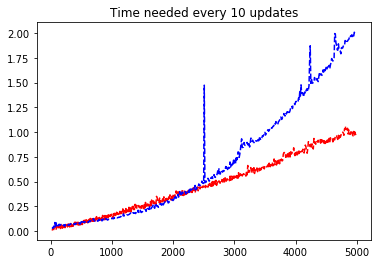

In [16]:
import matplotlib.pyplot as plt
t = np.arange(20,5000,10)
plt.plot(t, time_ol, 'r--', t, time_offline,'b--')
plt.title("Time needed every 10 updates")
plt.show()